In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import textwrap
import numpy as np
from scipy.stats import f_oneway

In [2]:
# Functions


# Single run

def analyze_run(sheet_name, data):
    df = data[sheet_name].drop(data[sheet_name].columns[0], axis=1)
    print(f"Analysis for {sheet_name}:")
    means = df.mean()
    std_devs = df.std()
    for col in df.columns:   # Print mean and std
        mean = means[col]
        std_dev = std_devs[col]
        description = feature_descriptions.get(col, "No description available")
        print(f"{col}: {mean:.2f} ± {std_dev:.2f} - {description}")

    n_cols = len(df.columns)
    n_rows = (n_cols + 3) // 4
    fig, axes = plt.subplots(n_rows, 4, figsize=(25, 6 * n_rows))
    axes = axes.flatten()
    for i, col in enumerate(df.columns):
        sns.histplot(df[col], ax=axes[i], kde=True)
        description = feature_descriptions.get(col, '')
        wrapped_title = textwrap.fill(f"{col}\n: {description}", width=60)
        axes[i].set_title(wrapped_title, fontsize=10)
    for j in range(i + 1, n_rows * 4):
        axes[j].set_visible(False)
    plt.tight_layout()
    plt.show()


    
# Multiple runs    

def plot_histogram(data, sheets, metric, ax):
    for sheet in sheets:
        series = pd.to_numeric(data[sheet][metric], errors='coerce').dropna()
        sns.histplot(series, kde=True, ax=ax, label=sheet, element="step", stat="density", alpha=0.5)
    description = feature_descriptions.get(metric, 'No description available')
    ax.set_title(textwrap.fill(f'Histogram of {metric}: {description}', width=30))
    ax.set_xlabel(metric)
    ax.set_ylabel('Density')
    ax.legend()

def plot_mean_std(data, sheets, metric, ax):
    means, std_devs = [], []
    for sheet in sheets:
        means.append(data[sheet][metric].mean())
        std_devs.append(data[sheet][metric].std())
    ax.errorbar(sheets, means, yerr=std_devs, fmt='-o', capsize=5)
    description = feature_descriptions.get(metric, 'No description available')
    ax.set_title(textwrap.fill(f'Mean/Std Dev of {metric}: {description}', width=30))
    ax.set_xlabel('Run')
    ax.set_ylabel('Value')
    
def plot_boxplots_for_runs(data, sheets, metric, ax):
    # Collect data for each sheet
    boxplot_data = [data[sheet][metric].dropna() for sheet in sheets if metric in data[sheet].columns]

    # Create the boxplot
    if boxplot_data:
        ax.boxplot(boxplot_data, labels=sheets)
        description = feature_descriptions.get(metric, 'No description available')
        ax.set_title(f'Boxplot of {metric}: {description}')
        ax.set_xlabel('Run')
        ax.set_ylabel(f'{metric} [pixels]')
    else:
        ax.text(0.5, 0.5, f'No data available for {metric}', ha='center', va='center')
        ax.axis('off')
        
        
def plot_log_boxplots_for_runs(data, sheets, metric, ax):
    # Collect log-transformed data for each sheet
    boxplot_data = [np.log(data[sheet][metric].dropna()) for sheet in sheets if metric in data[sheet].columns]

    # Create the boxplot
    if boxplot_data:
        ax.boxplot(boxplot_data, labels=sheets)
        description = feature_descriptions.get(metric, 'No description available')
        ax.set_title(f'Log-transformed Boxplot of {metric}: {description}')
        ax.set_xlabel('Run')
        ax.set_ylabel(f'Log-transformed {metric} [pixels]')
    else:
        ax.text(0.5, 0.5, f'No data available for {metric}', ha='center', va='center')
        ax.axis('off')

def perform_anova_test(data, sheets, metric):
    # Collect data for ANOVA
    groups = [data[sheet][metric].dropna() for sheet in sheets if metric in data[sheet].columns]

    # Perform ANOVA
    if len(groups) >= 2:  # ANOVA requires at least two groups
        f_stat, p_value = f_oneway(*groups)
        return f_stat, p_value
    else:
        return None, None

def analyze_metrics(data, sheets, metrics):
    for metric in metrics:
           # ANOVA Test
        f_stat, p_value = perform_anova_test(data, sheets, metric)
        if f_stat is not None:
            print(f"ANOVA for {metric}: F-Statistic = {f_stat}, p-value = {p_value}")
            if p_value < 0.05:
                print(f"There is a statistically significant difference for {metric} across the runs.")
            else:
                print(f"No statistically significant difference for {metric} across the runs.")
        else:
            print(f"Insufficient data to perform ANOVA for {metric}")
            
            
            
def plot_metrics(data, sheets, metrics):
    num_metrics = len(metrics)
    for i in range(num_metrics):
        # Create a new figure for the histogram of the current metric
        plt.figure(figsize=(20, 10))
        plot_histogram(data, sheets, metrics[i], plt.gca())
        plt.tight_layout()
        #plt.savefig(f'{metrics[i]}_histogram.png', format='png', dpi=300, bbox_inches='tight')
        plt.show()
        plt.close()

        # Create a new figure for the mean and std of the current metric
        plt.figure(figsize=(20, 10))
        plot_mean_std(data, sheets, metrics[i], plt.gca())
        plt.tight_layout()
        #plt.savefig(f'{metrics[i]}_mean_std.png', format='png', dpi=300, bbox_inches='tight')
        plt.show()
        plt.close()
        
         # Create a new figure for the boxplot of the current metric
        plt.figure(figsize=(20, 10))
        plot_boxplots_for_runs(data, sheets, metrics[i], plt.gca())  # Updated function call
        plt.tight_layout()
        #plt.savefig(f'{metrics[i]}_boxplot.png', format='png', dpi=300, bbox_inches='tight')
        plt.show()
        plt.close()

         # Create a new figure for the boxplot of the current metric
        plt.figure(figsize=(20, 10))
        plot_log_boxplots_for_runs(data, sheets, metrics[i], plt.gca())  # Updated function call
        plt.tight_layout()
        #plt.savefig(f'{metrics[i]}_boxplot_log.png', format='png', dpi=300, bbox_inches='tight')
        plt.show()
        plt.close()


        
# Feature Descriptions

feature_descriptions = {
    'Area': 'Area of selection in square pixels. Calibrated units if scaled.',
    'Mean': 'Average gray value within the selection. Sum of gray values divided by the number of pixels.',
    'StdDev': 'Standard deviation of the gray values used to generate the mean gray value.',
    'Mode': 'Modal Gray Value - Most frequently occurring gray value within the selection.',
    'Min': 'Minimum gray value within the selection.',
    'Max': 'Maximum gray value within the selection.',
    'X': 'Centroid - The center point of the selection. Average of the x coordinates of all pixels.',
    'Y': 'Centroid - The center point of the selection. Average of the y coordinates of all pixels.',
    'XM': 'Center of Mass - Brightness-weighted average of the x coordinates of all pixels.',
    'YM': 'Center of Mass - Brightness-weighted average of the y coordinates of all pixels.',
    'Perim.': 'Perimeter - The length of the outside boundary of the selection.',
    'BX': 'Bounding Rectangle - X coordinate of the upper left corner.',
    'BY': 'Bounding Rectangle - Y coordinate of the upper left corner.',
    'Width': 'Bounding Rectangle - Width of the smallest rectangle enclosing the selection.',
    'Height': 'Bounding Rectangle - Height of the smallest rectangle enclosing the selection.',
    'Major': 'Fit Ellipse - Major axis of the best fitting ellipse to the selection.',
    'Minor': 'Fit Ellipse - Minor axis of the best fitting ellipse to the selection.',
    'Angle': 'Fit Ellipse - Angle between the primary axis of the ellipse, and a line parallel to the x-axis.',
    'Circ.': 'Circularity - Calculated as 4π*area/perimeter^2. Indicates circularity of the shape.',
    'Feret': 'Feret\'s Diameter - Longest distance between any two points along the selection boundary.',
    'IntDen': 'Integrated Density - Product of Area and Mean Gray Value. Total intensity of pixels in the selection.',
    'Median': 'The median gray value of the pixels in the image or selection.',
    'Skew': 'Skewness - Measures the asymmetry of the distribution of values about the mean.',
    'Kurt': 'Kurtosis - Measures the "tailedness" of the distribution. High kurtosis indicates heavy tails.',
    '%Area': 'Area Fraction - Percentage of pixels above a certain threshold or non-zero for non-thresholded images.',
    'RawIntDen': 'Raw Integrated Density - Sum of the values of the pixels in the image or selection.',
    'Slice': 'Stack Position - Current position (channel, slice, frame) in the stack or hyperstack.',
    'FeretX': 'Starting x-coordinate of the Feret\'s diameter.',
    'FeretY': 'Starting y-coordinate of the Feret\'s diameter.',
    'FeretAngle': 'Angle between the Feret\'s diameter and a line parallel to the x-axis.',
    'MinFeret': 'Minimum caliper diameter, the shortest distance between parallel tangents.',
    'AR': 'Aspect Ratio - Calculated as major_axis/minor_axis. Measure of elongation of the shape.',
    'Round': 'Roundness - Calculated as 4*area/(π*major_axis^2). Inverse of the aspect ratio.',
    'Solidity': 'Calculated as area/convex area. How much of the convex hull is occupied by the shape.',
}

In [3]:
# Load the dataset

file_path = 'Dataset_PartB.xlsx'
data = pd.read_excel(file_path, sheet_name=None)

Analysis for Run1:
Area: 1750.71 ± 553.27 - Area of selection in square pixels. Calibrated units if scaled.
Mean: 224.54 ± 38.71 - Average gray value within the selection. Sum of gray values divided by the number of pixels.
StdDev: 66.68 ± 29.97 - Standard deviation of the gray values used to generate the mean gray value.
Mode: 245.81 ± 47.54 - Modal Gray Value - Most frequently occurring gray value within the selection.
Min: 0.05 ± 3.41 - Minimum gray value within the selection.
Max: 255.00 ± 0.00 - Maximum gray value within the selection.
X: 60.40 ± 3.86 - Centroid - The center point of the selection. Average of the x coordinates of all pixels.
Y: 129.70 ± 56.21 - Centroid - The center point of the selection. Average of the y coordinates of all pixels.
XM: 60.32 ± 4.05 - Center of Mass - Brightness-weighted average of the x coordinates of all pixels.
YM: 129.84 ± 56.26 - Center of Mass - Brightness-weighted average of the y coordinates of all pixels.
Perim.: 156.85 ± 26.76 - Perimete

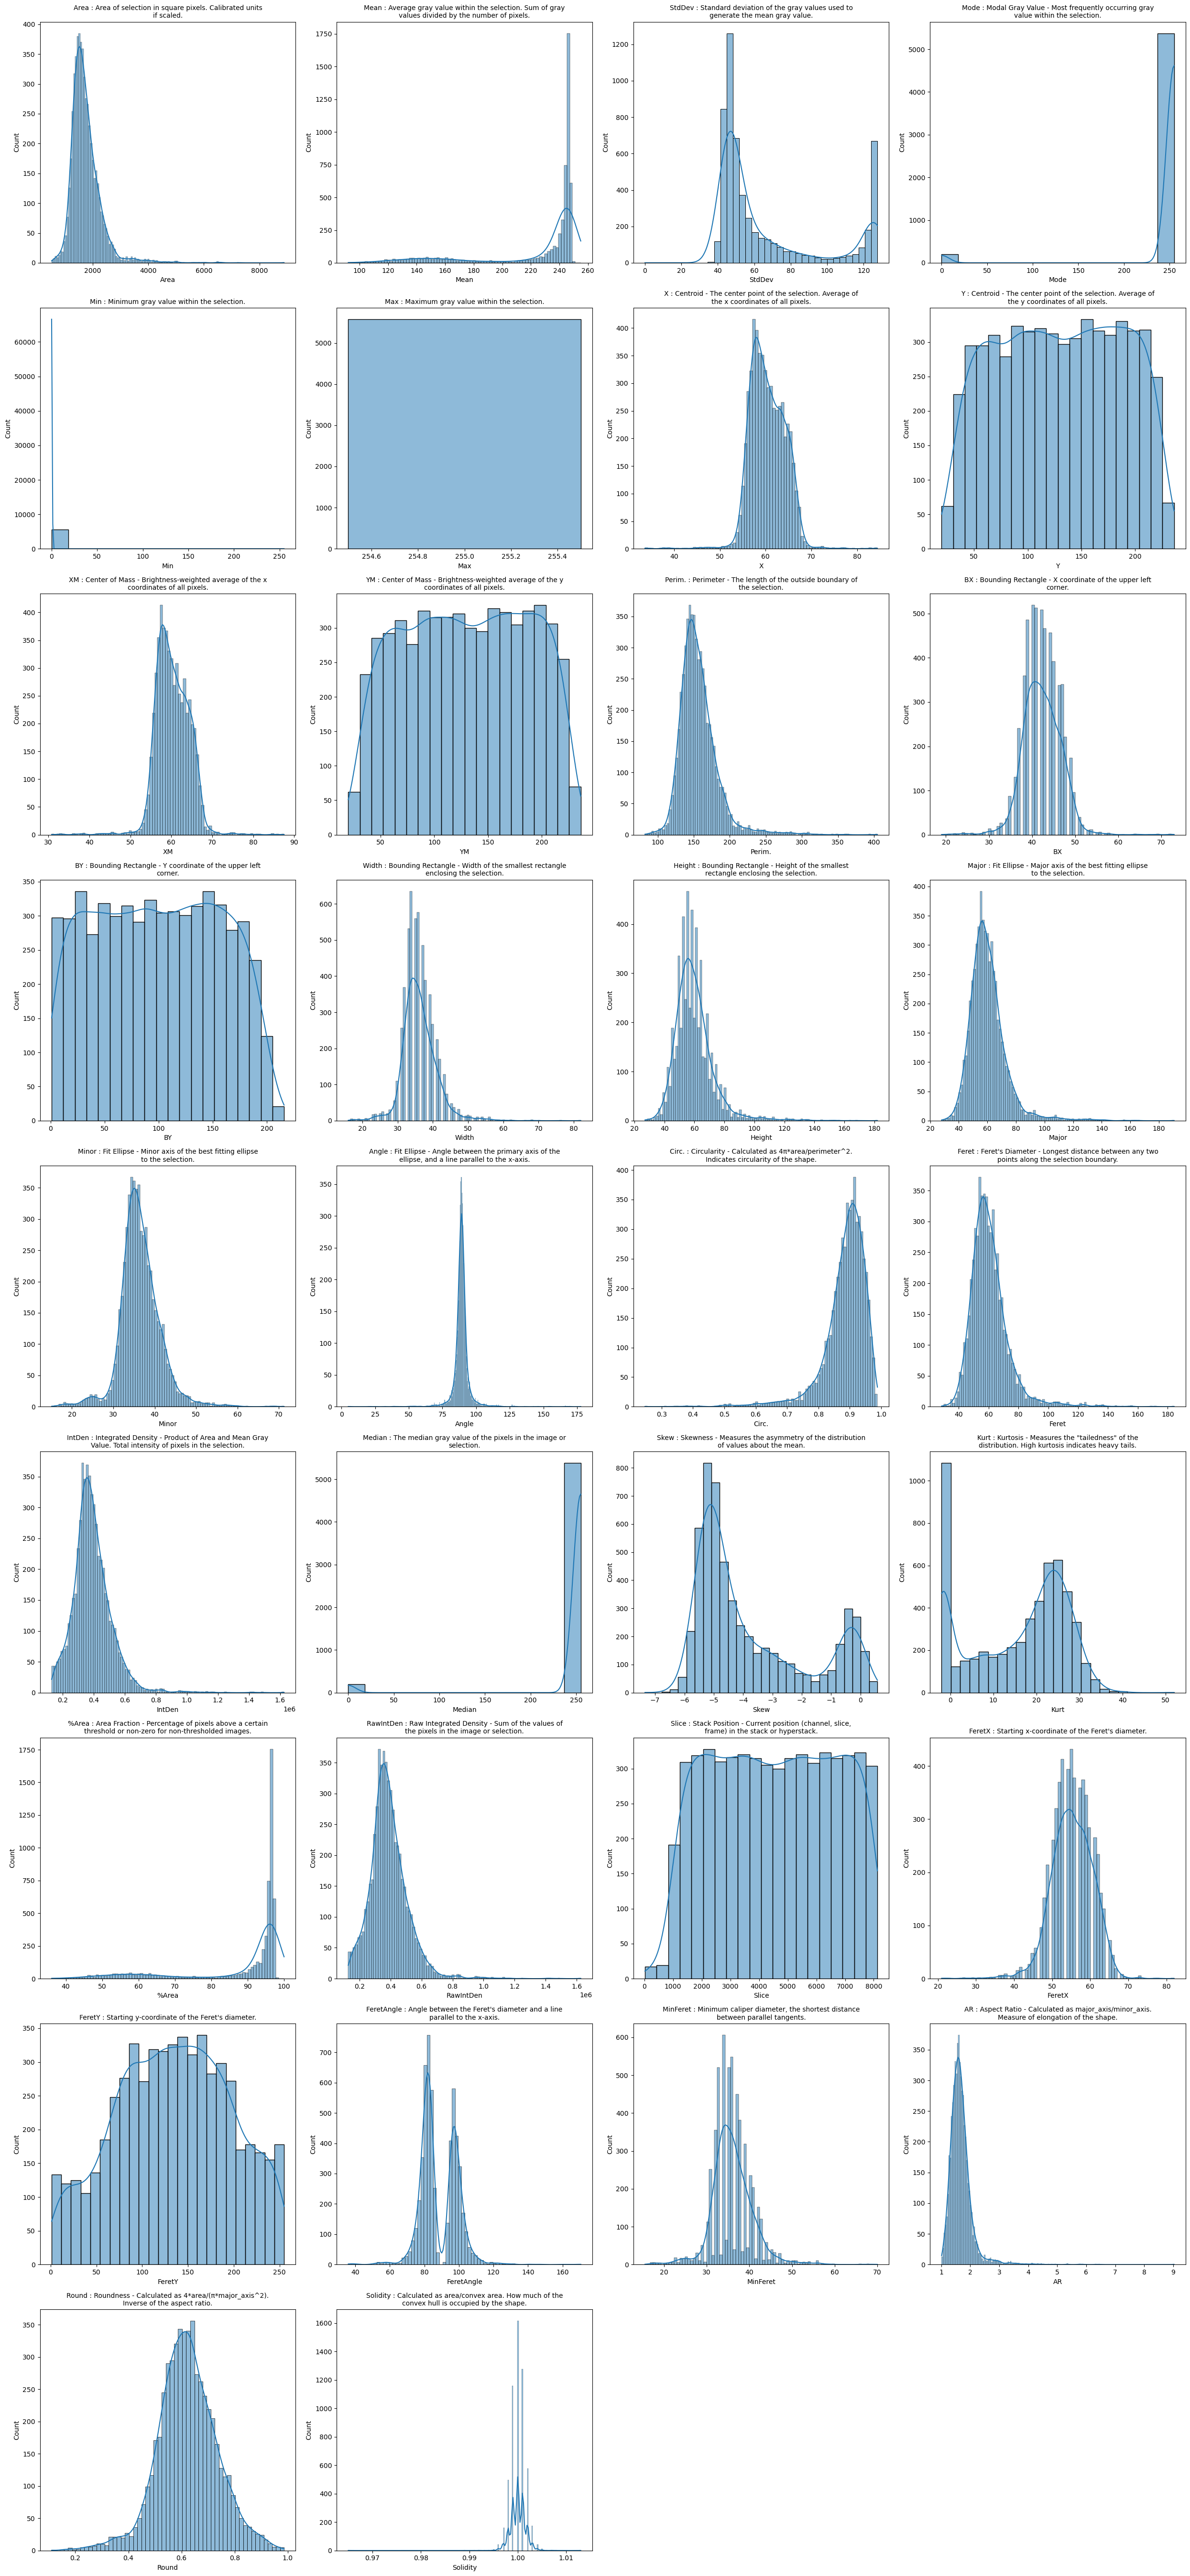

All Correlations with 'Time since detachment'
                   Metric  Pearson Coefficient  Spearman Coefficient
0   Time since detachment             1.000000              1.000000
1                   Round             0.266801              0.261048
2                   Circ.             0.191386              0.261325
3                      AR            -0.184324             -0.261070
4                  Height            -0.176863             -0.203944
5                   Major            -0.175535             -0.205329
6                   Feret            -0.173901             -0.202819
7                   Slice            -0.153845             -0.129886
8                  Perim.            -0.135210             -0.160094
9                    Area            -0.094936             -0.124841
10                 IntDen            -0.075447             -0.088543
11              RawIntDen            -0.075447             -0.088543
12                  Minor             0.065031           

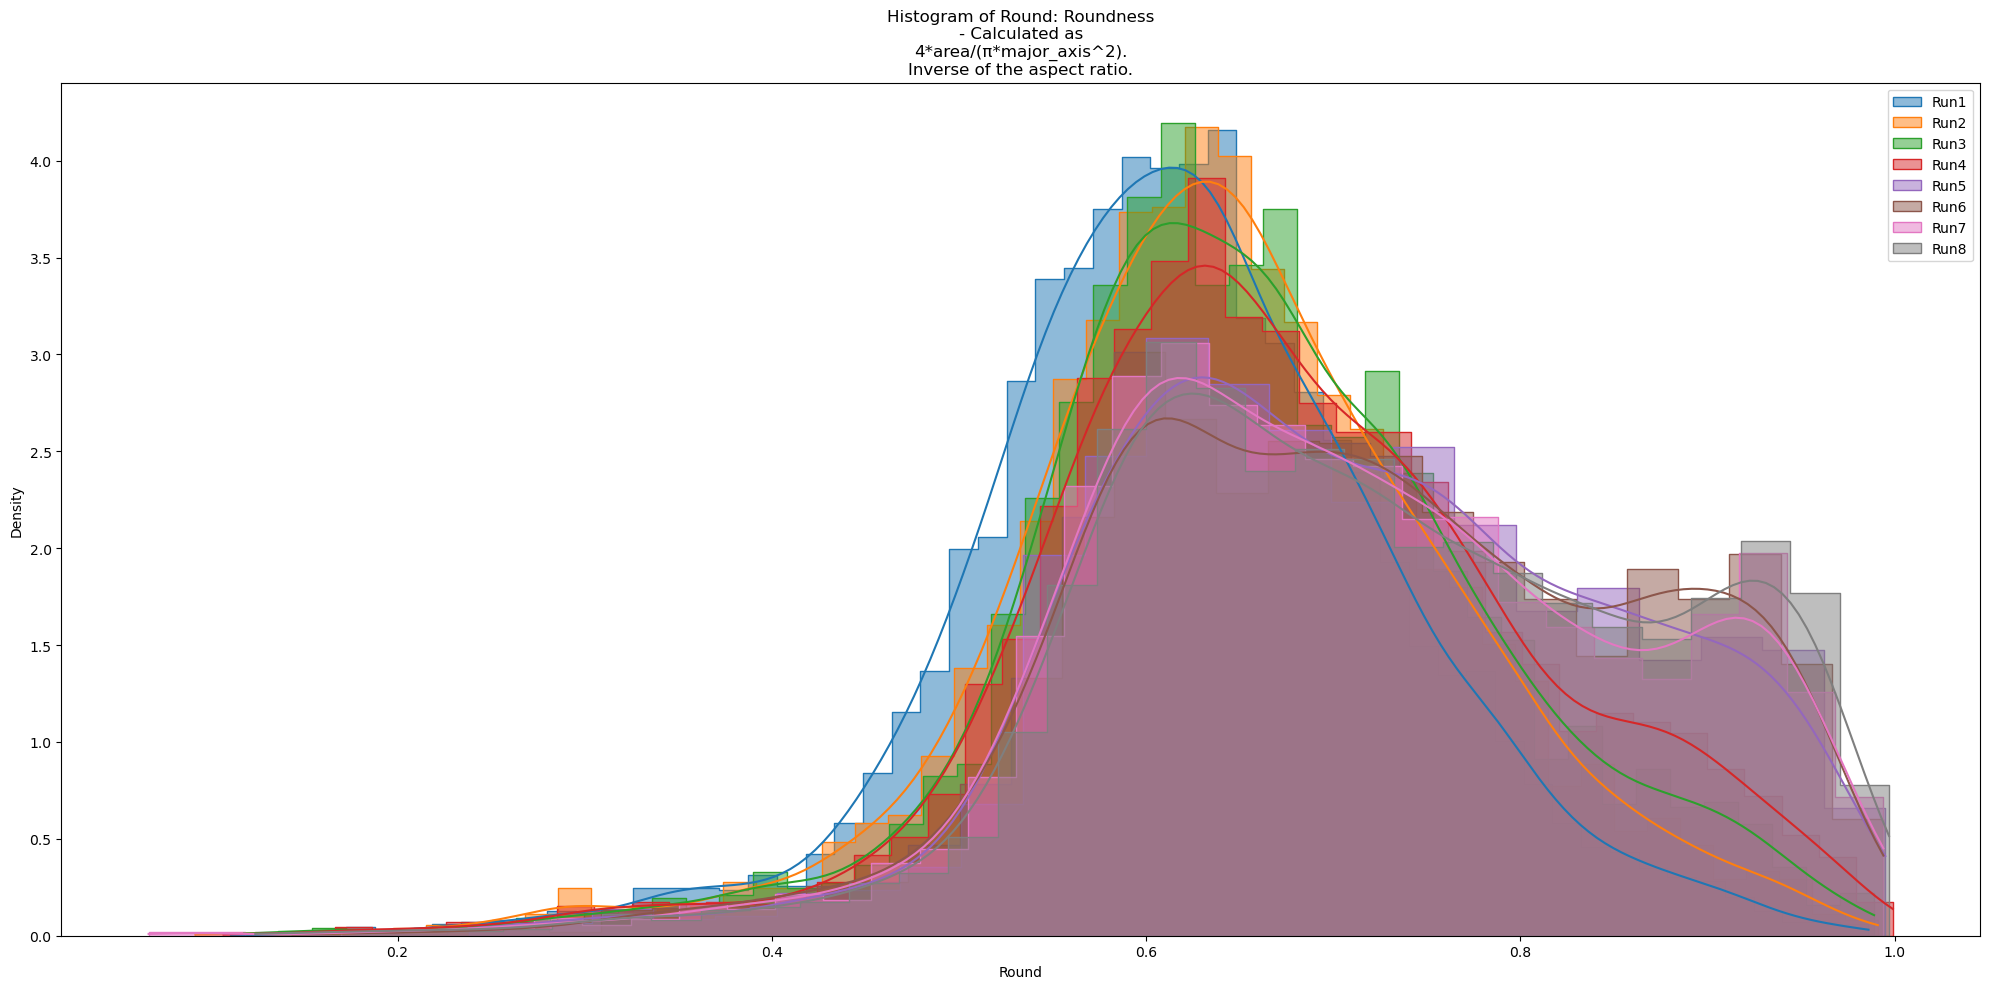

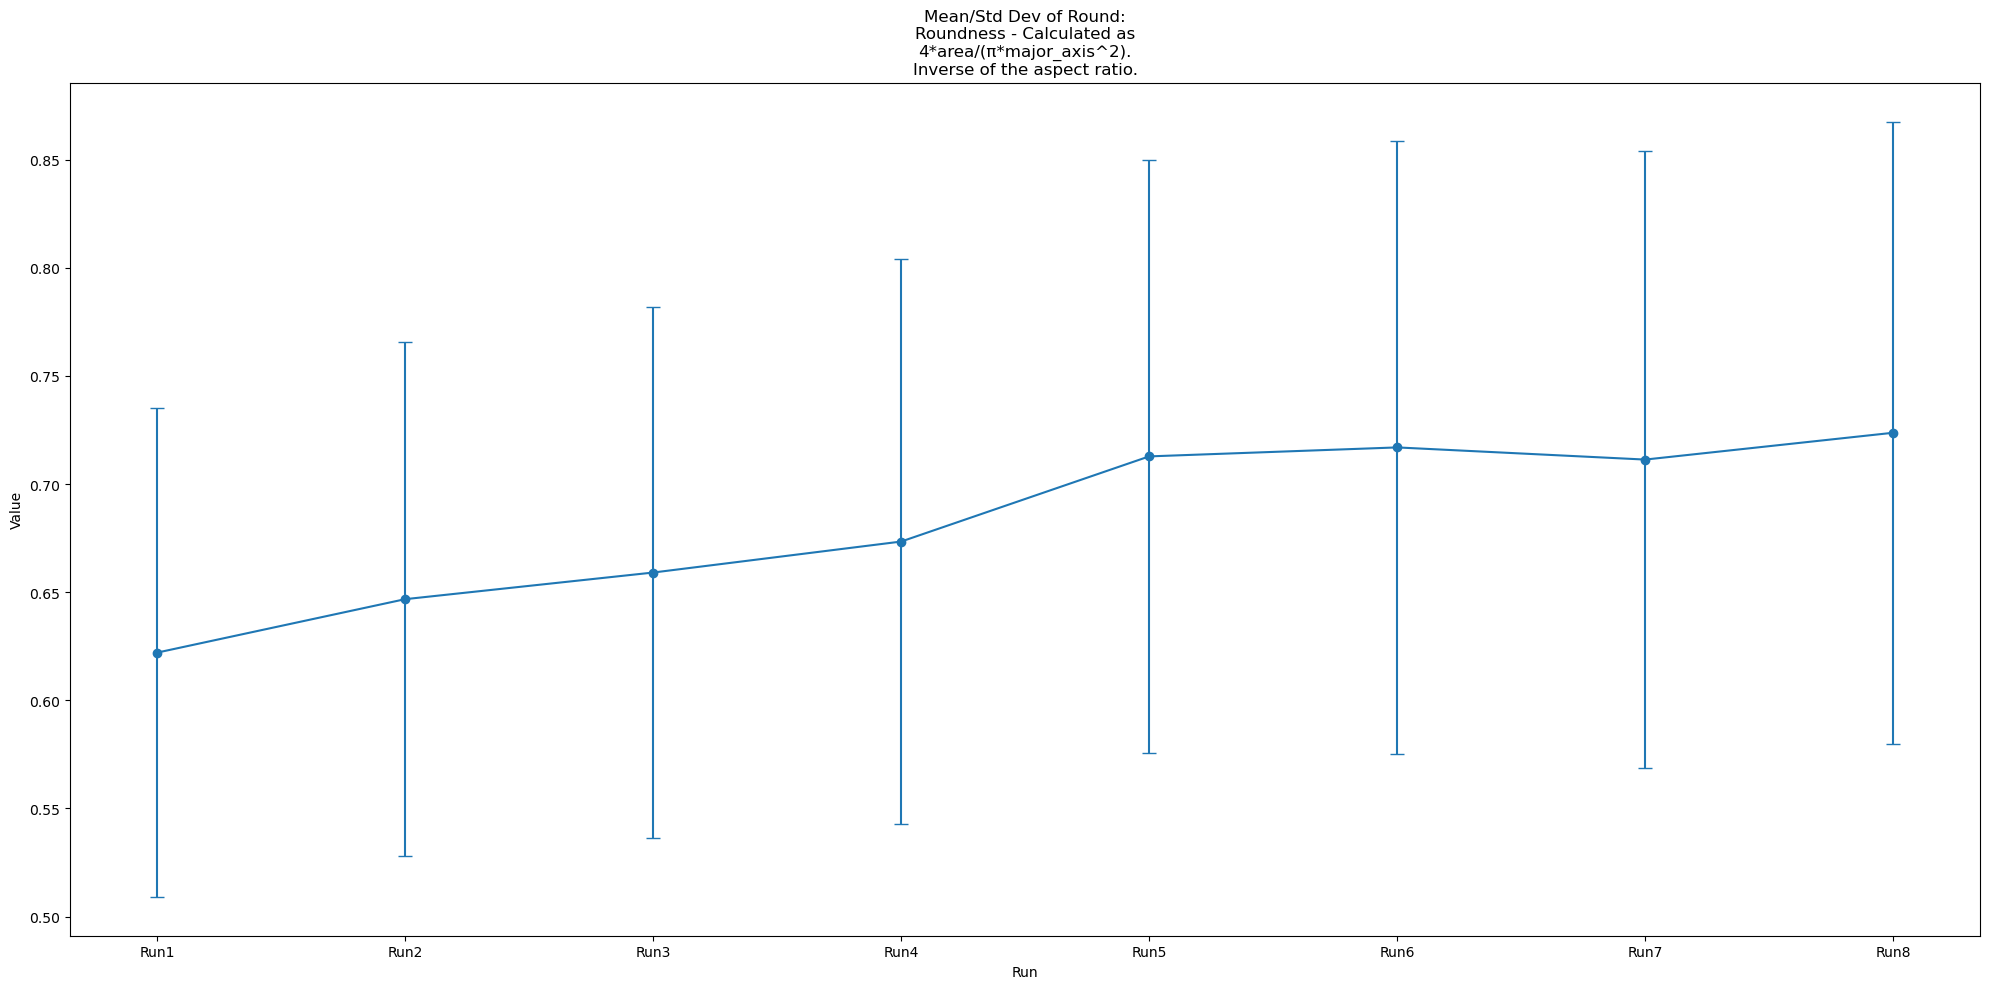

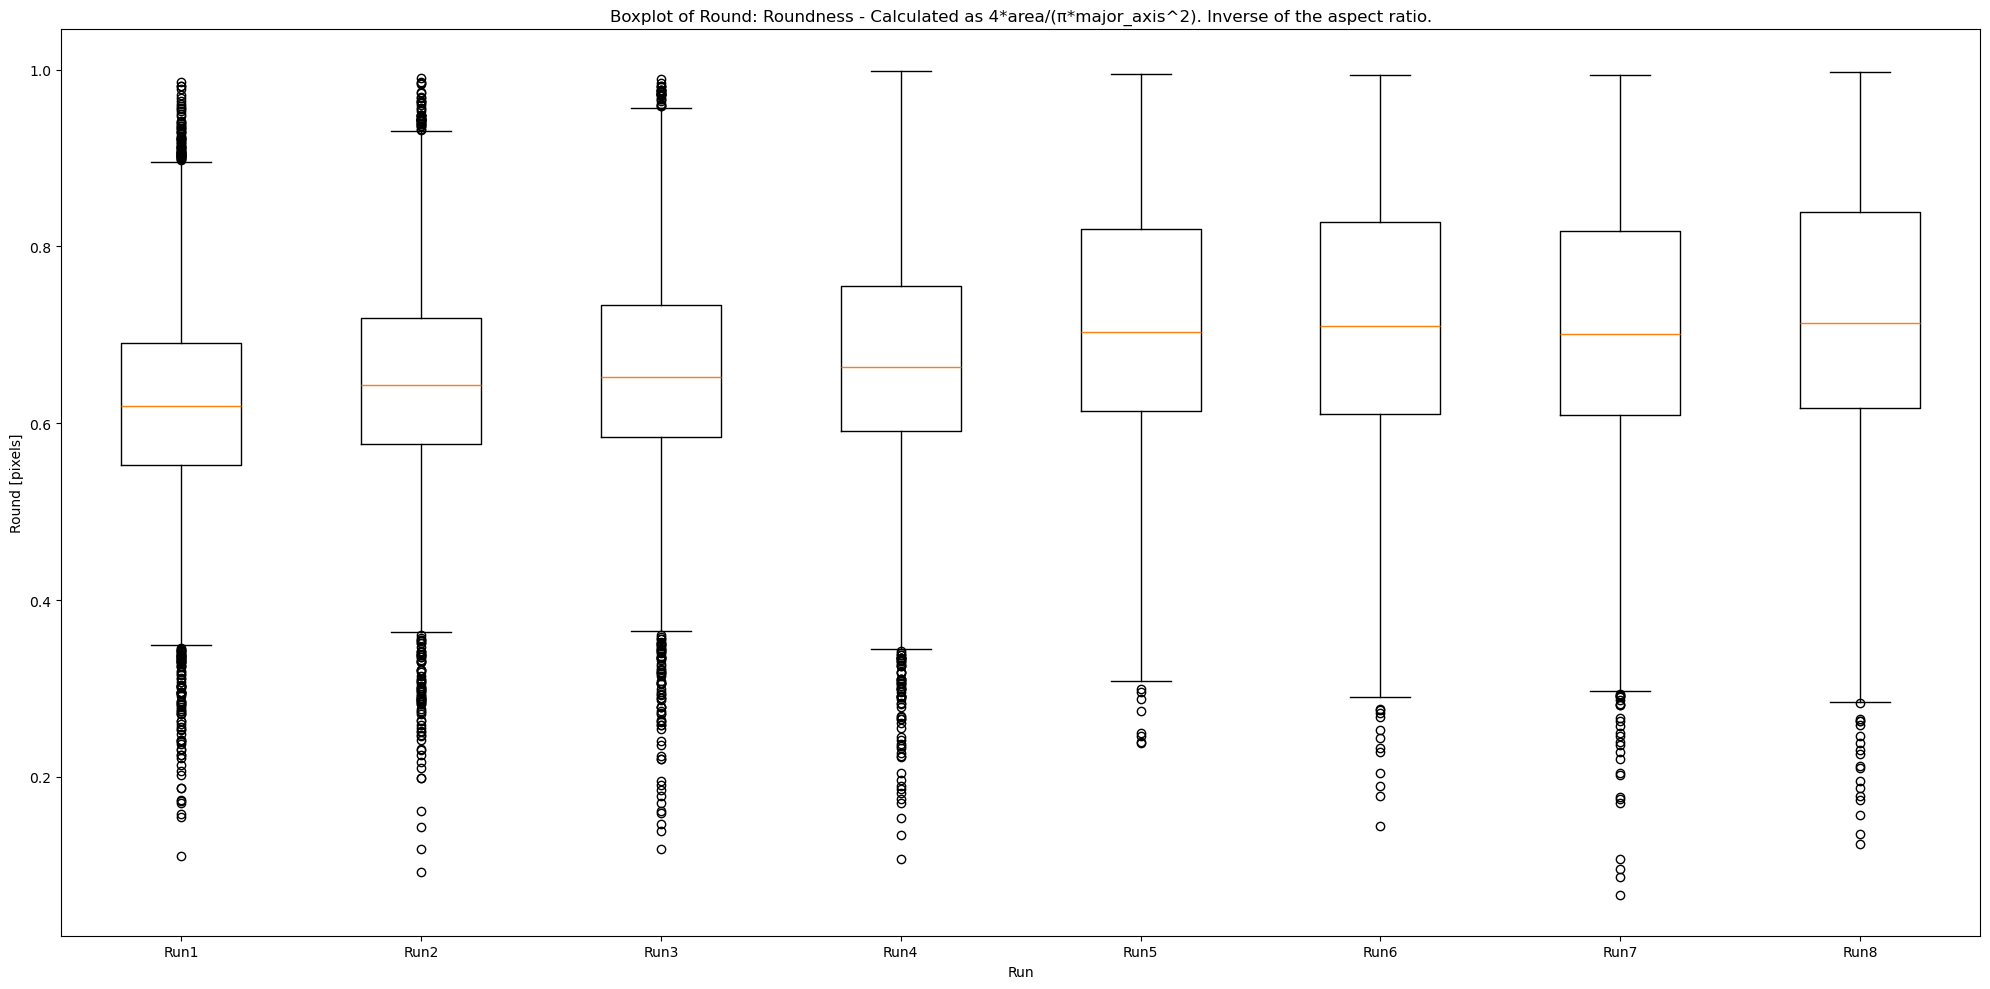

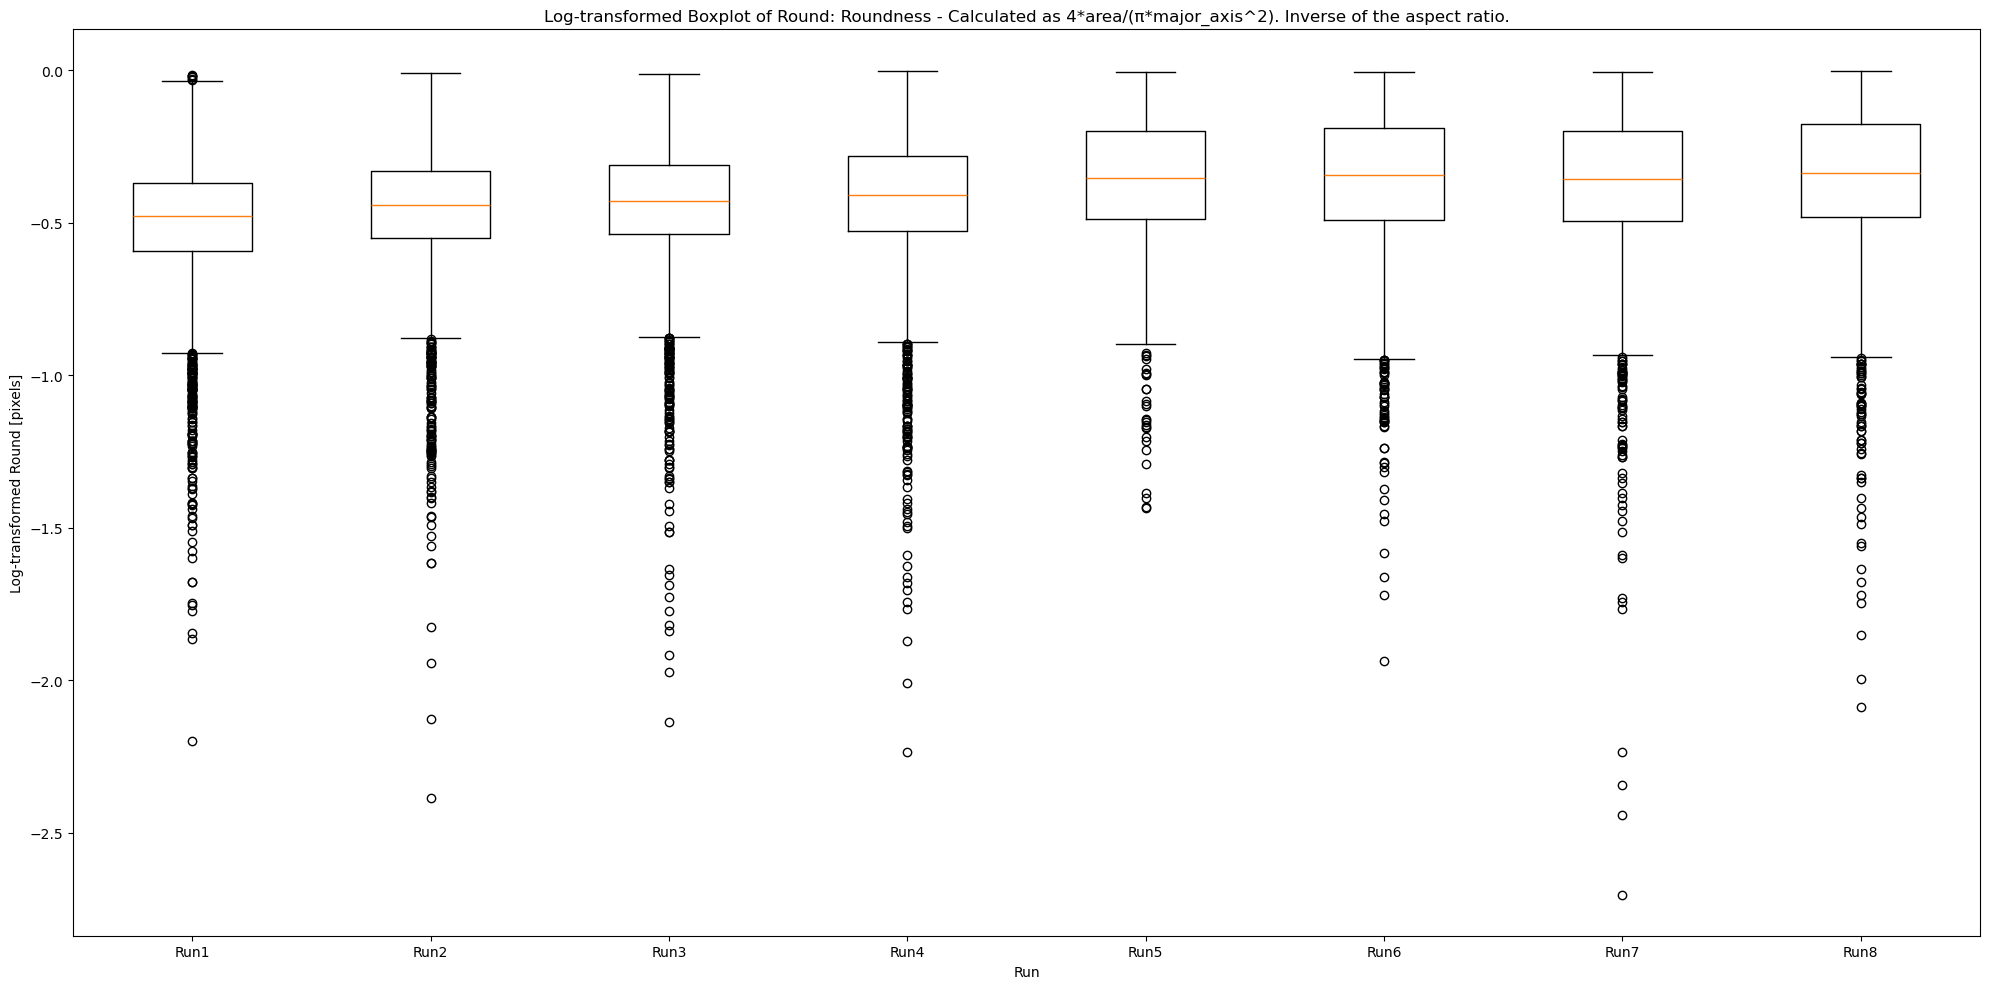

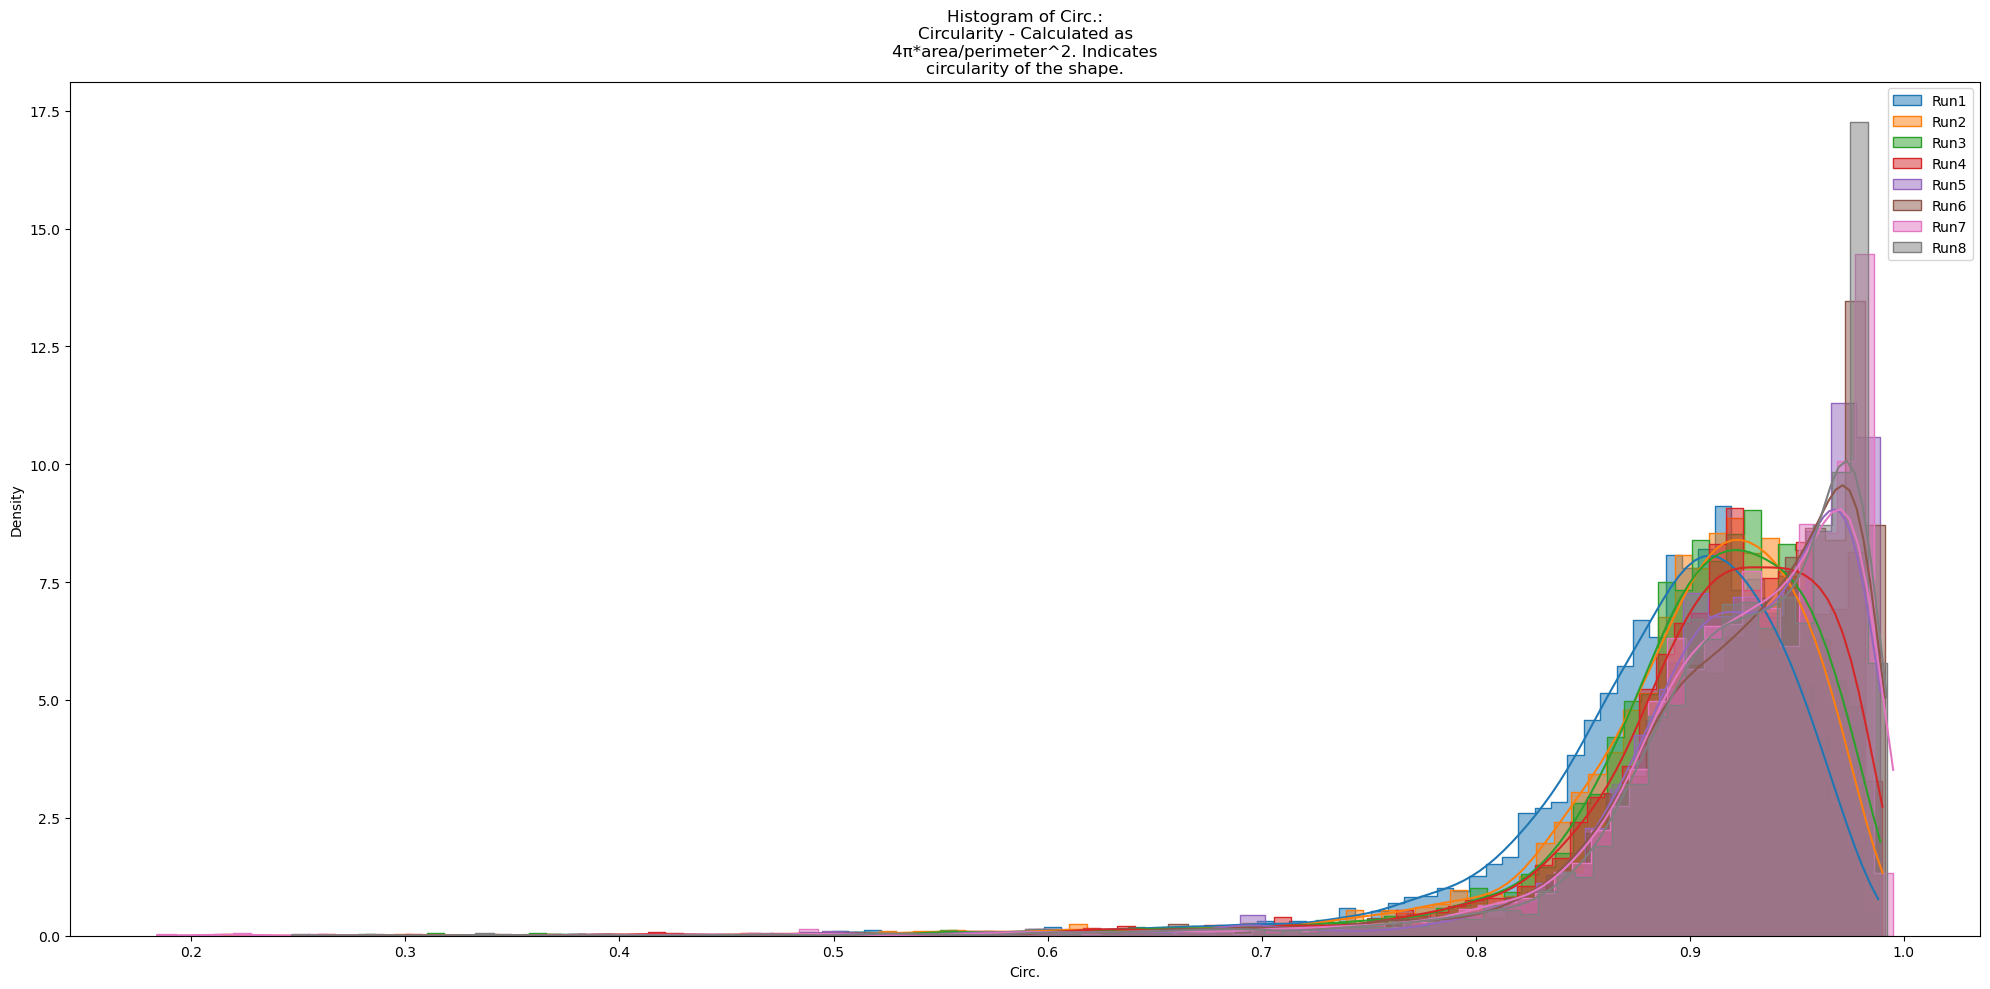

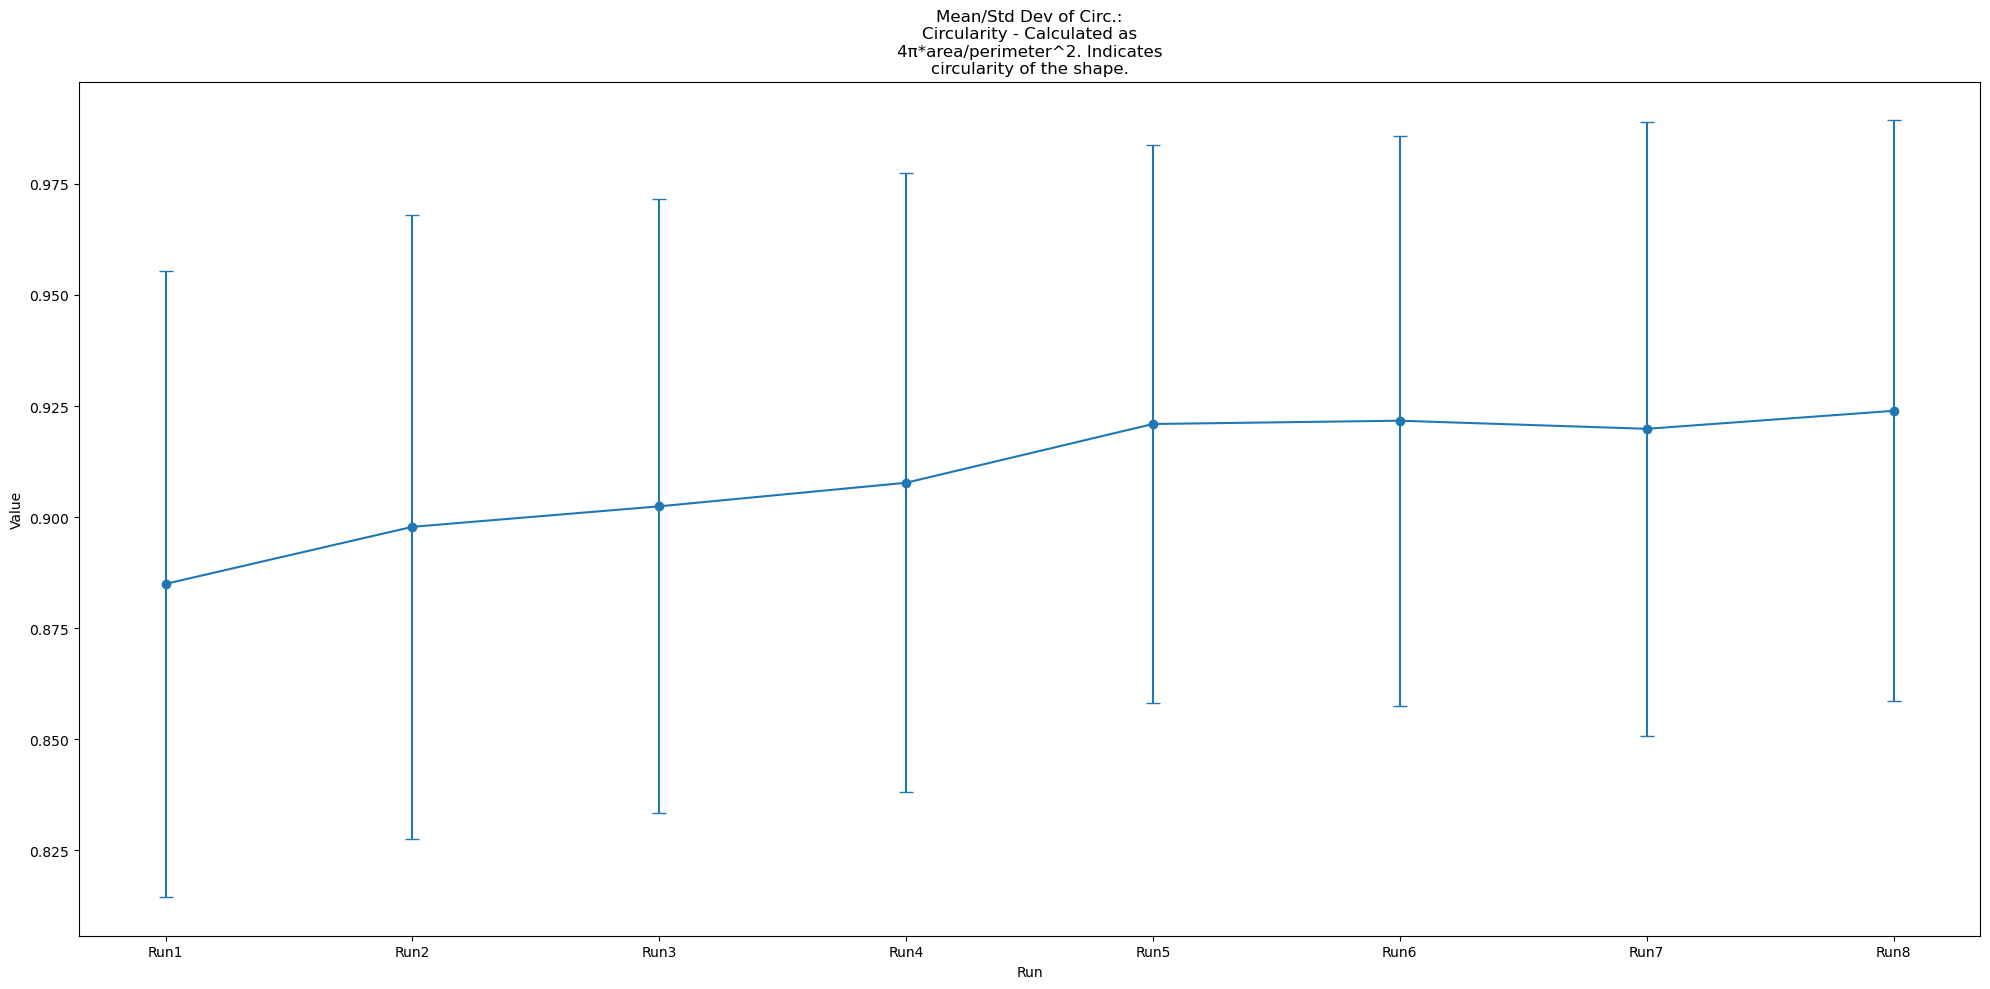

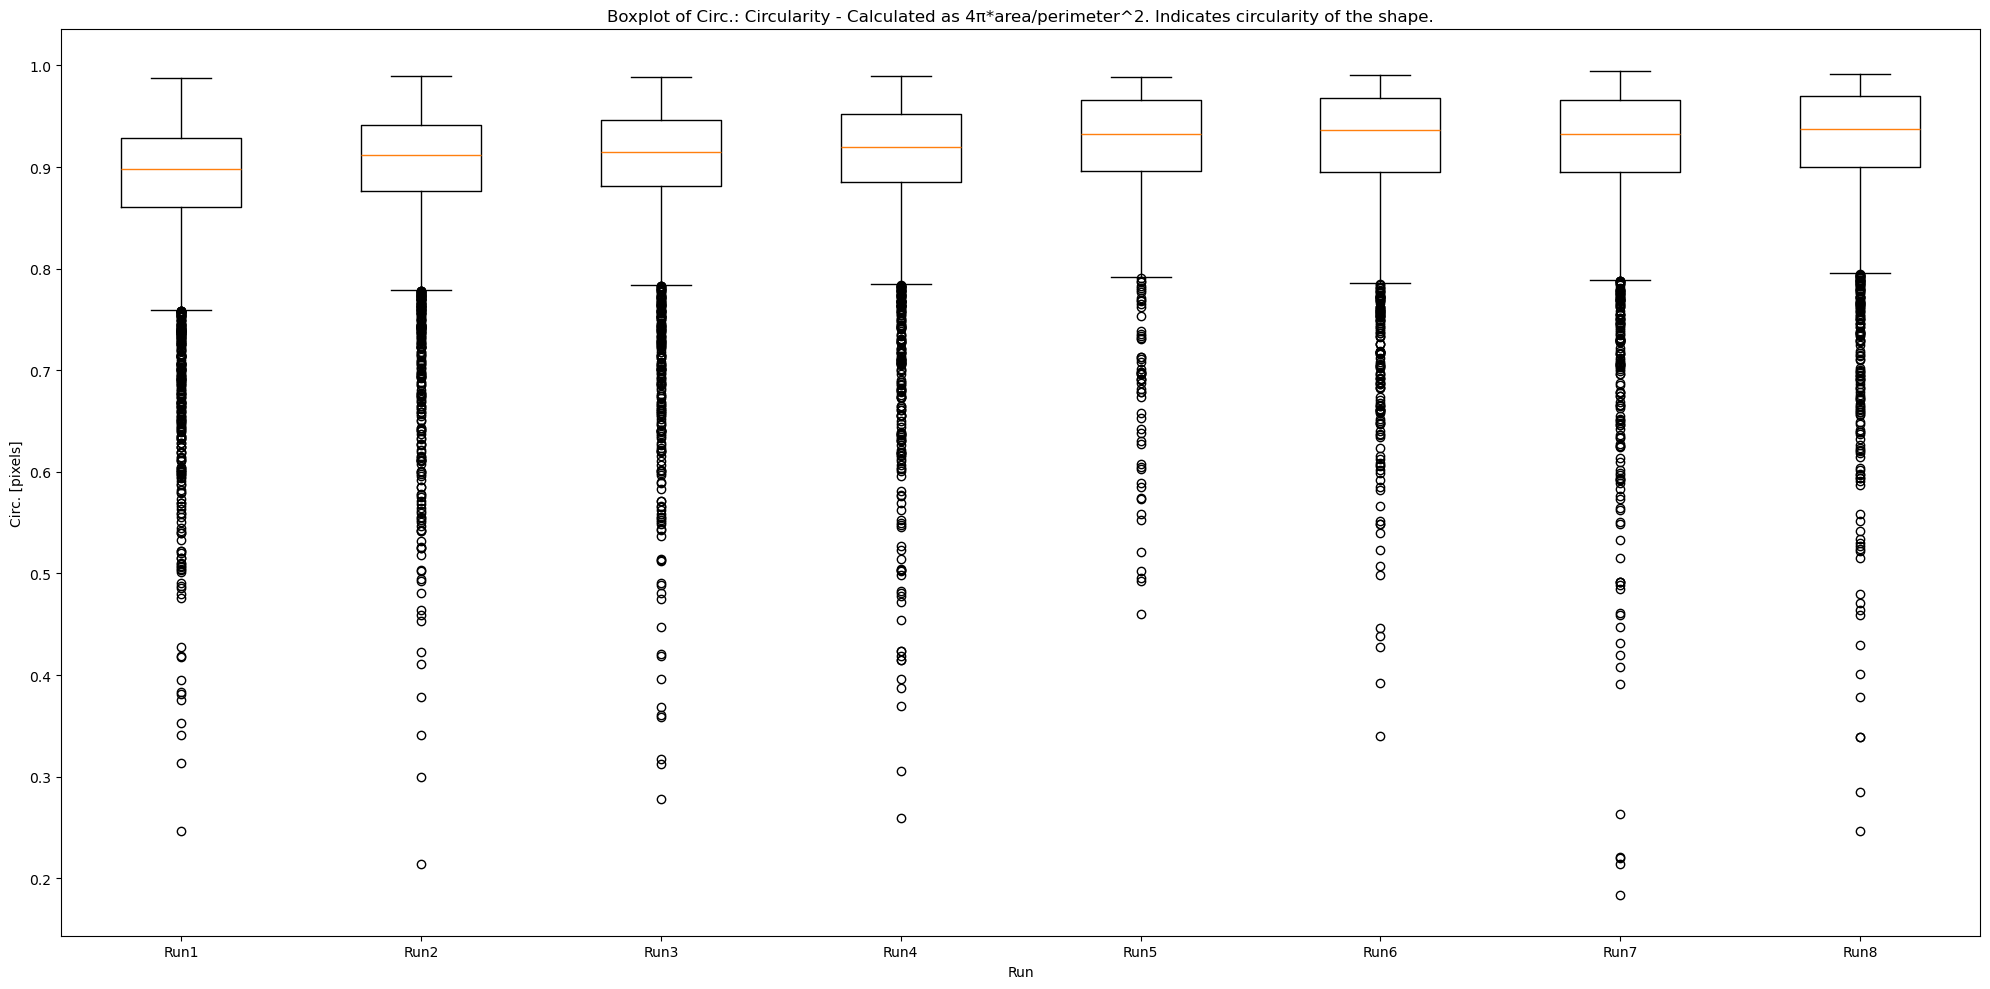

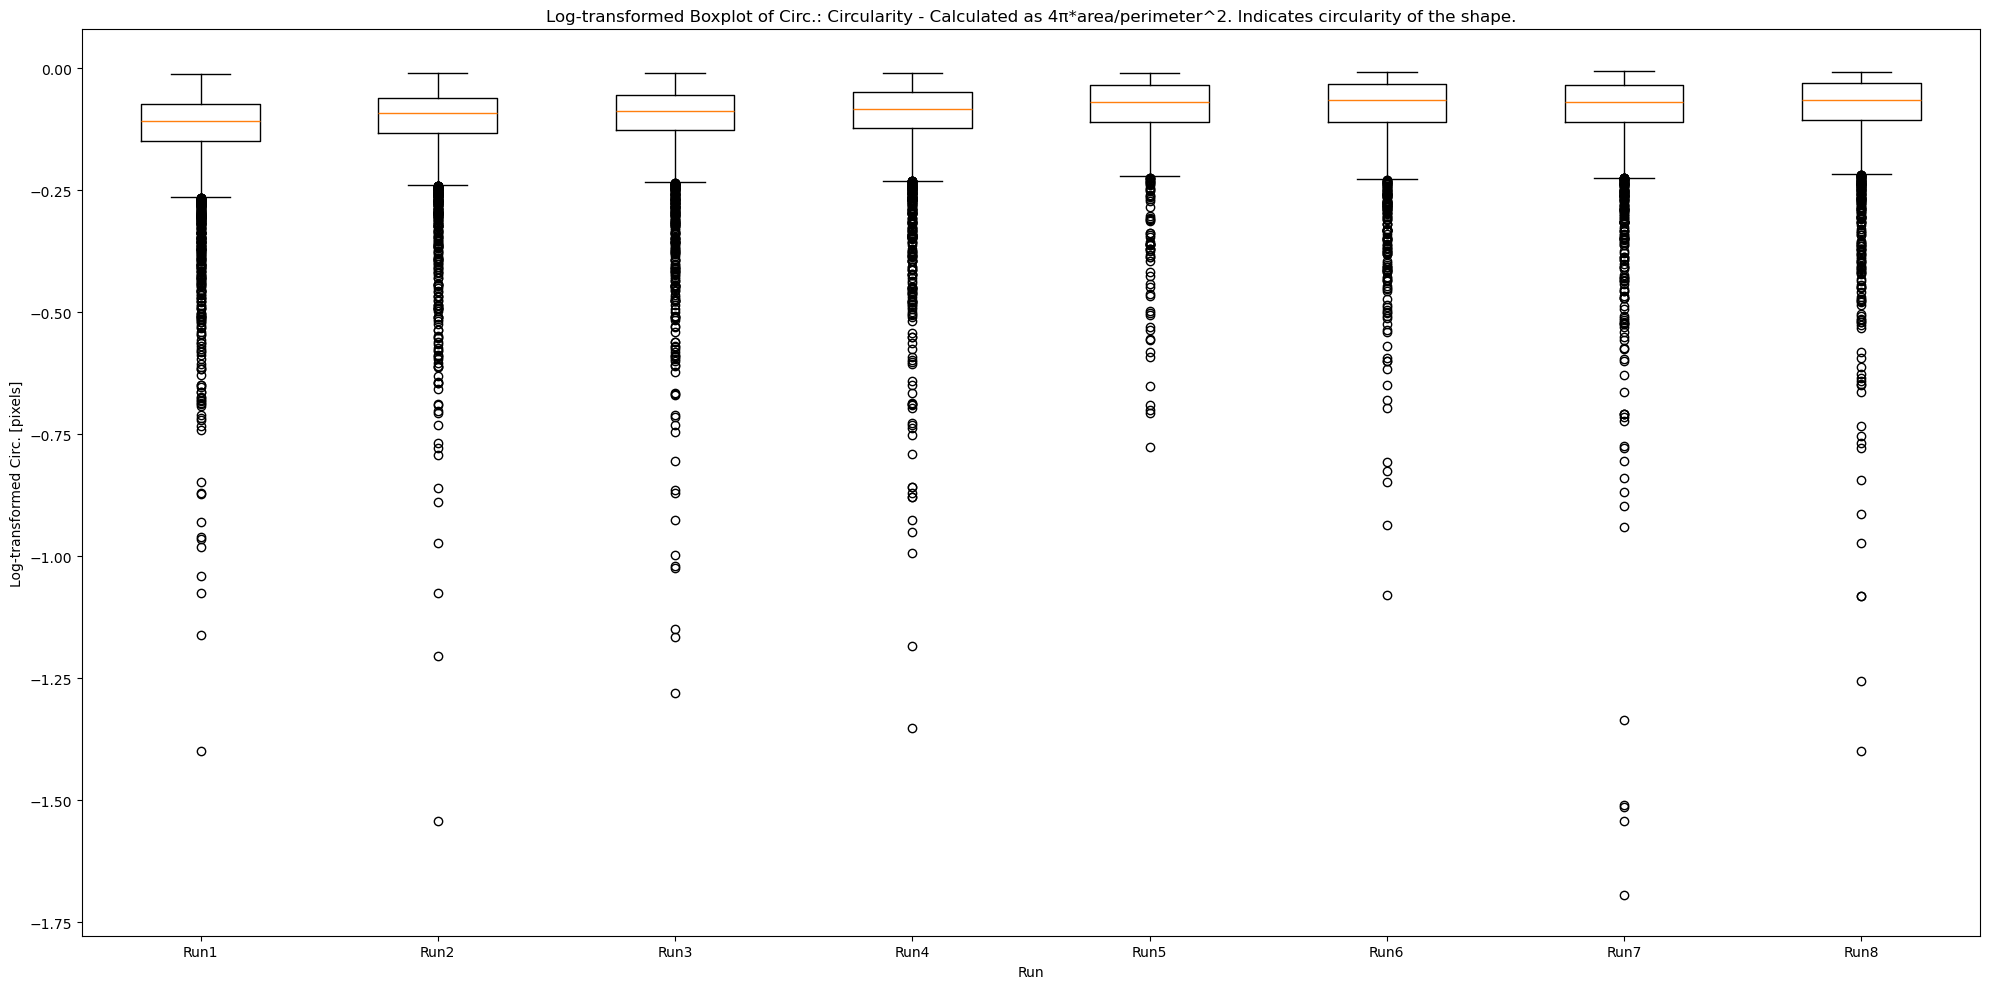

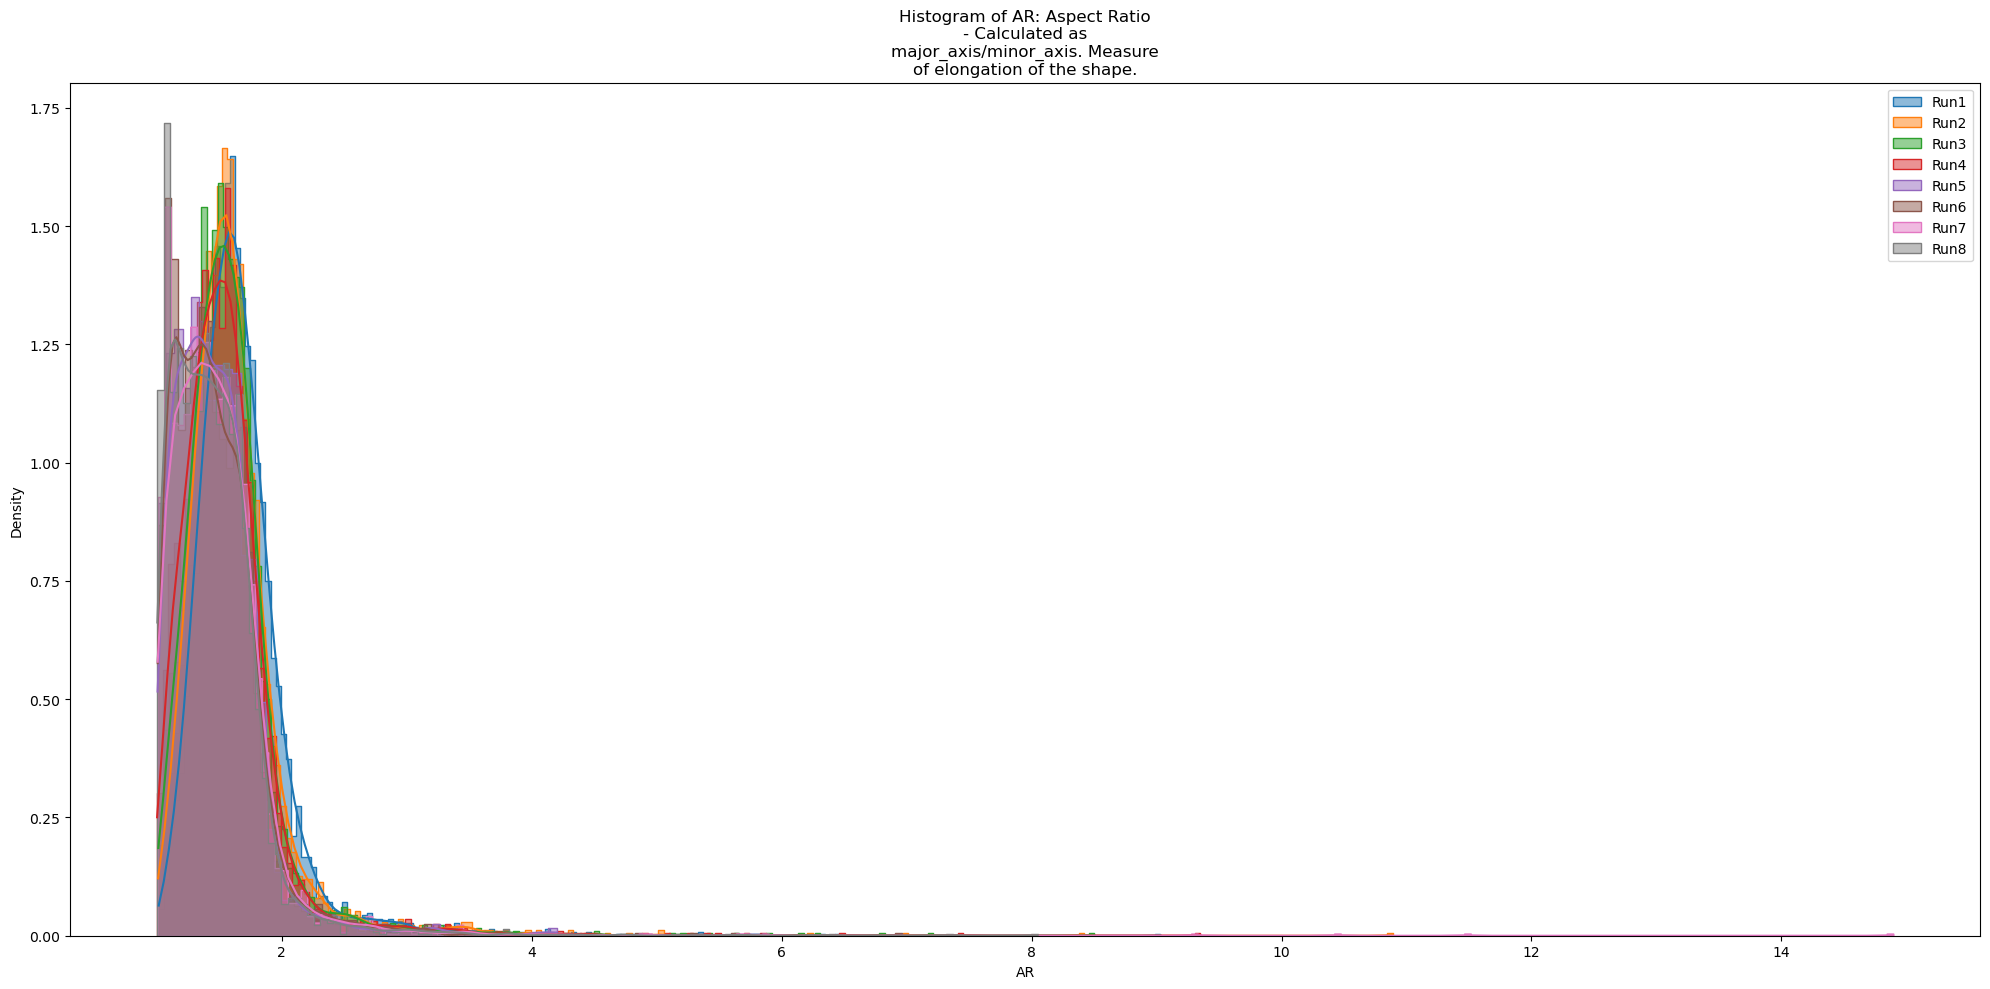

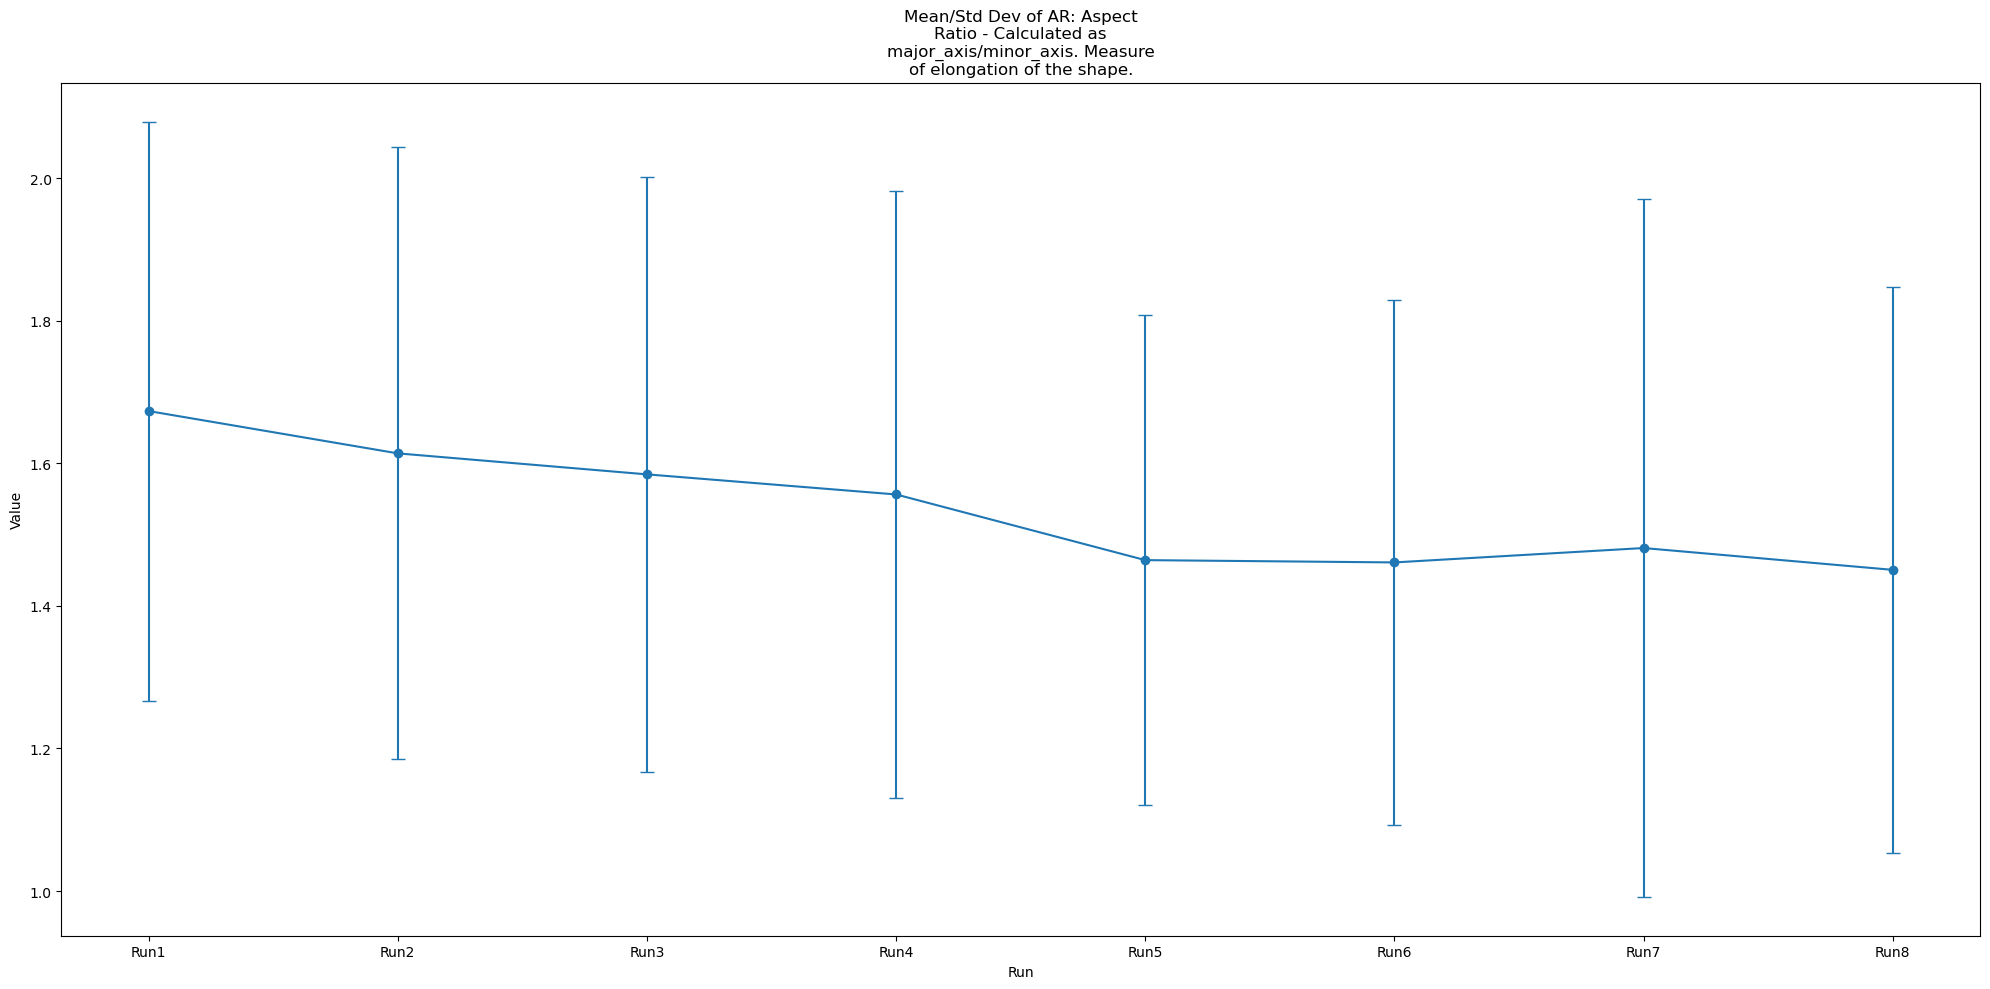

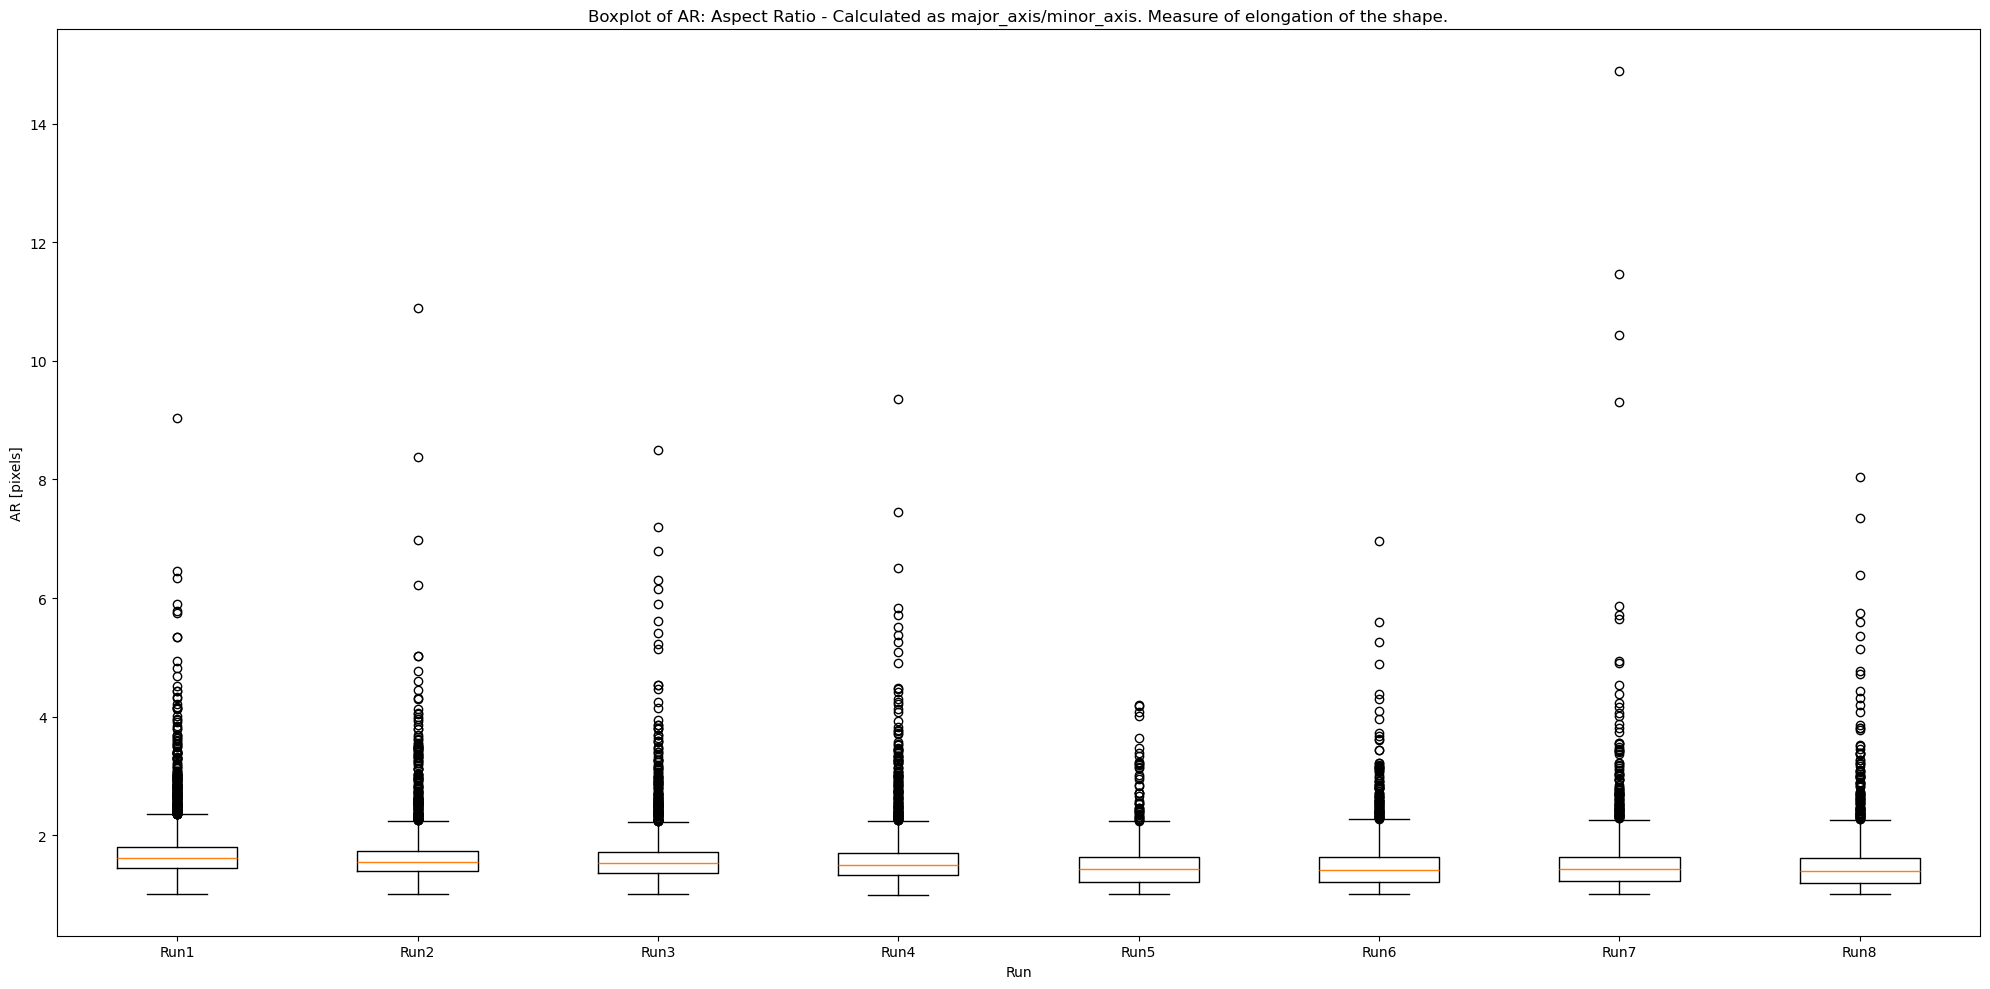

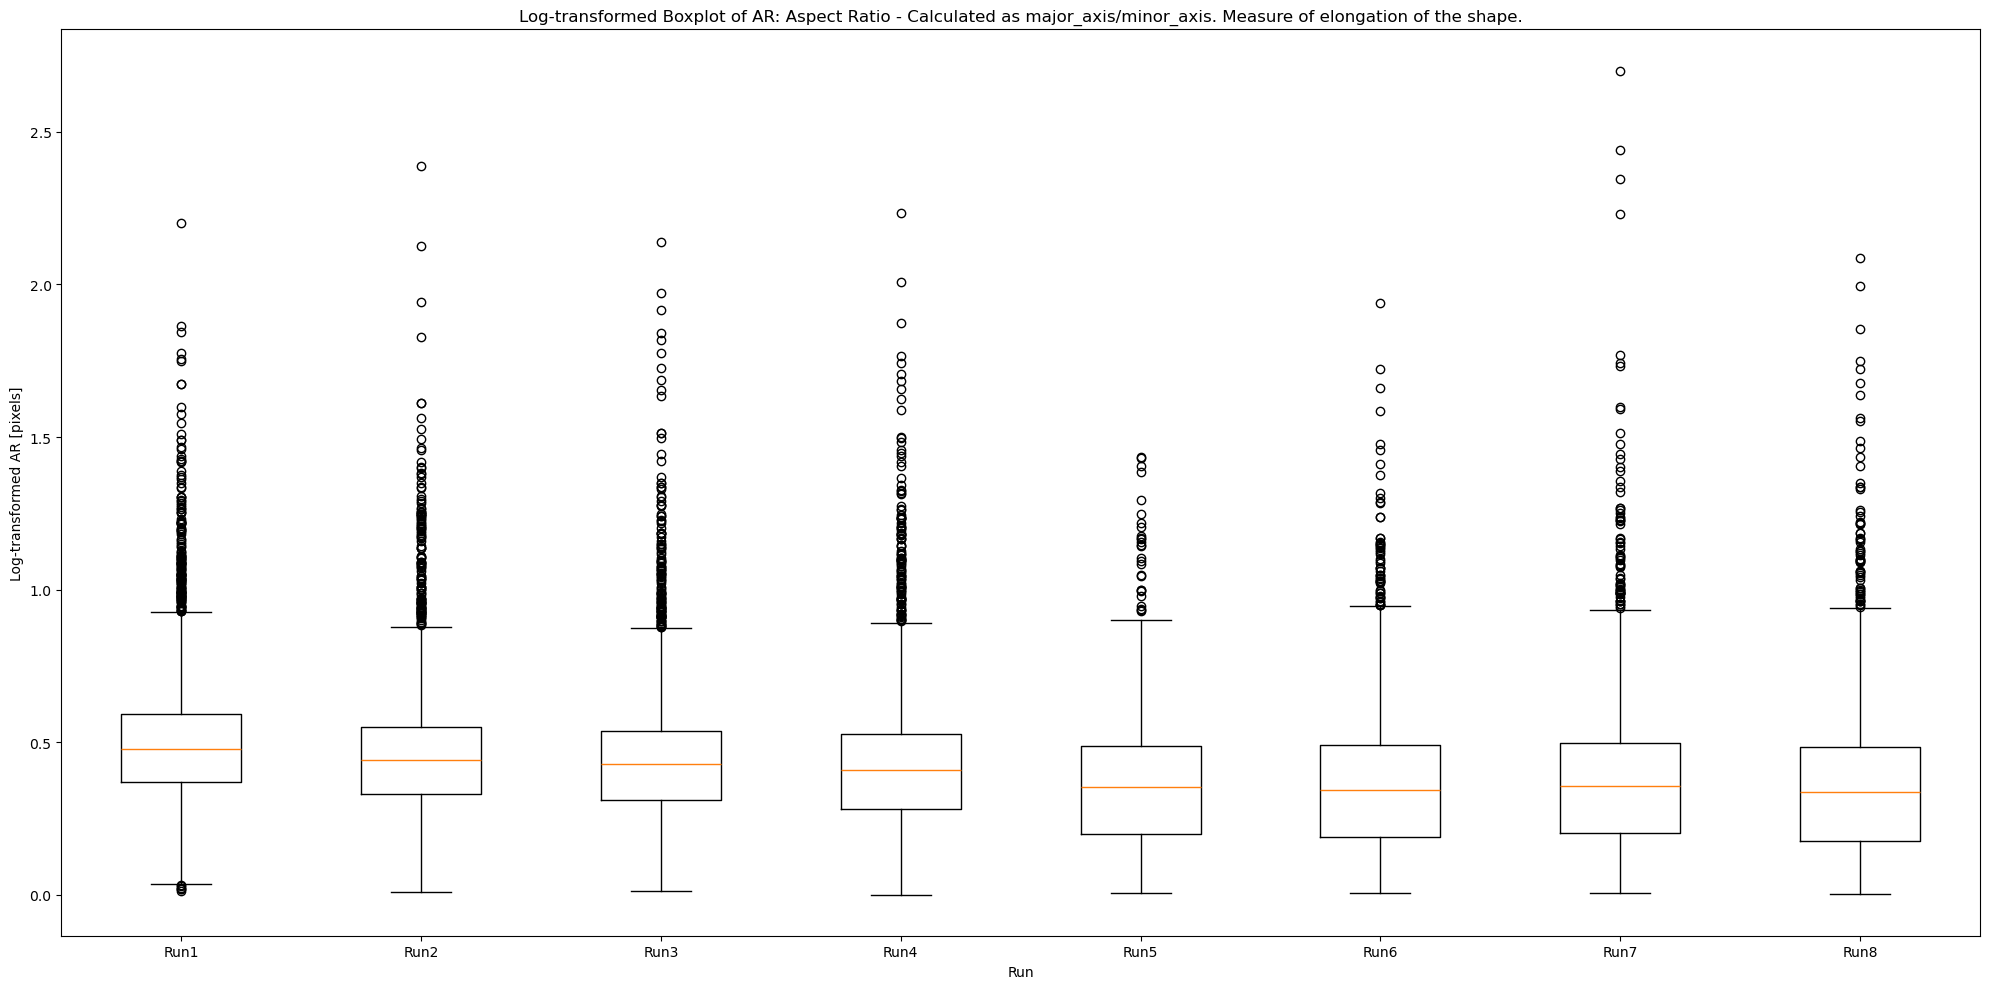

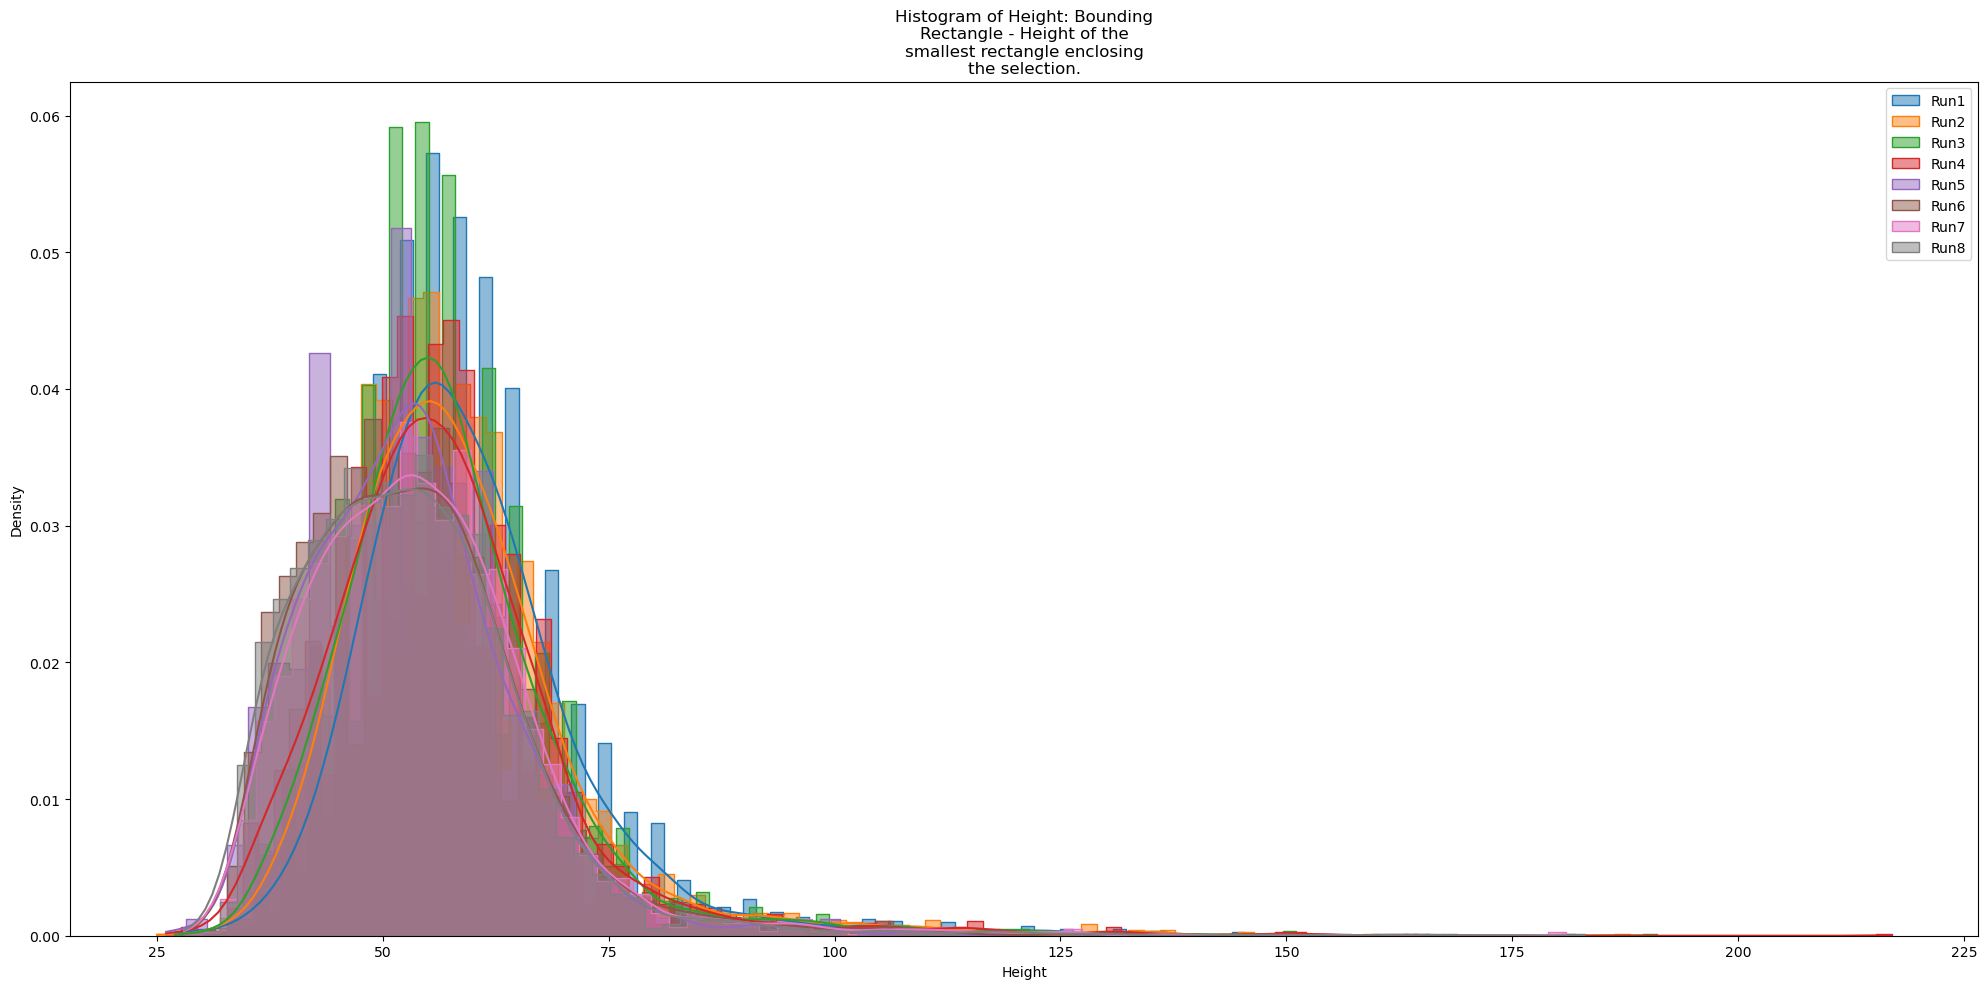

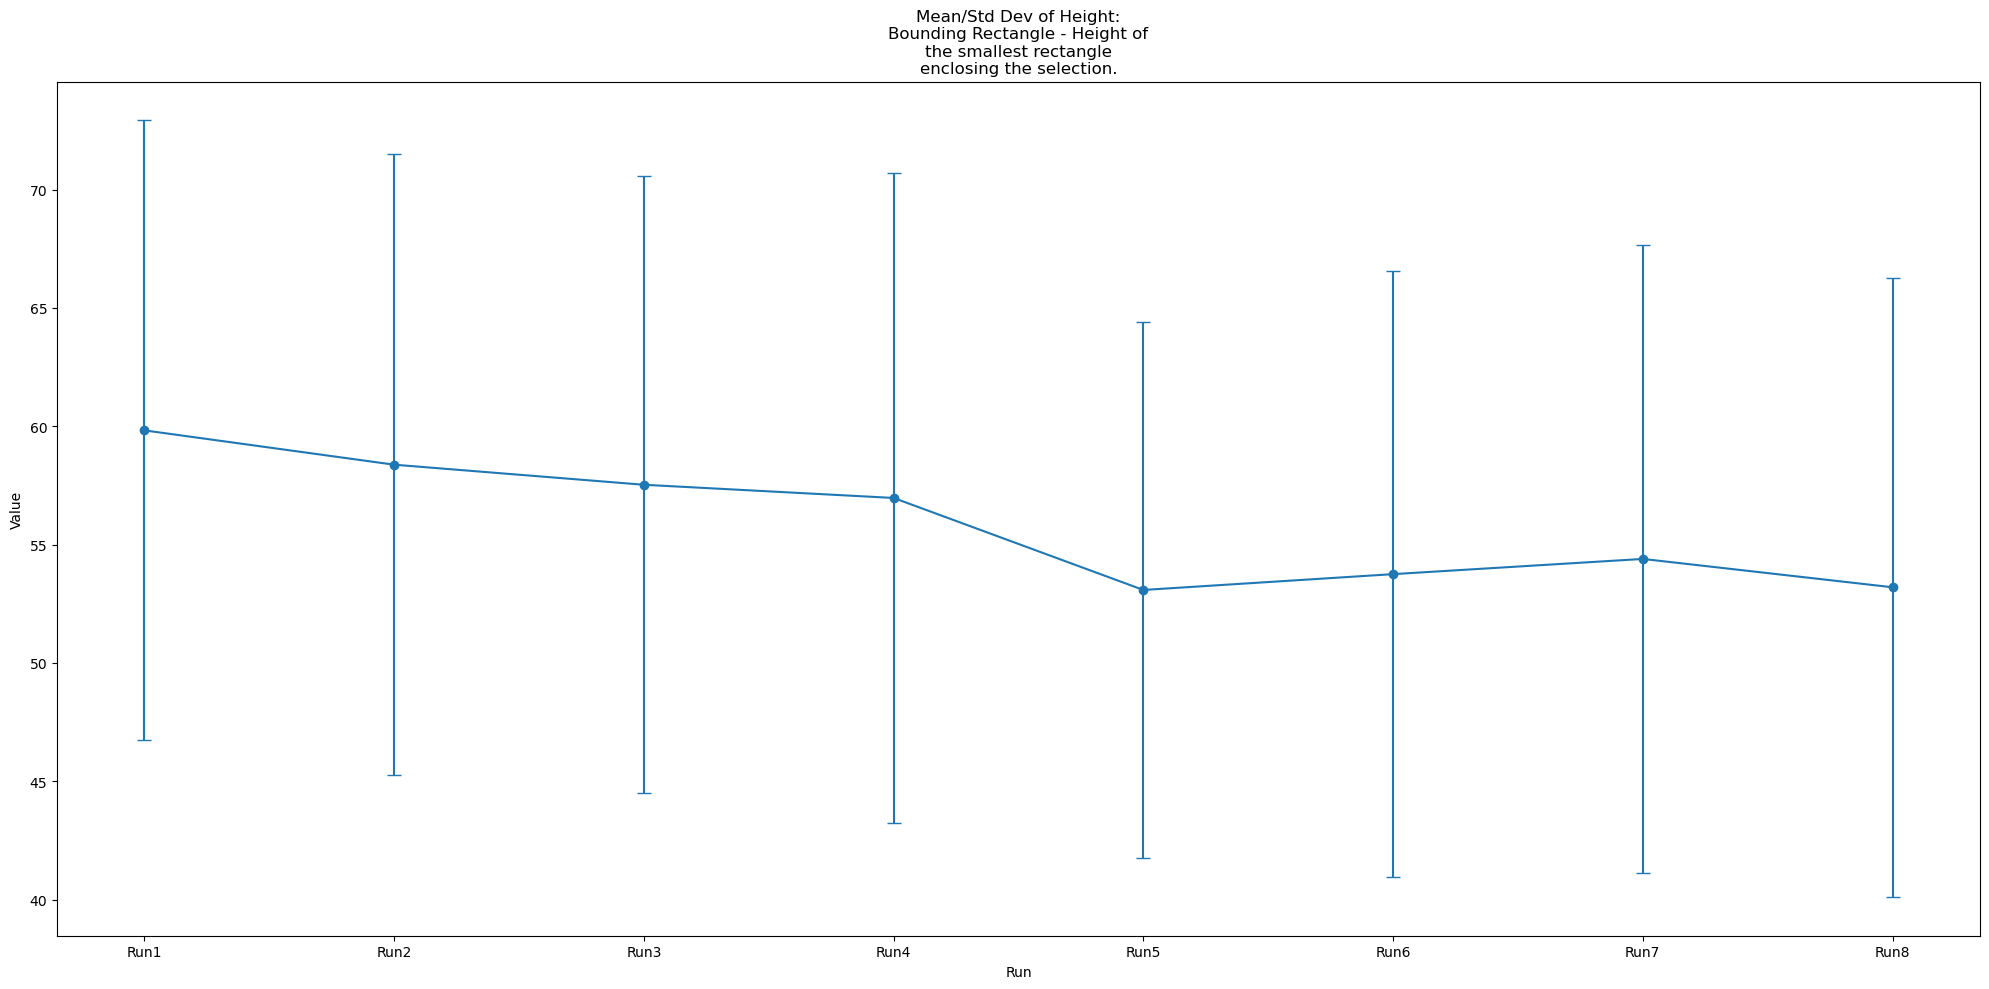

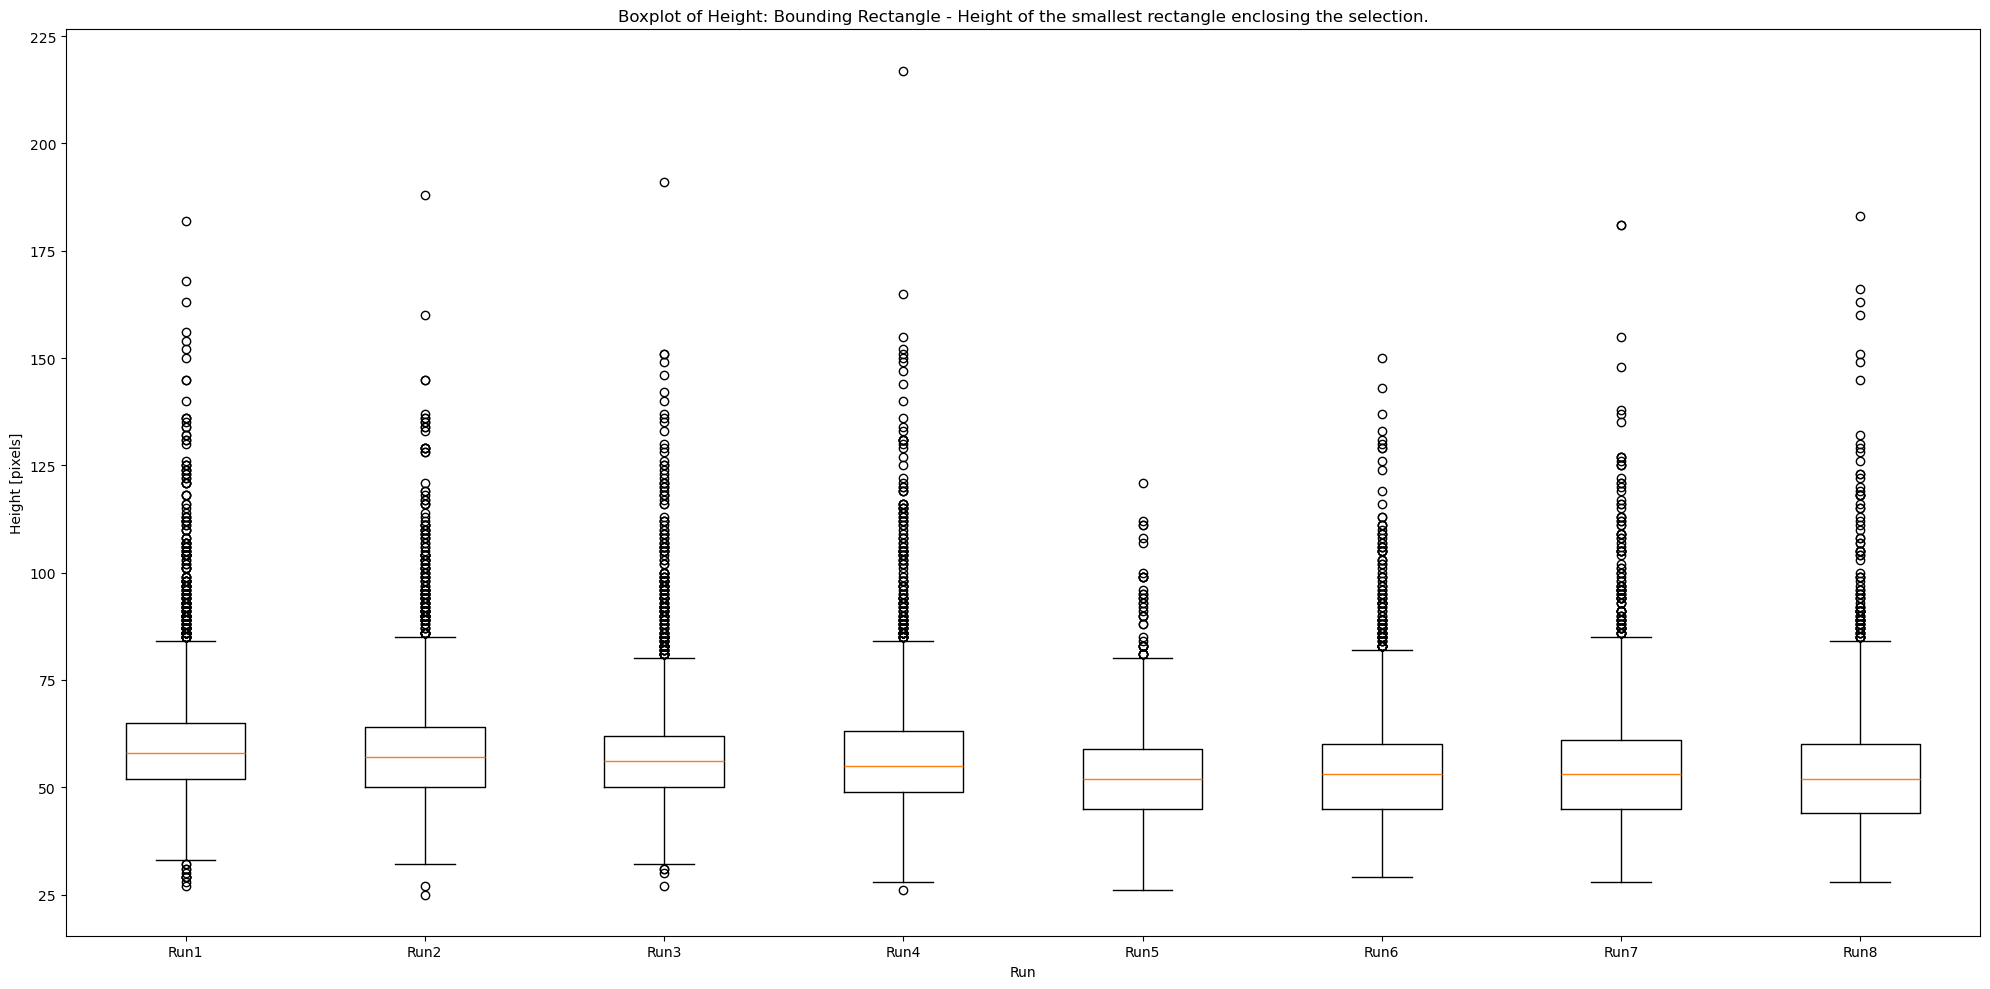

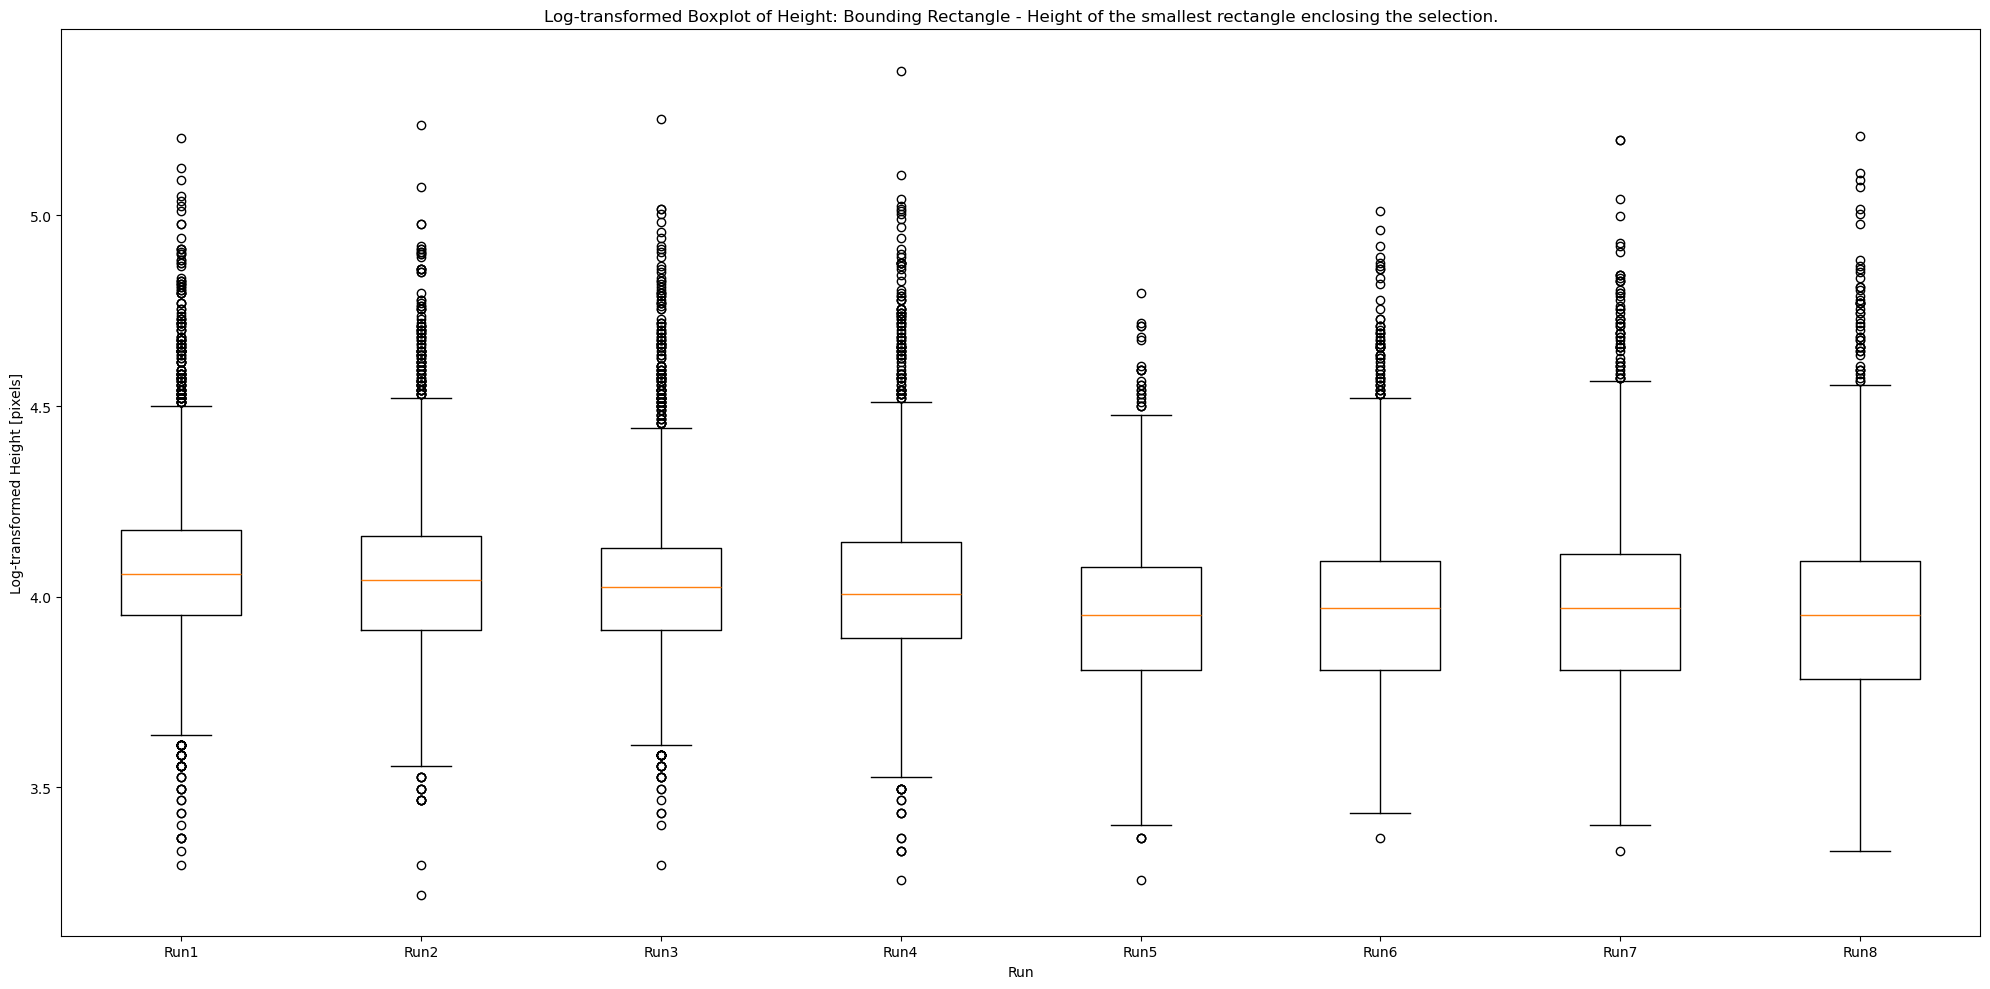

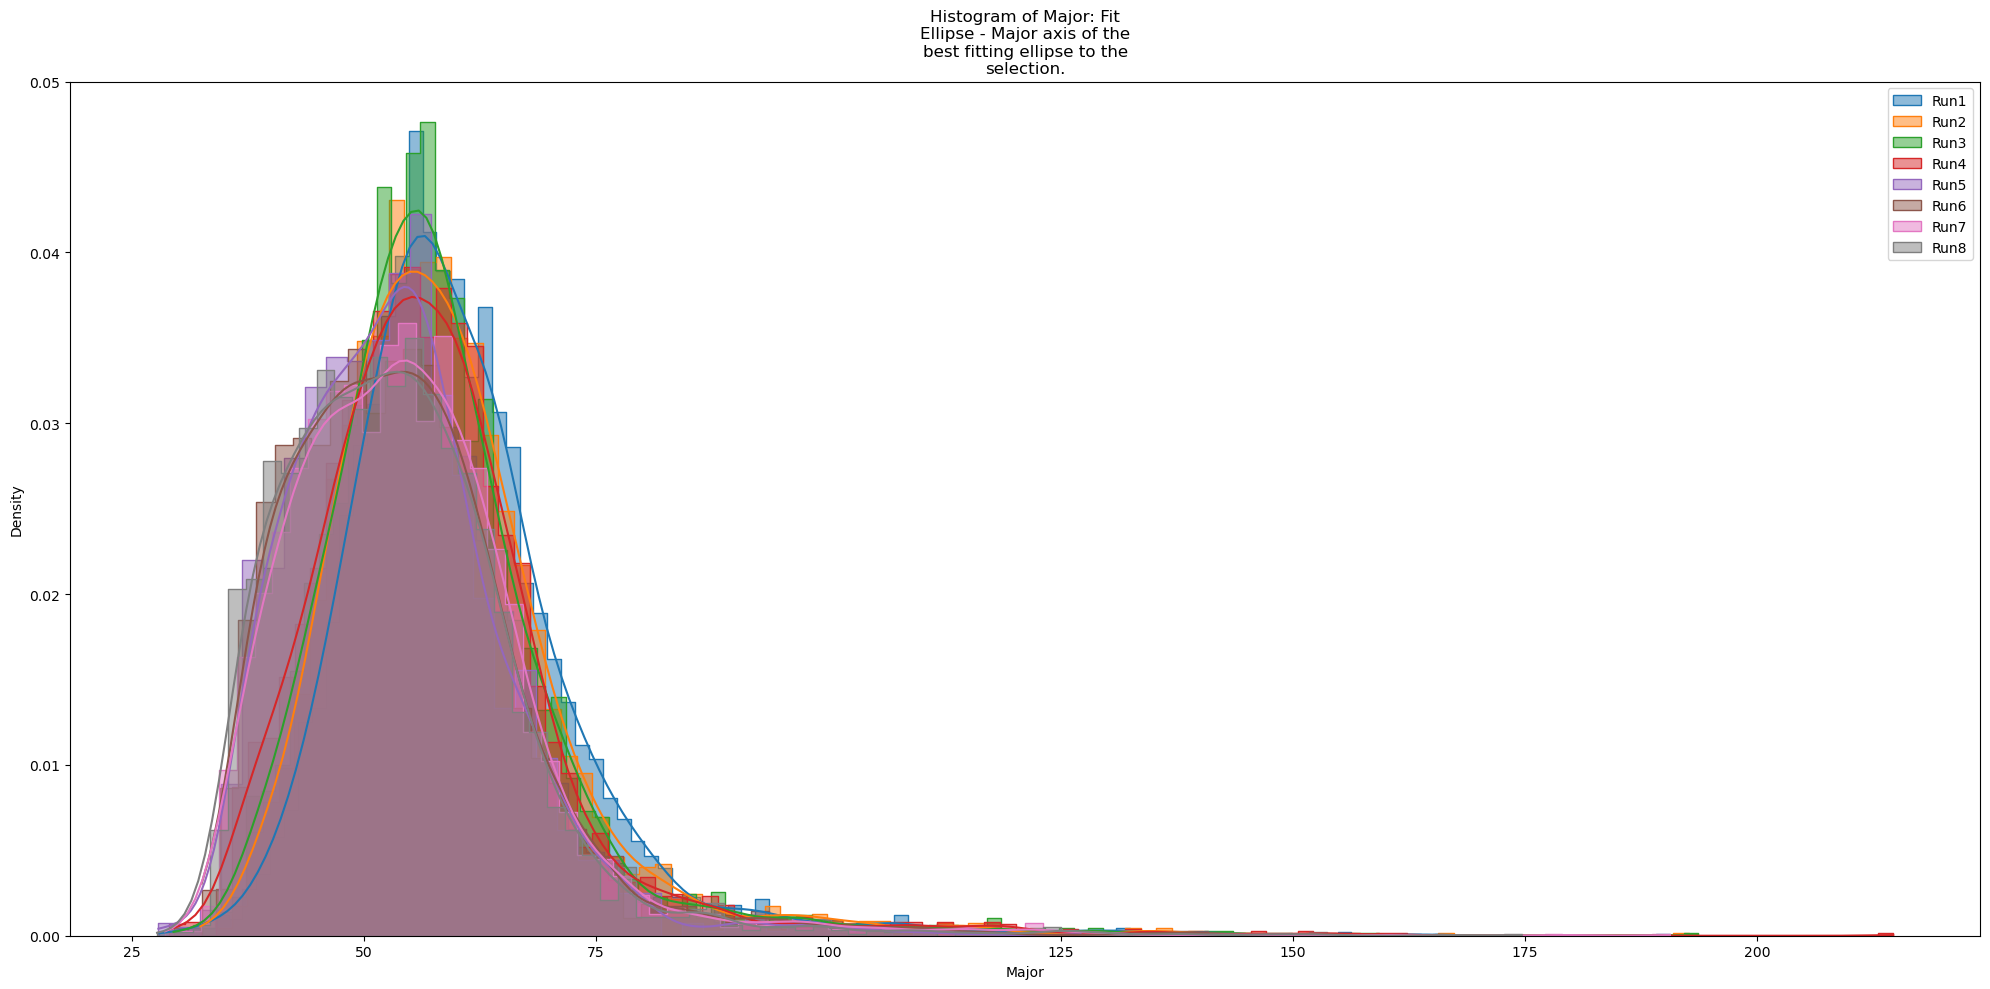

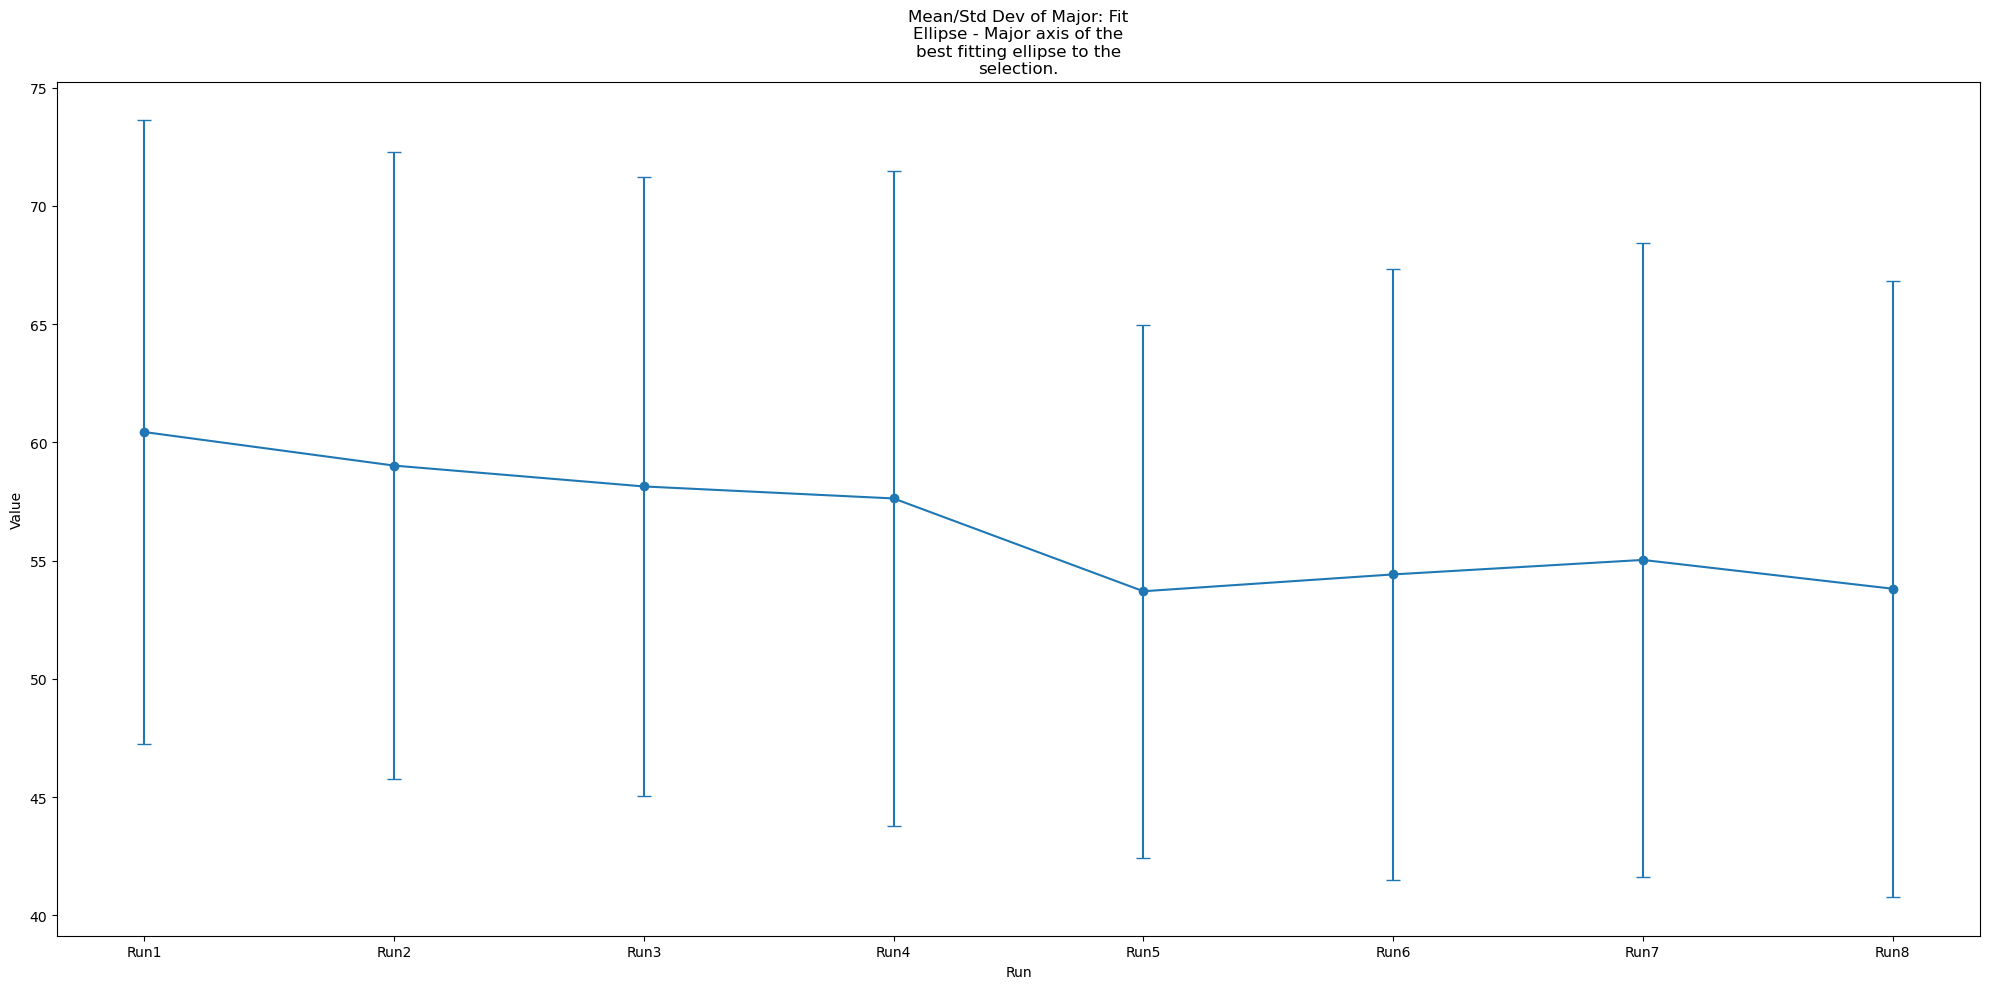

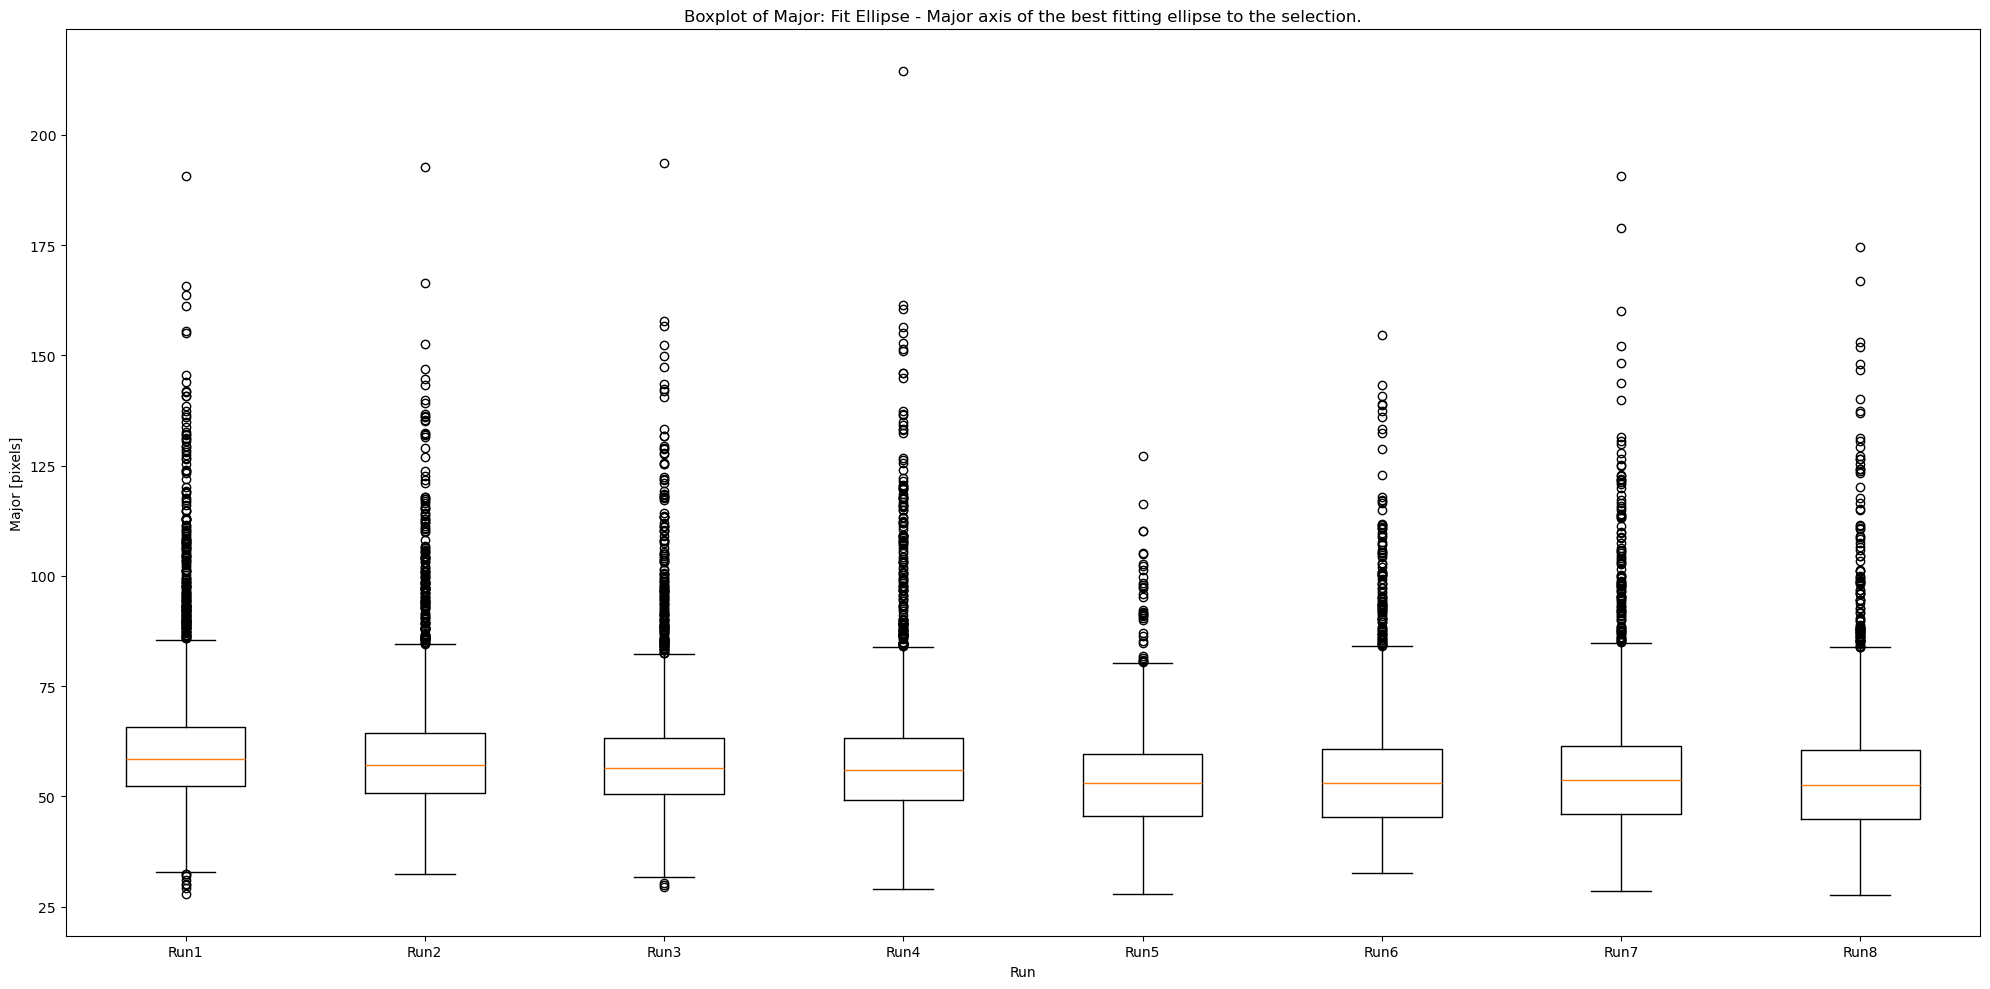

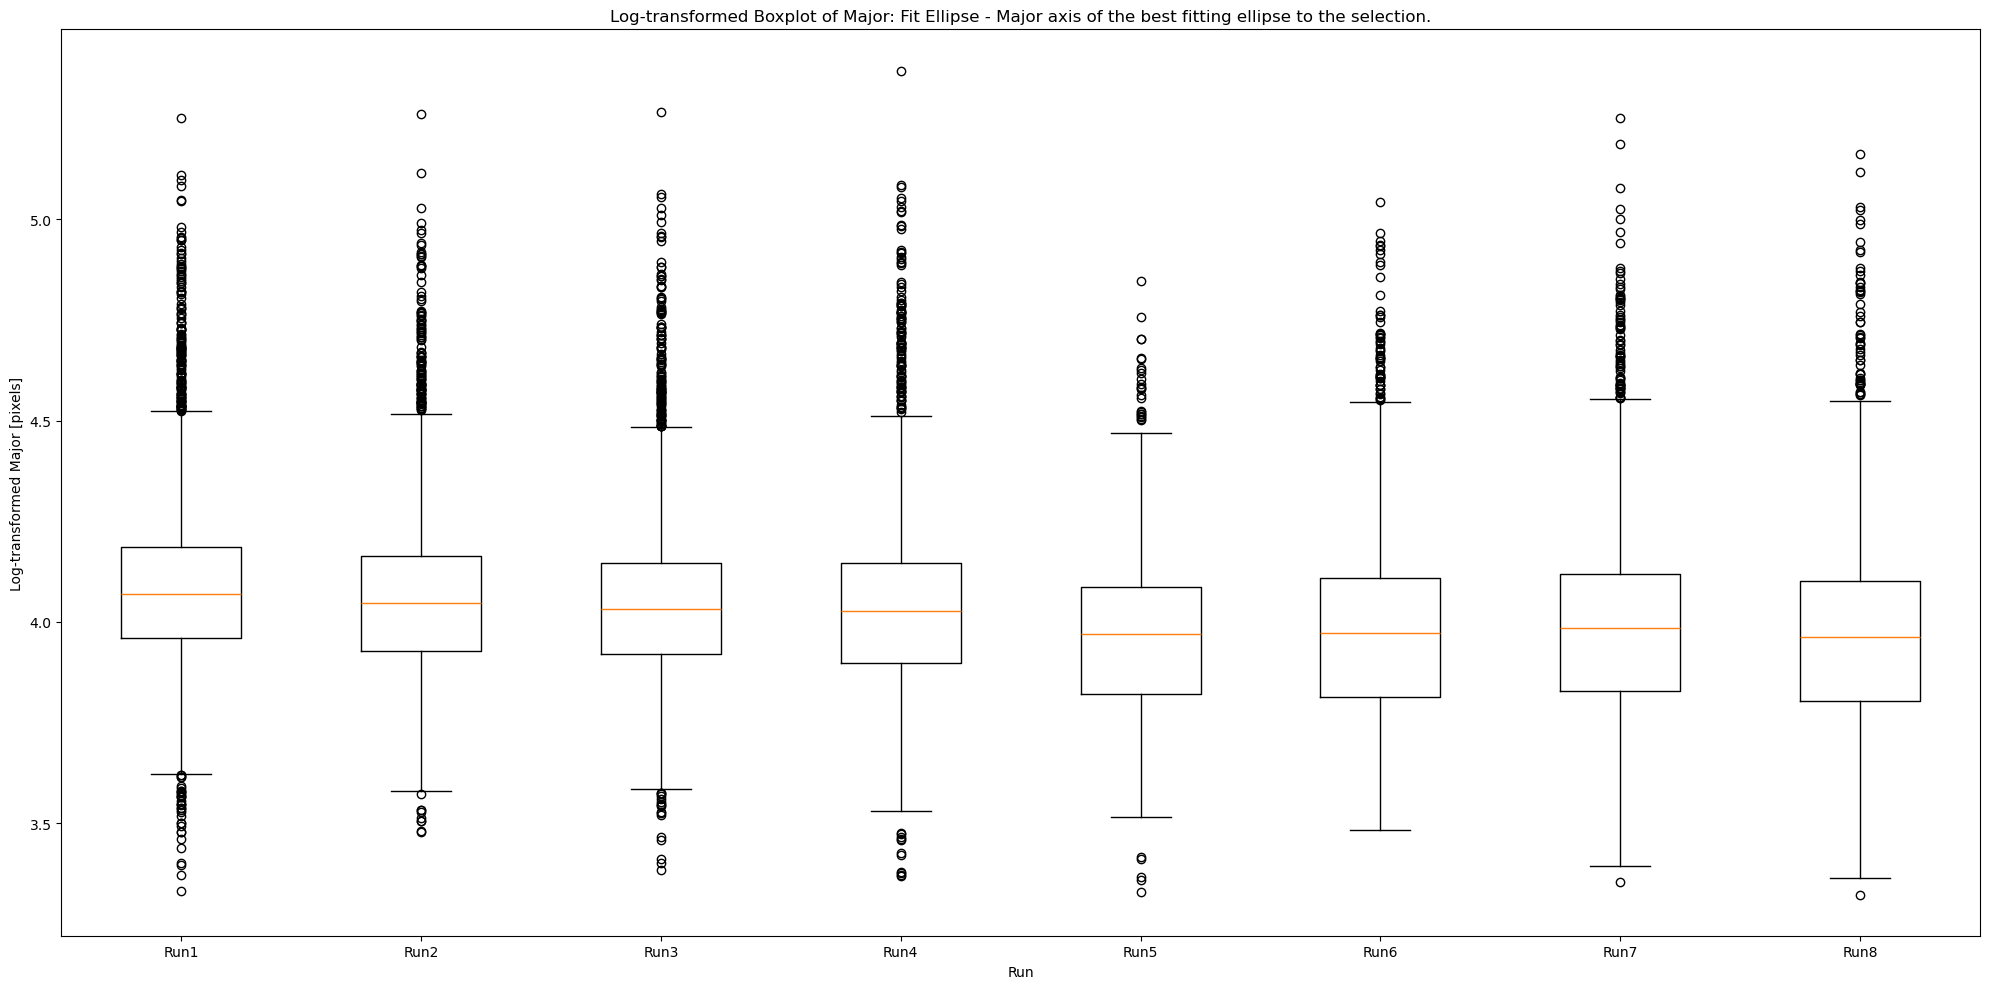

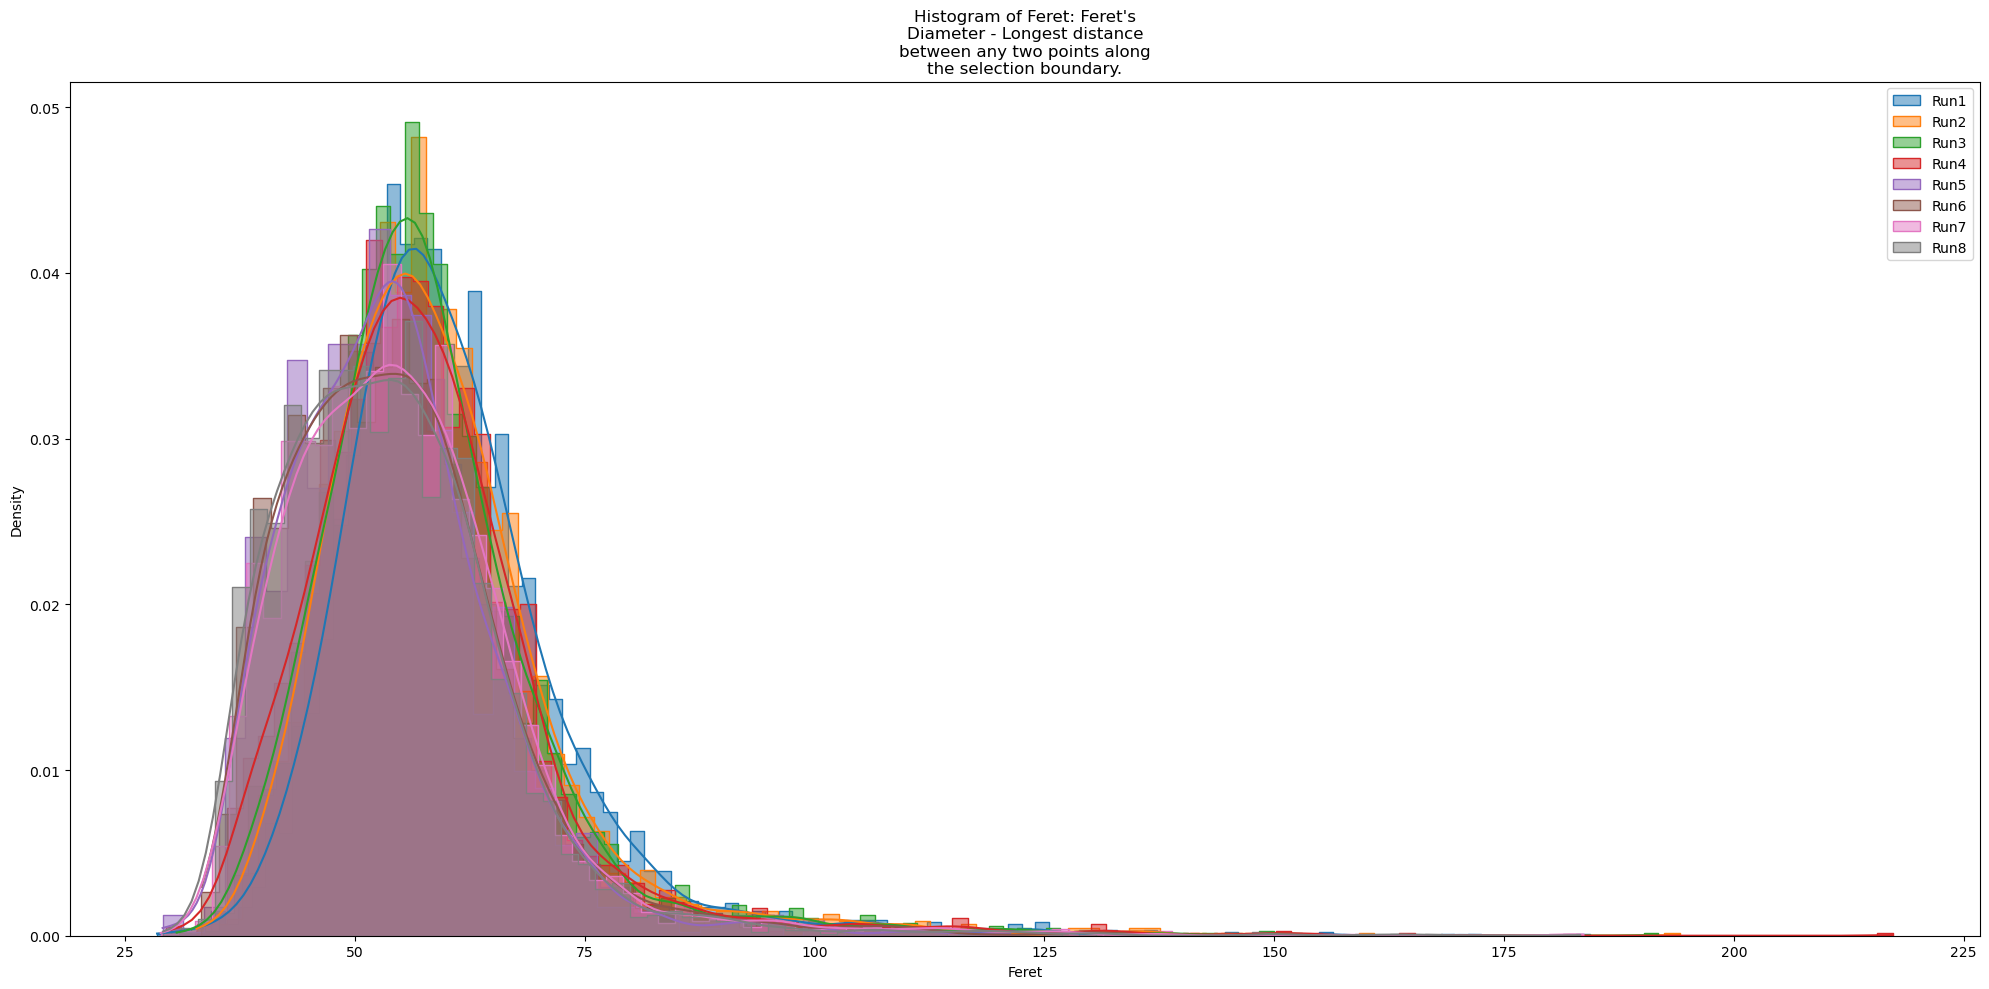

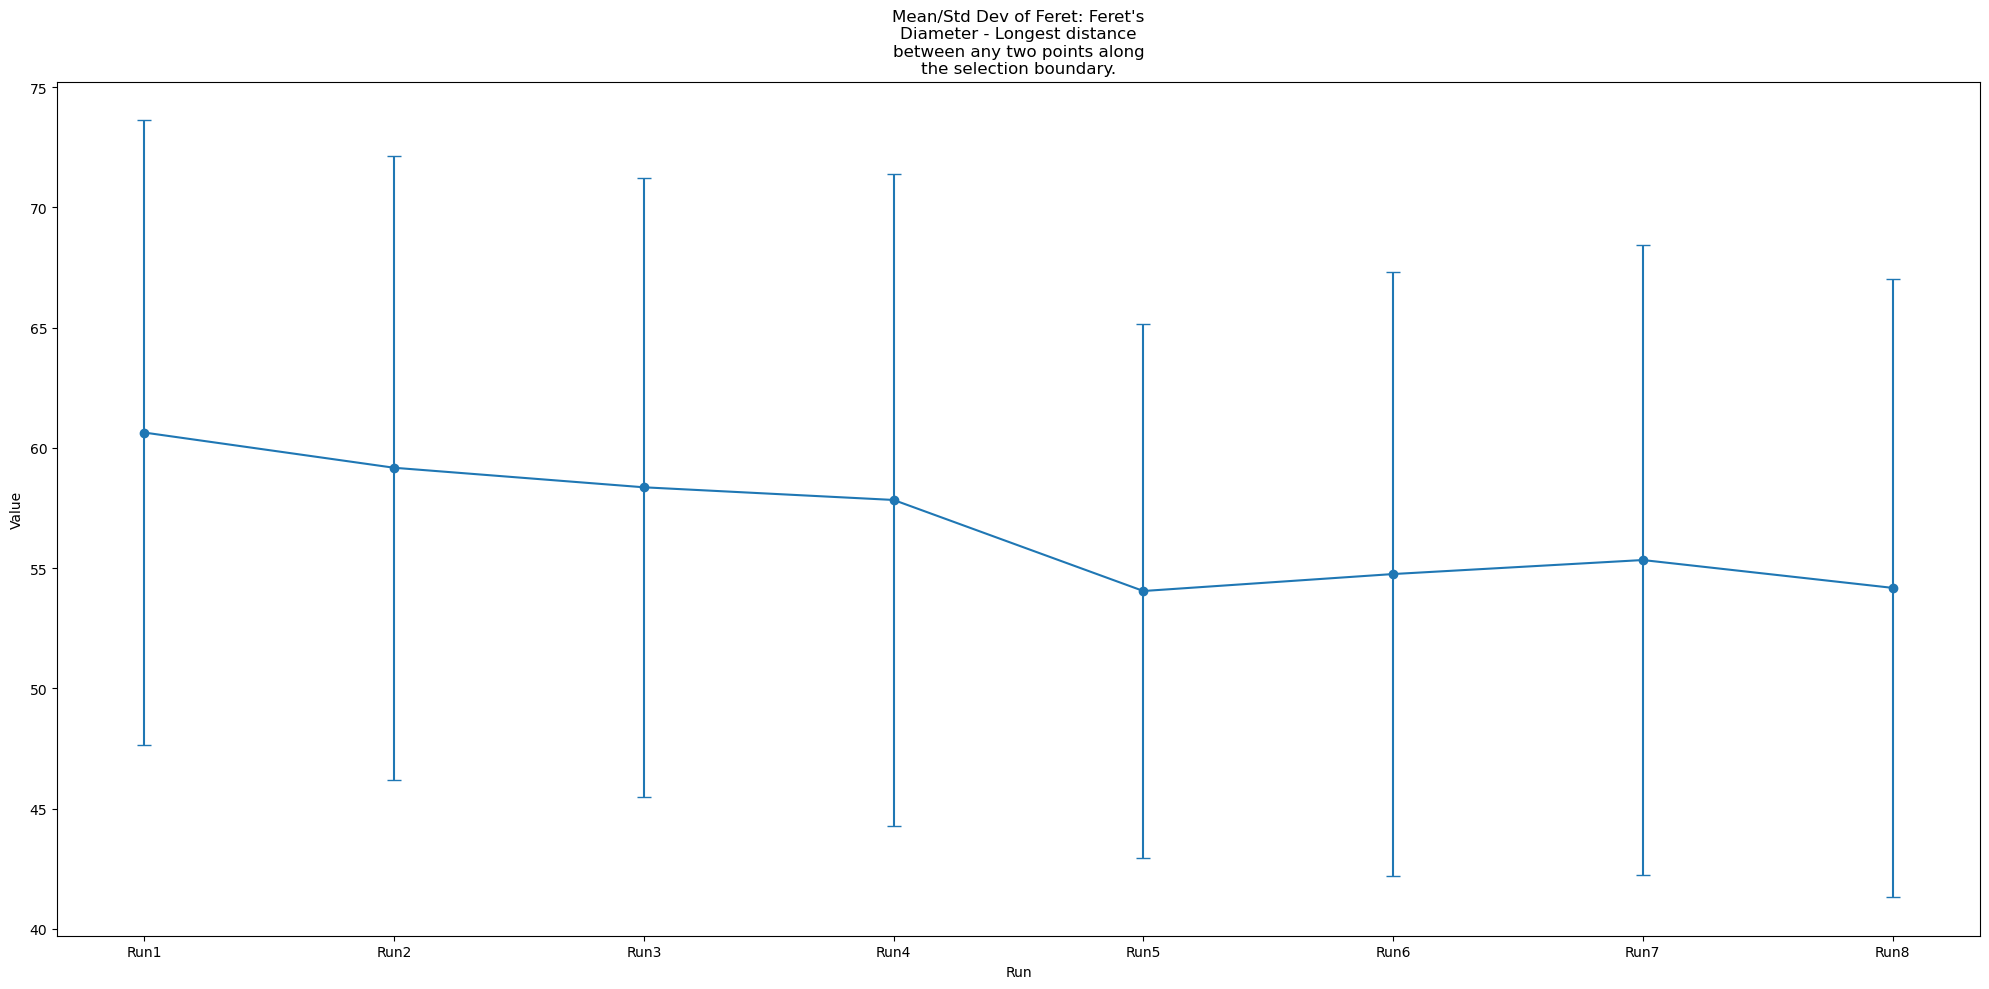

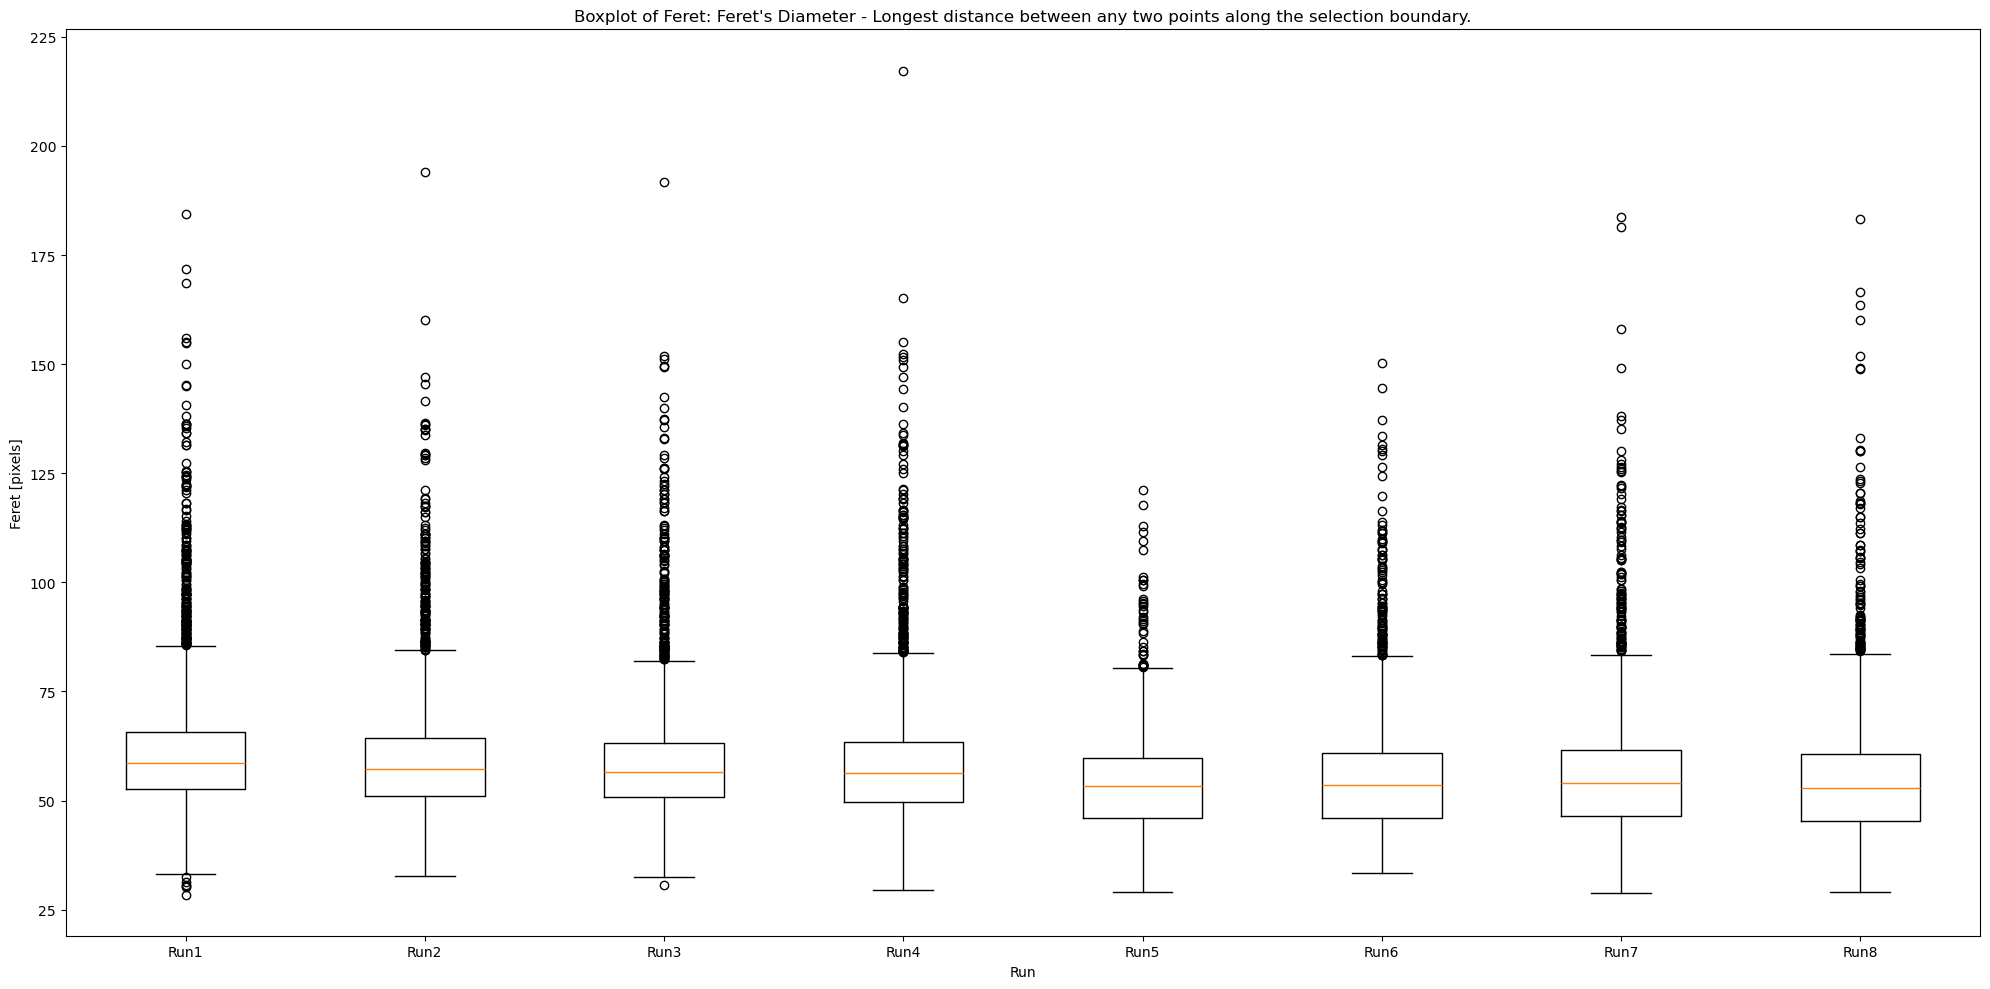

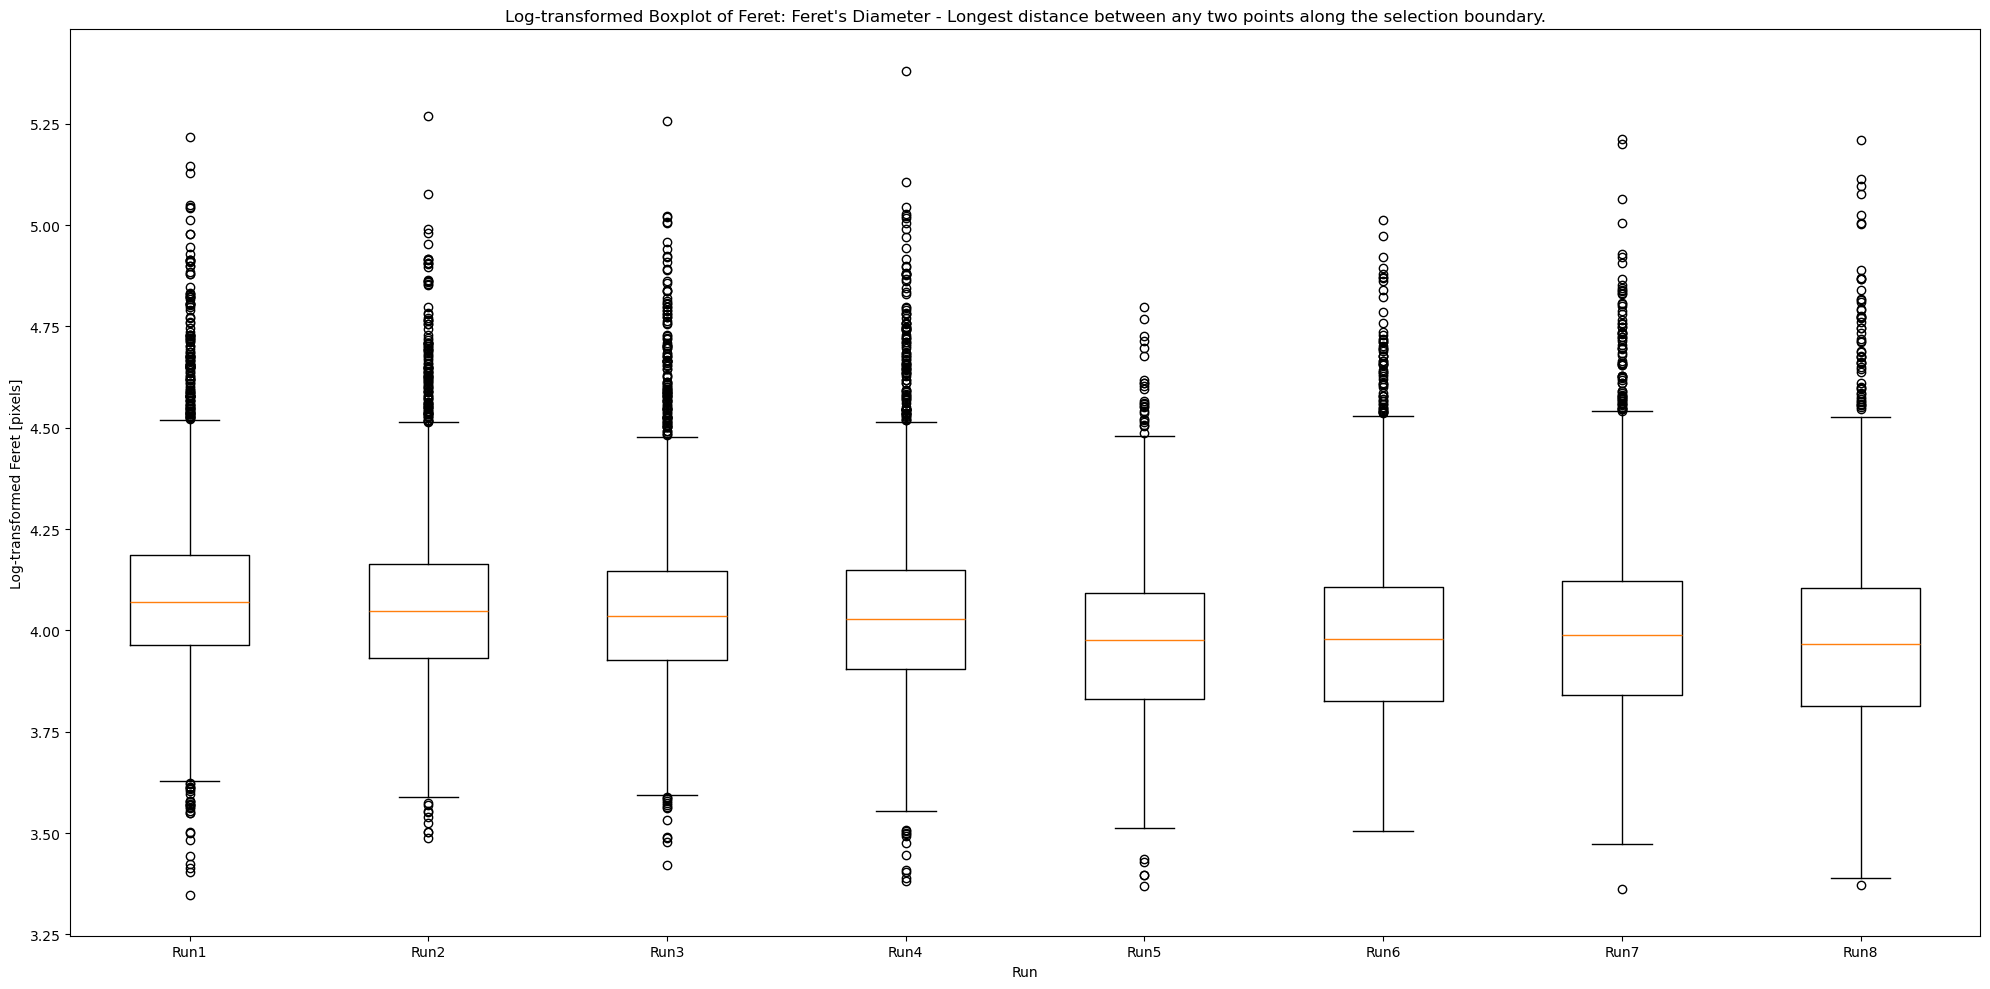

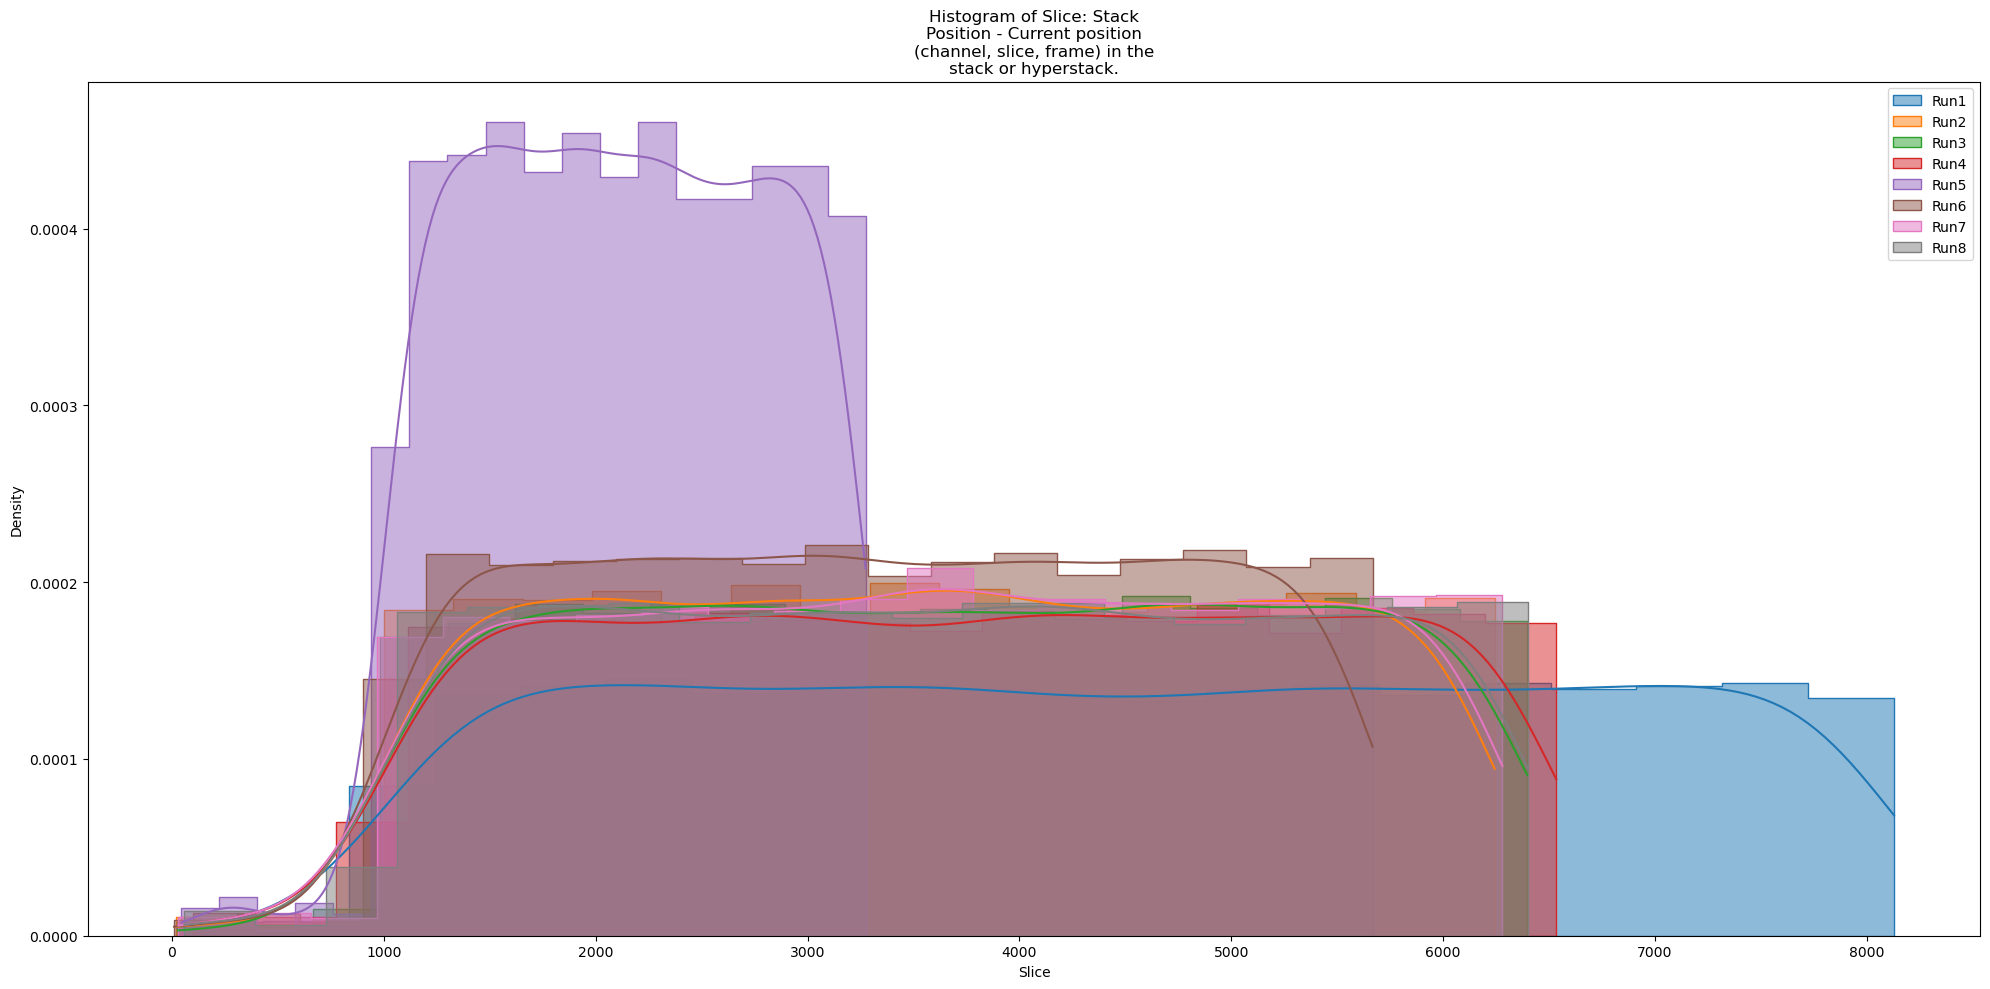

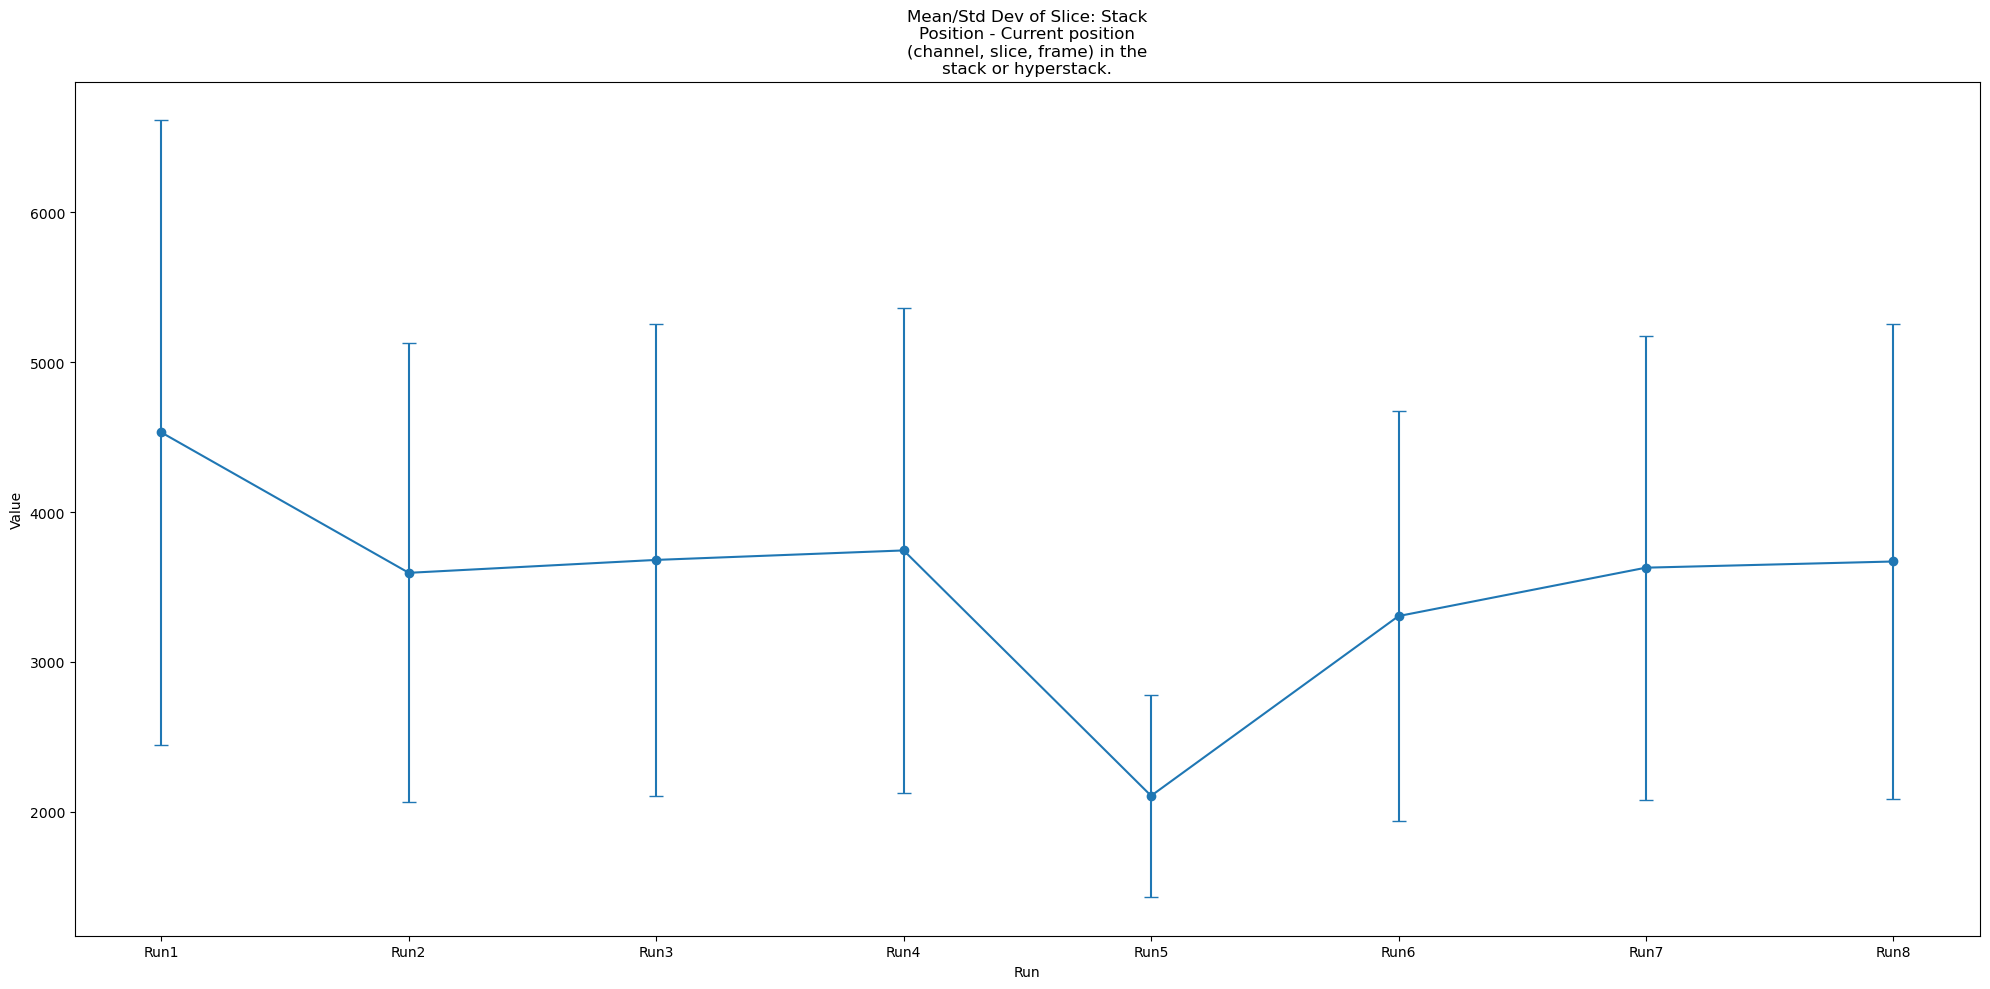

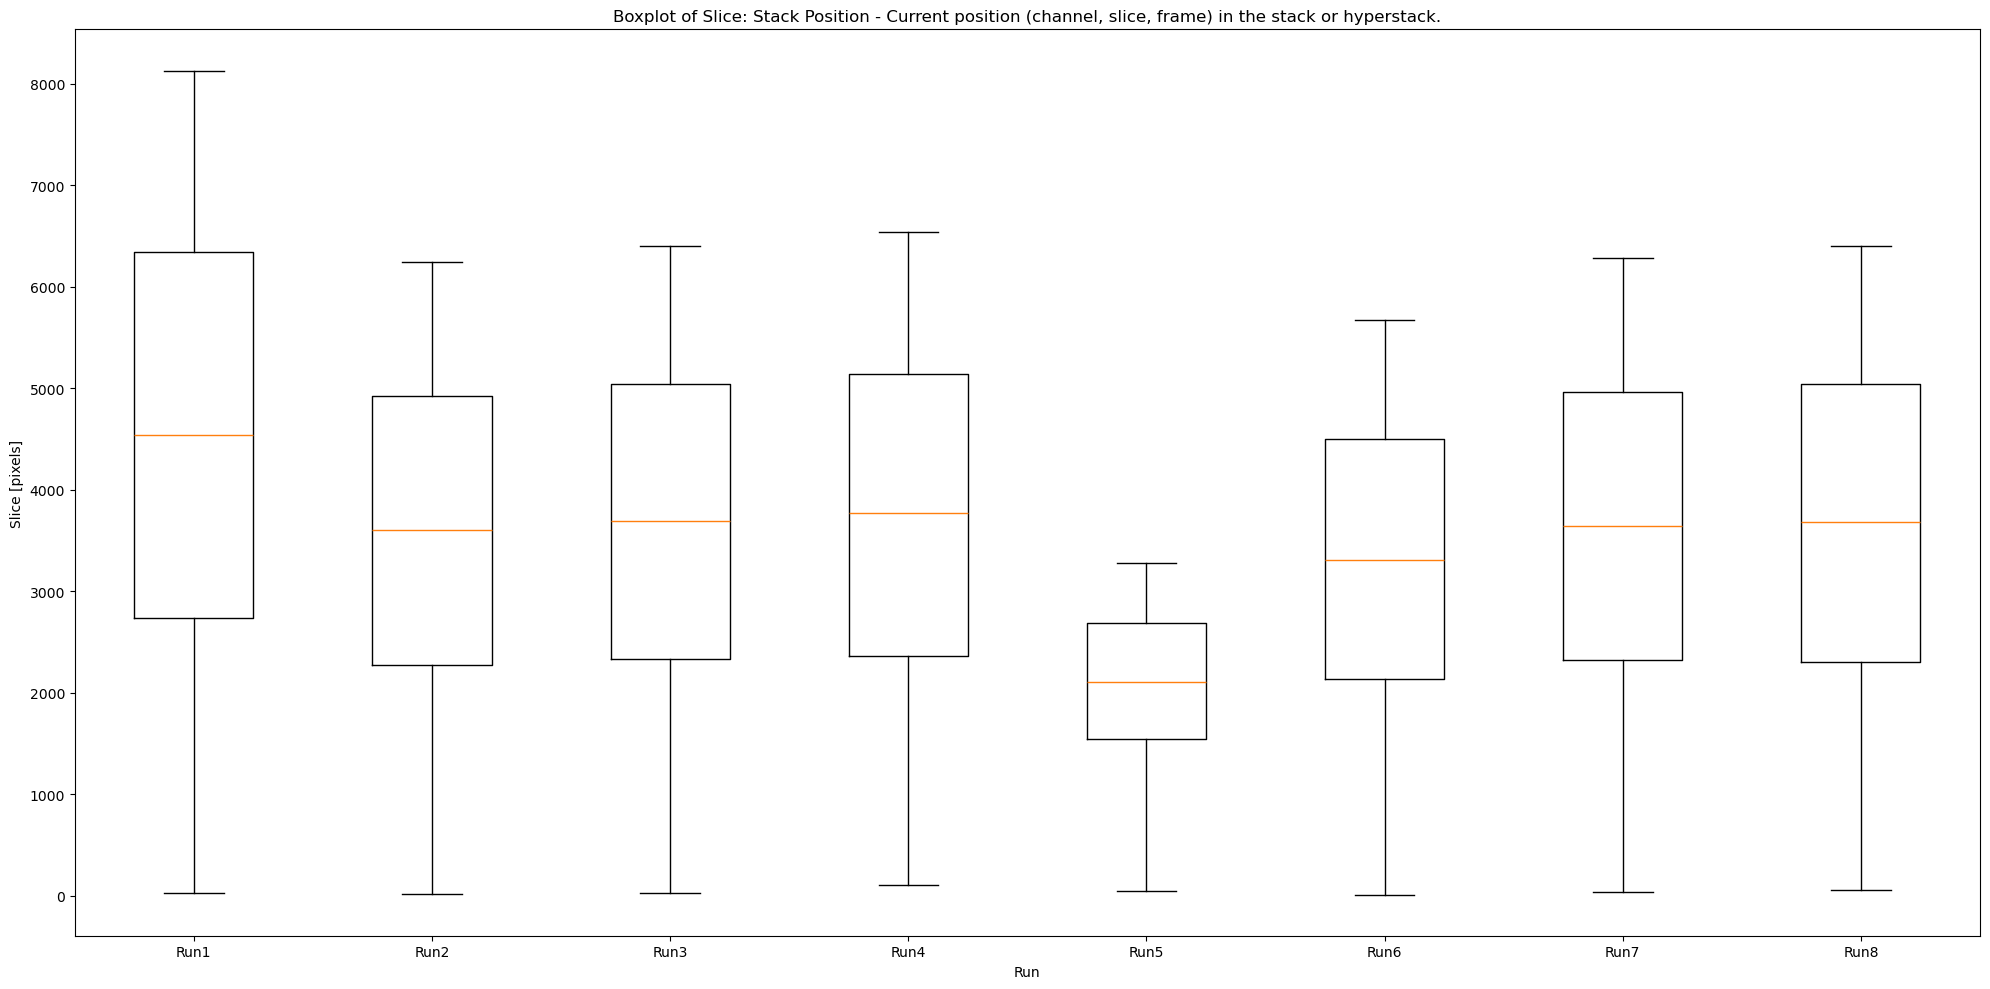

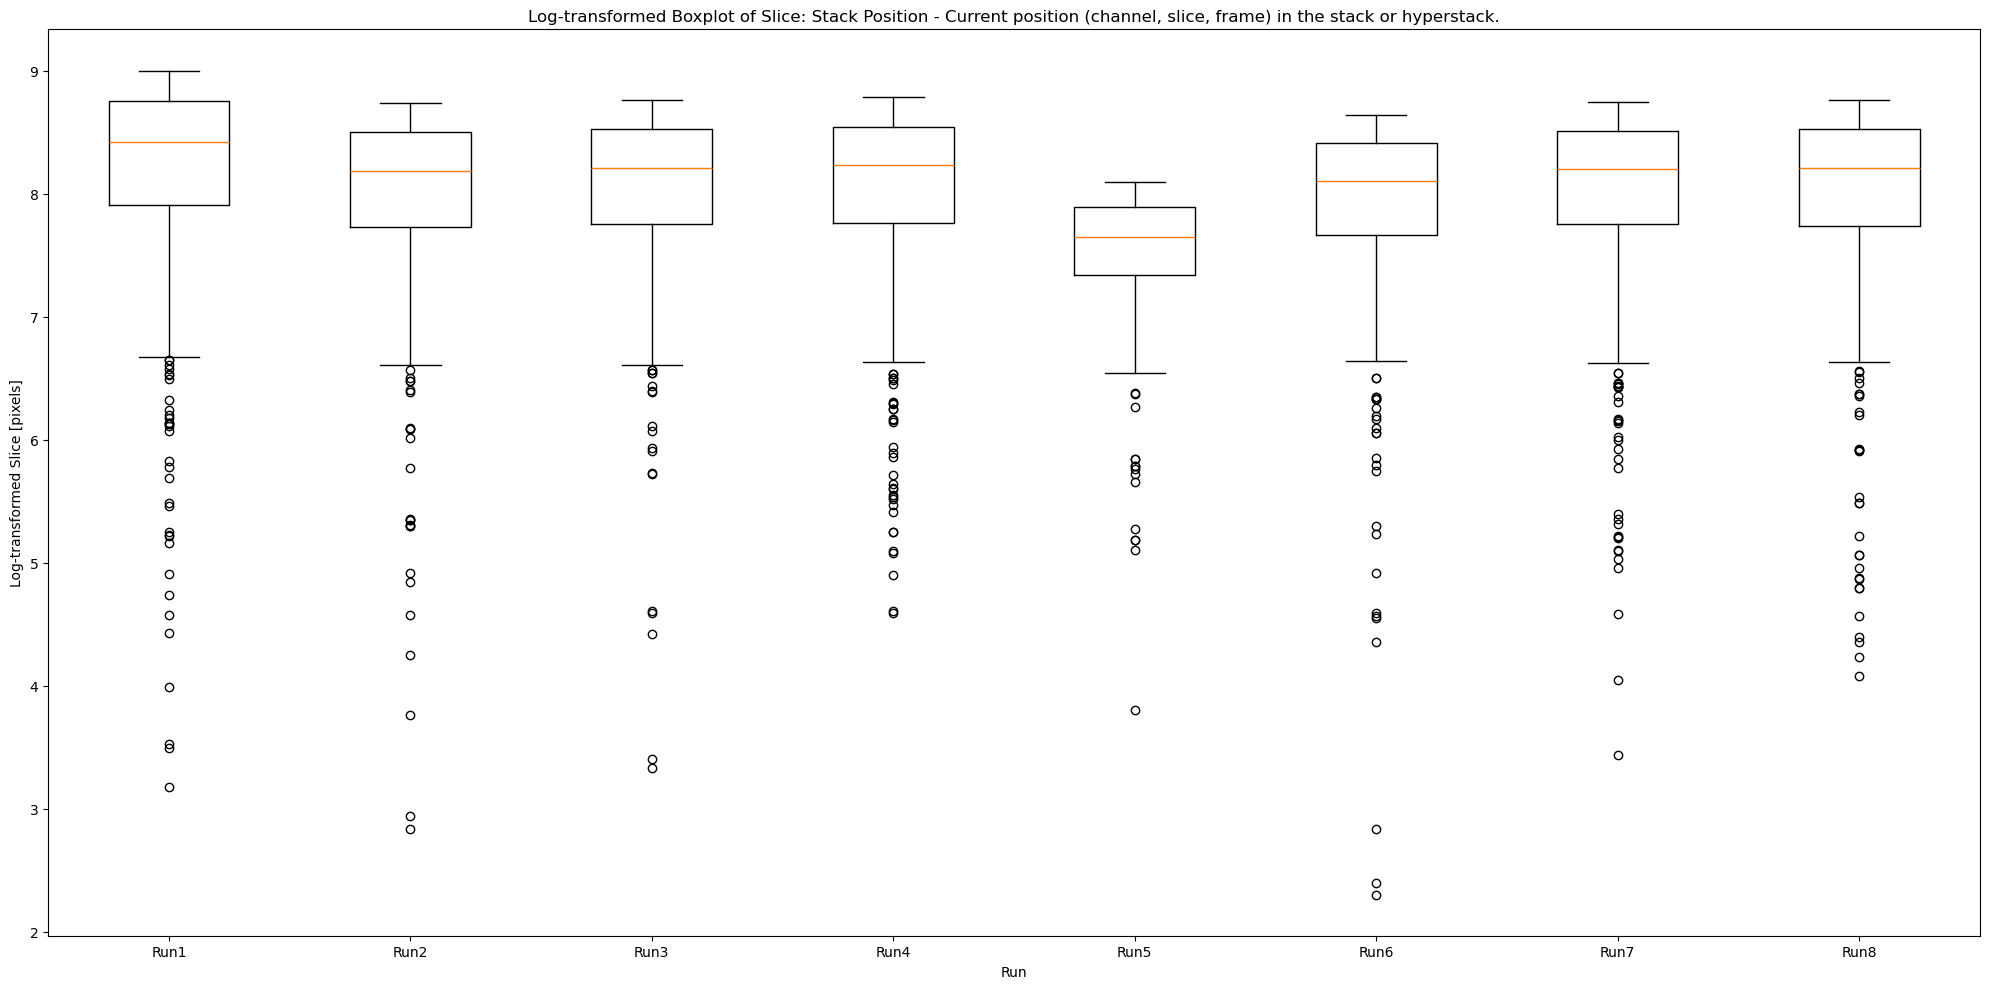

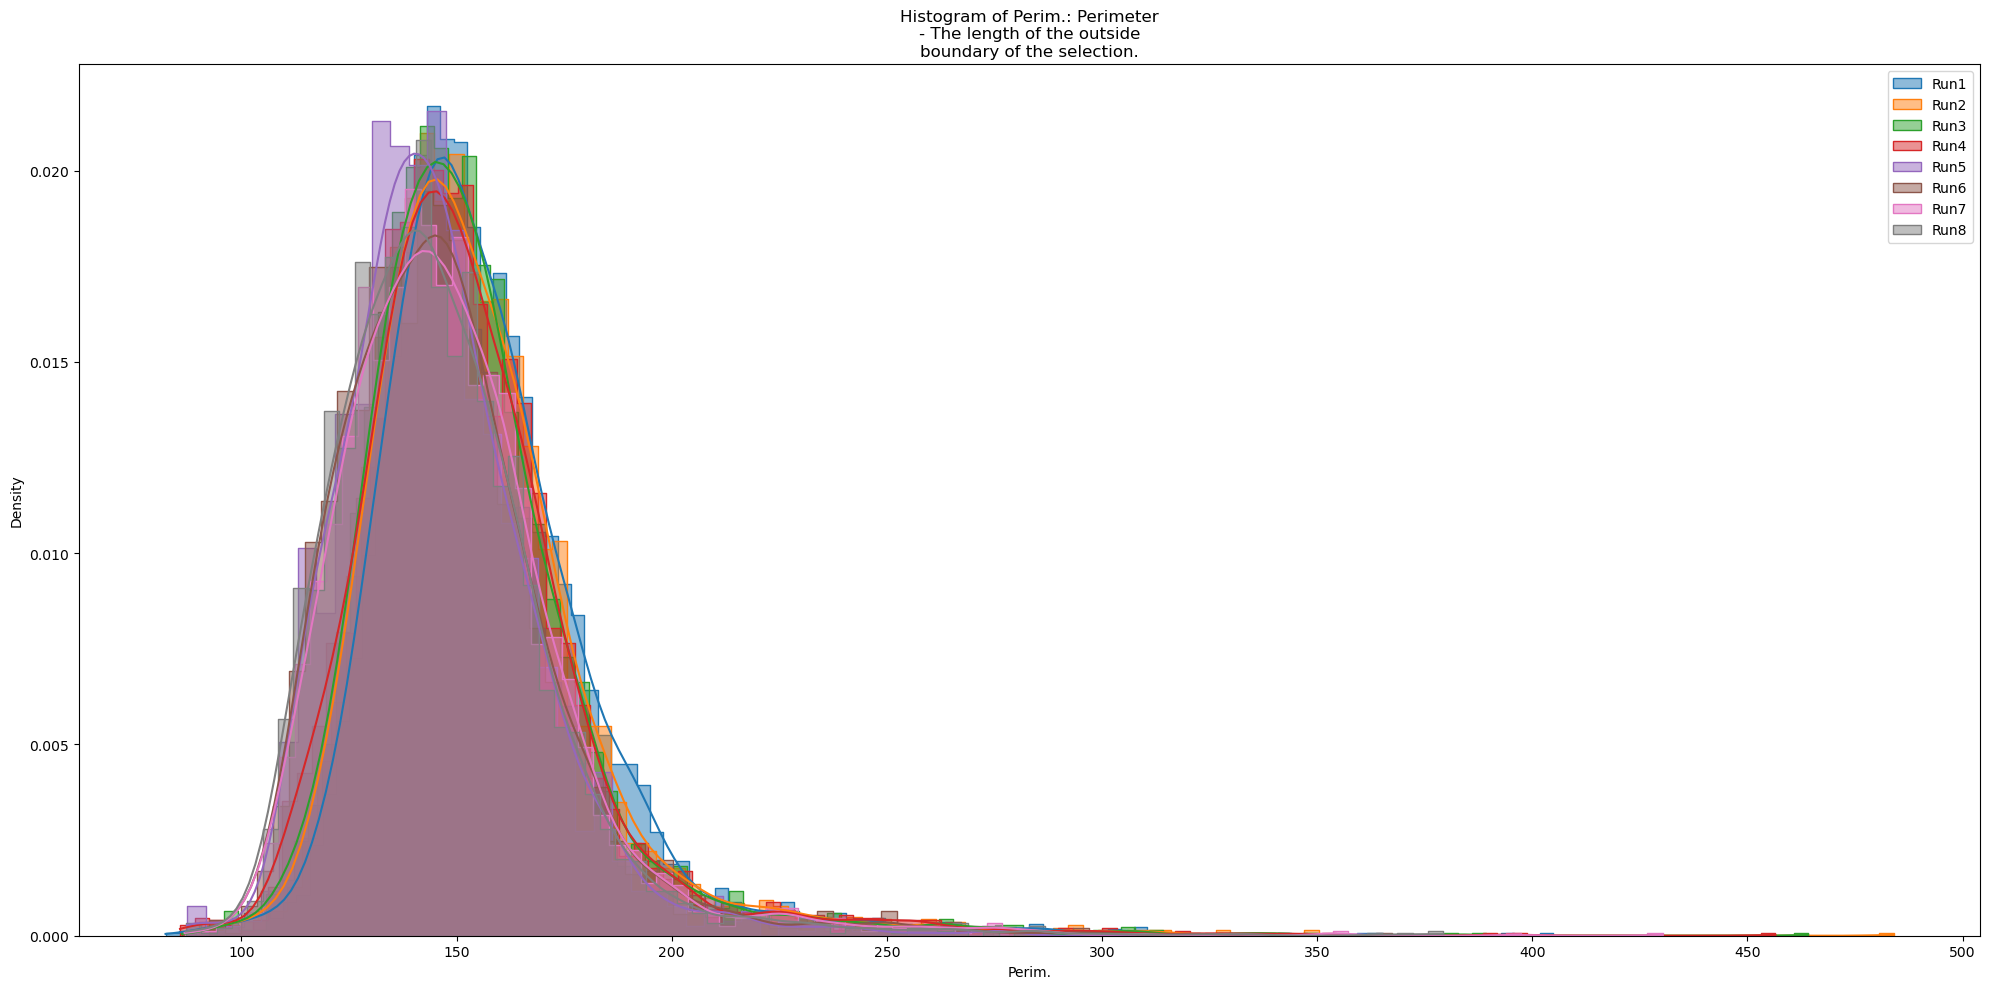

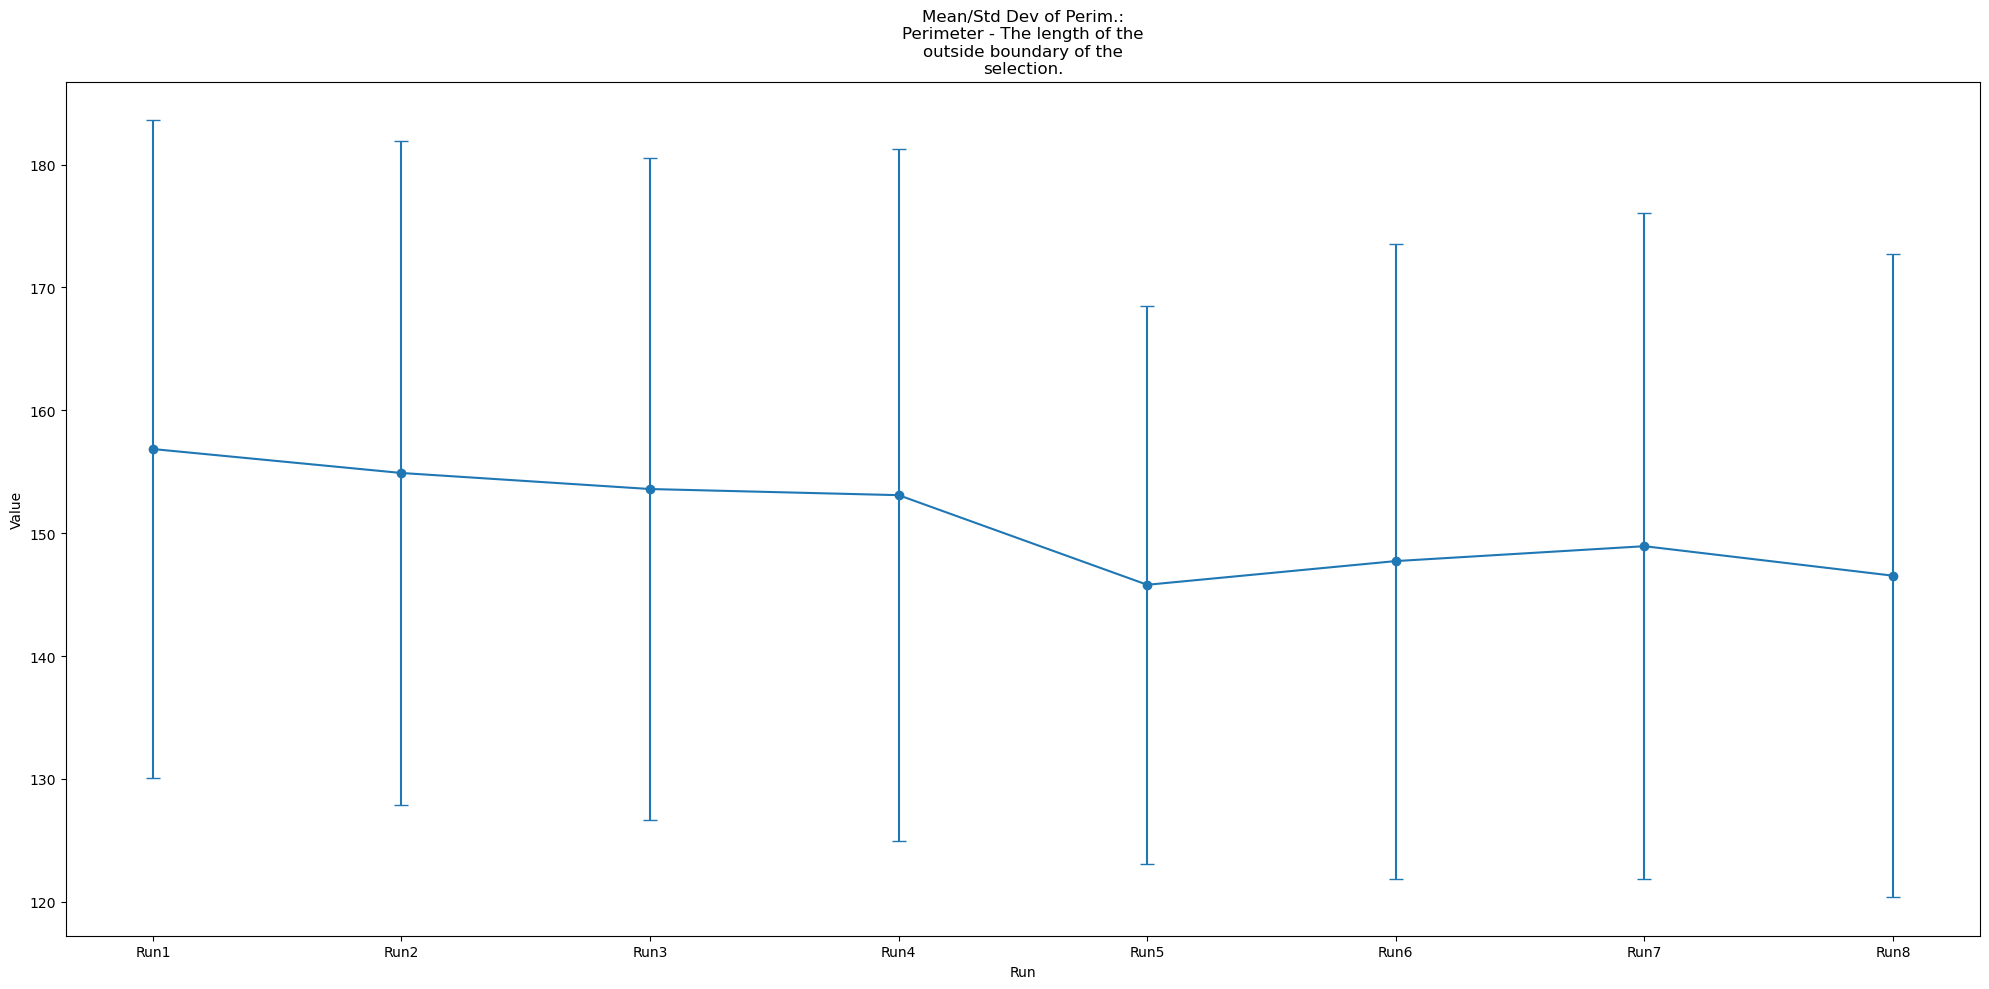

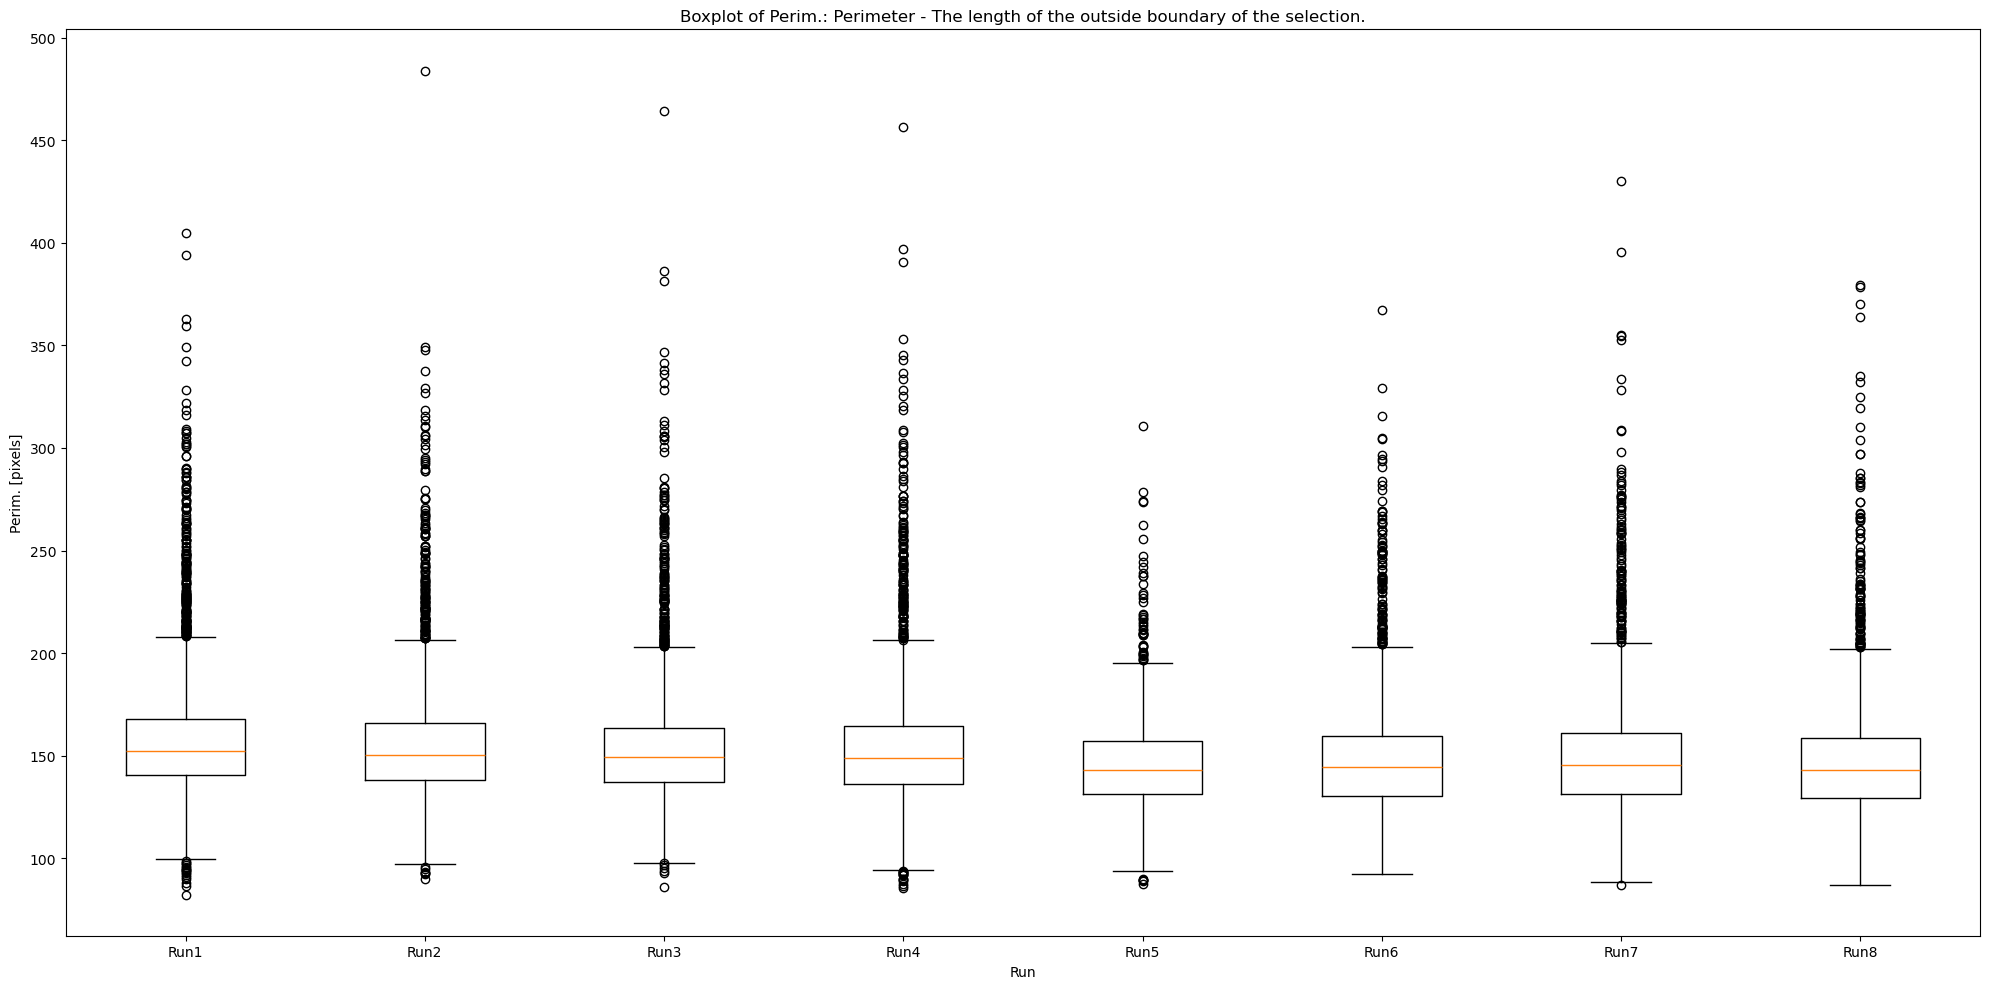

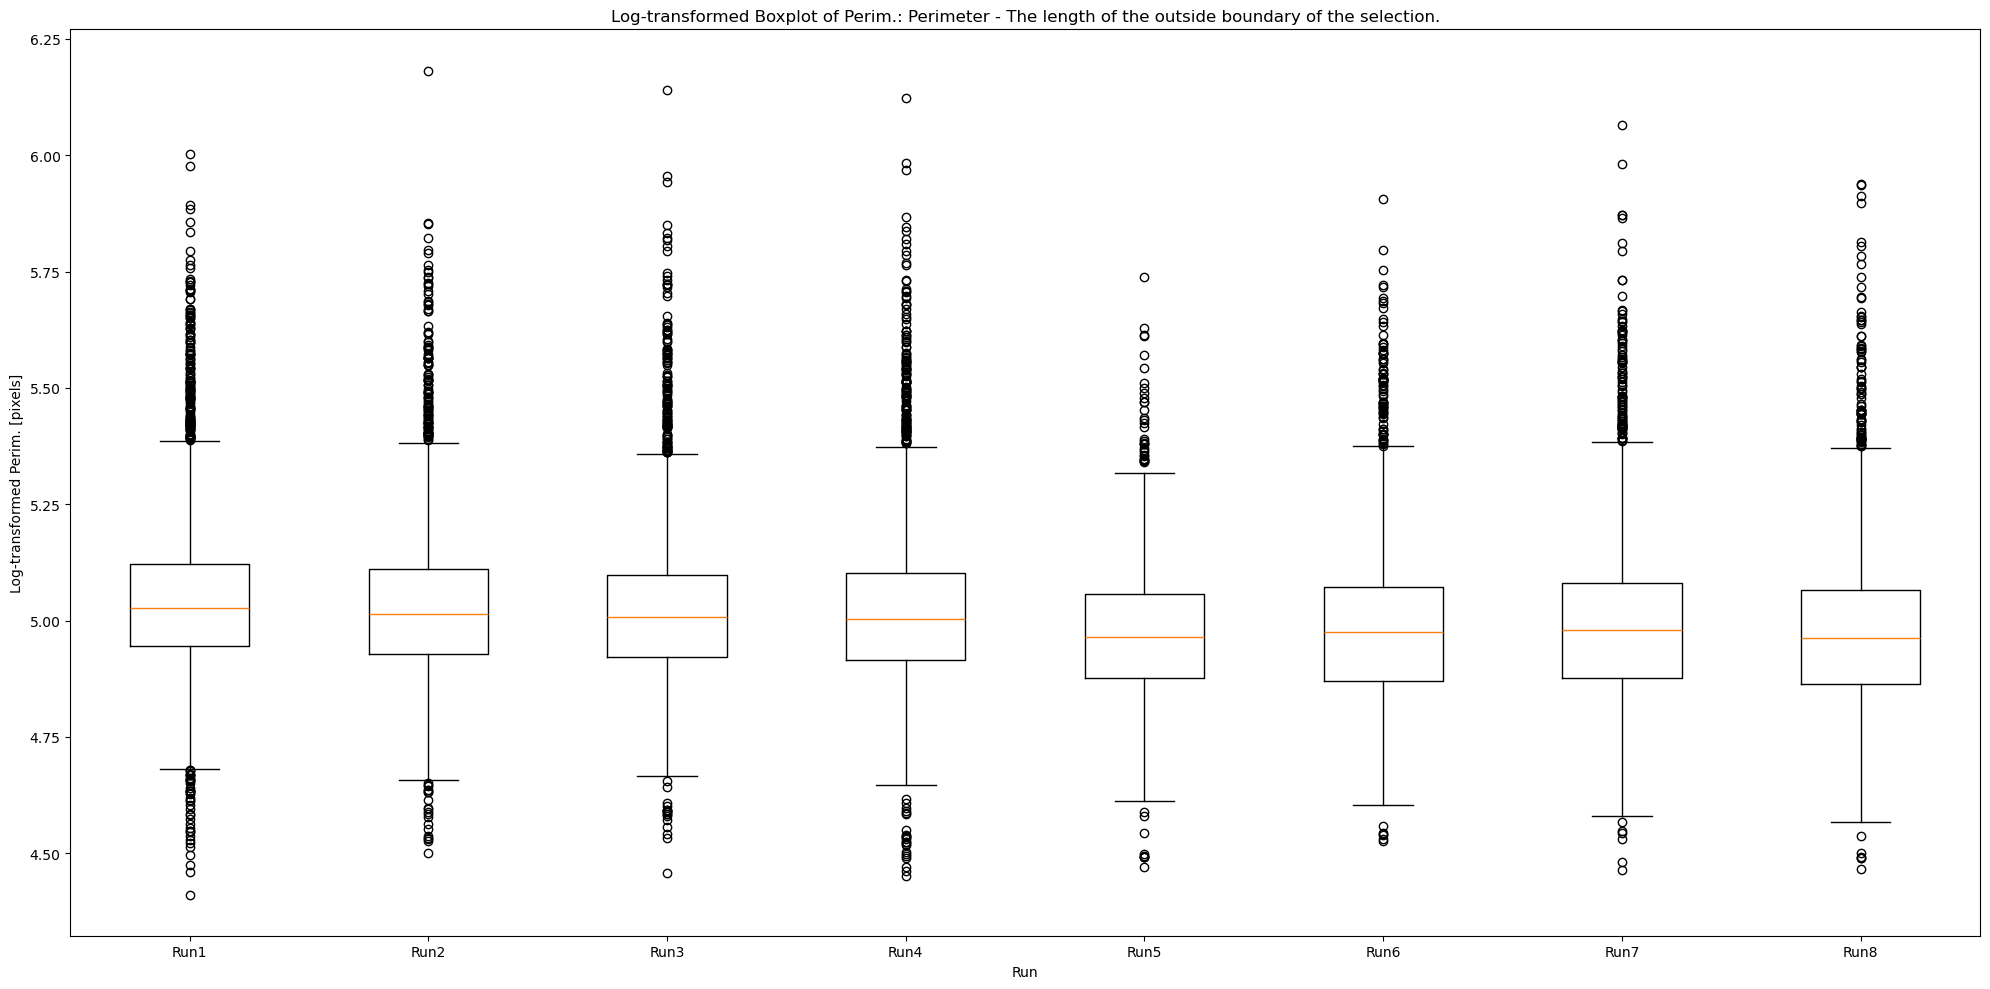

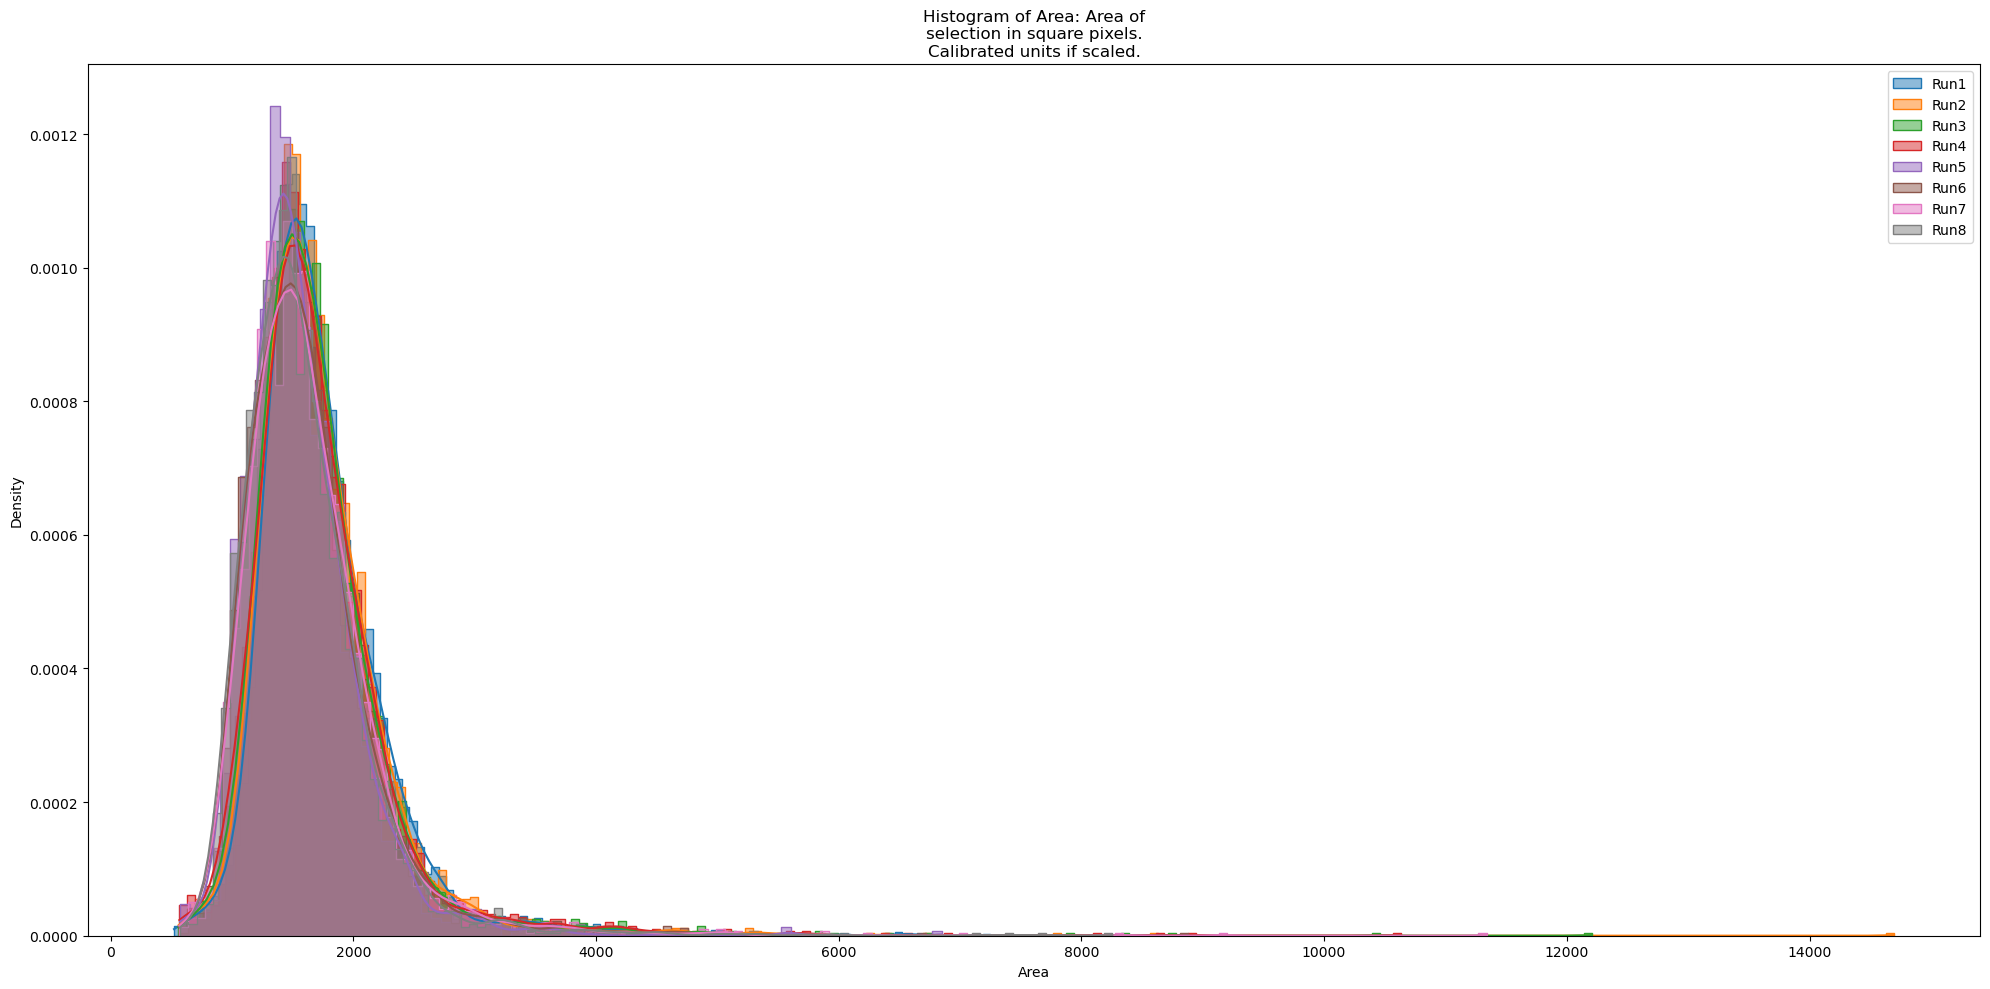

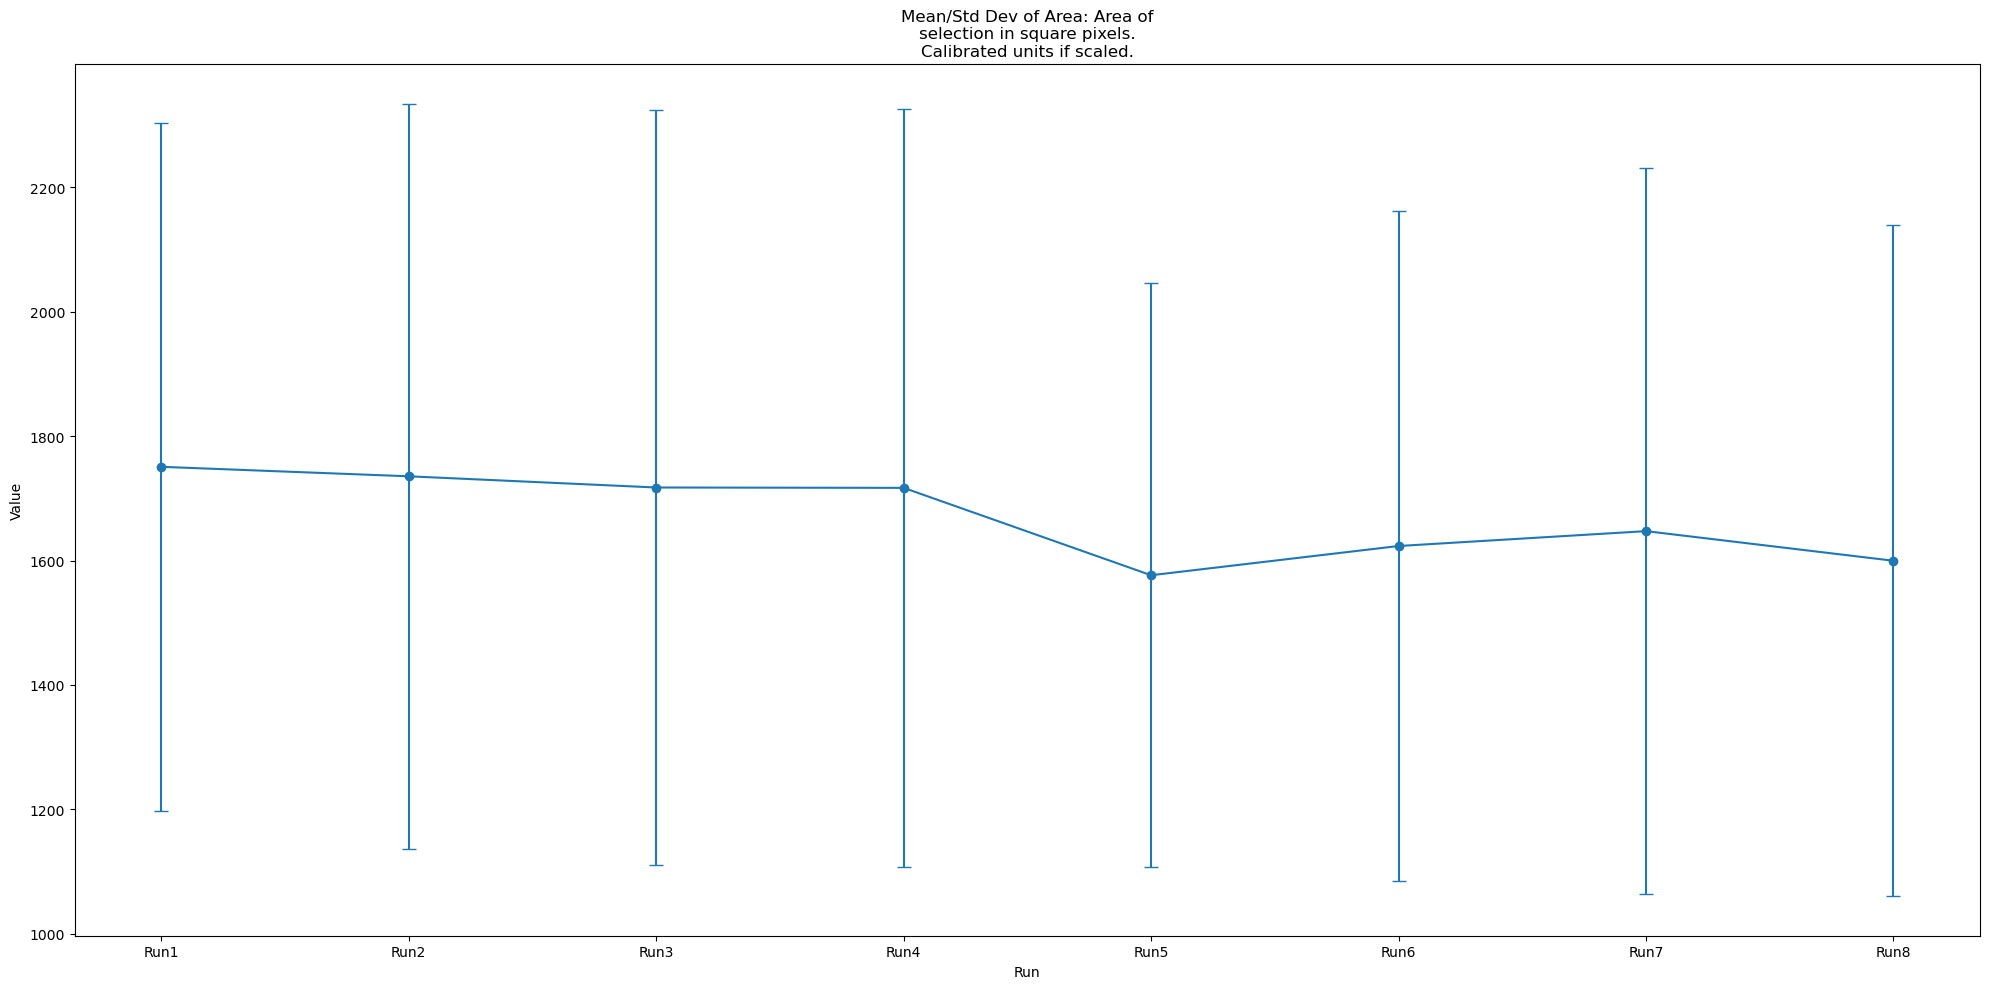

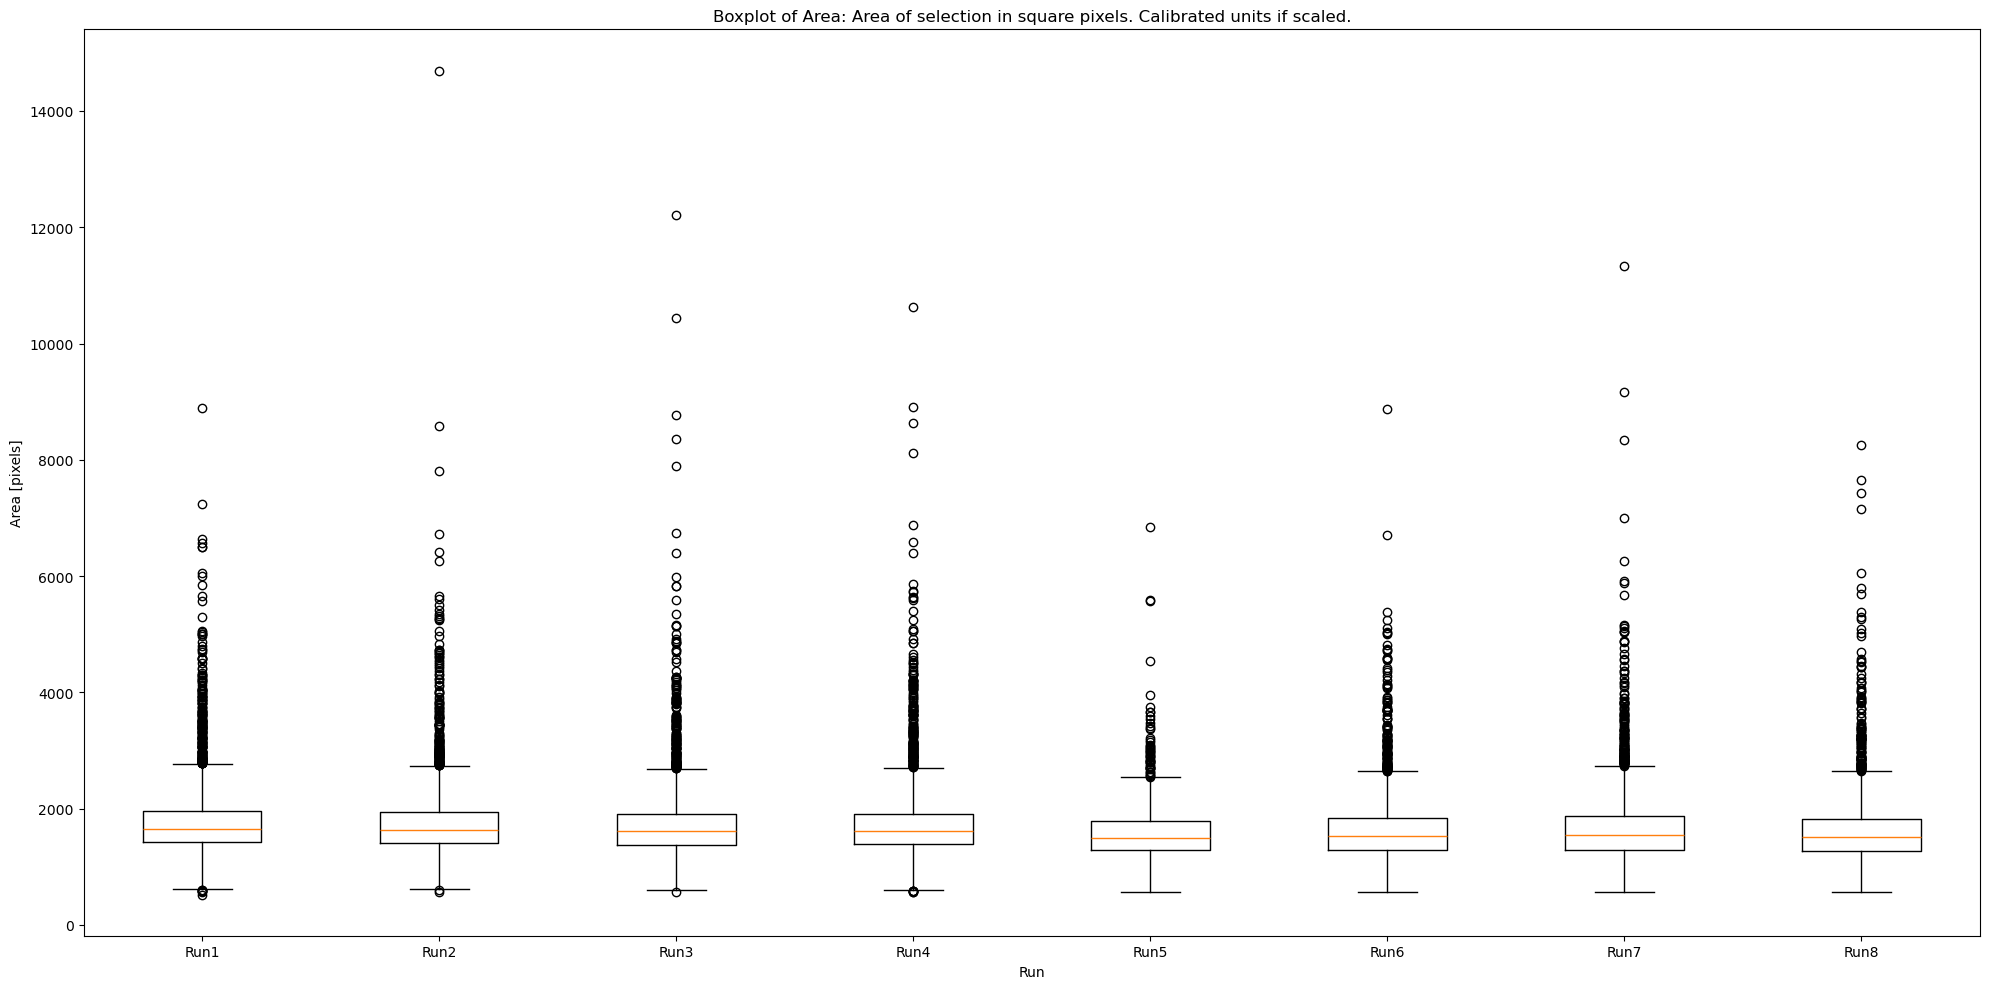

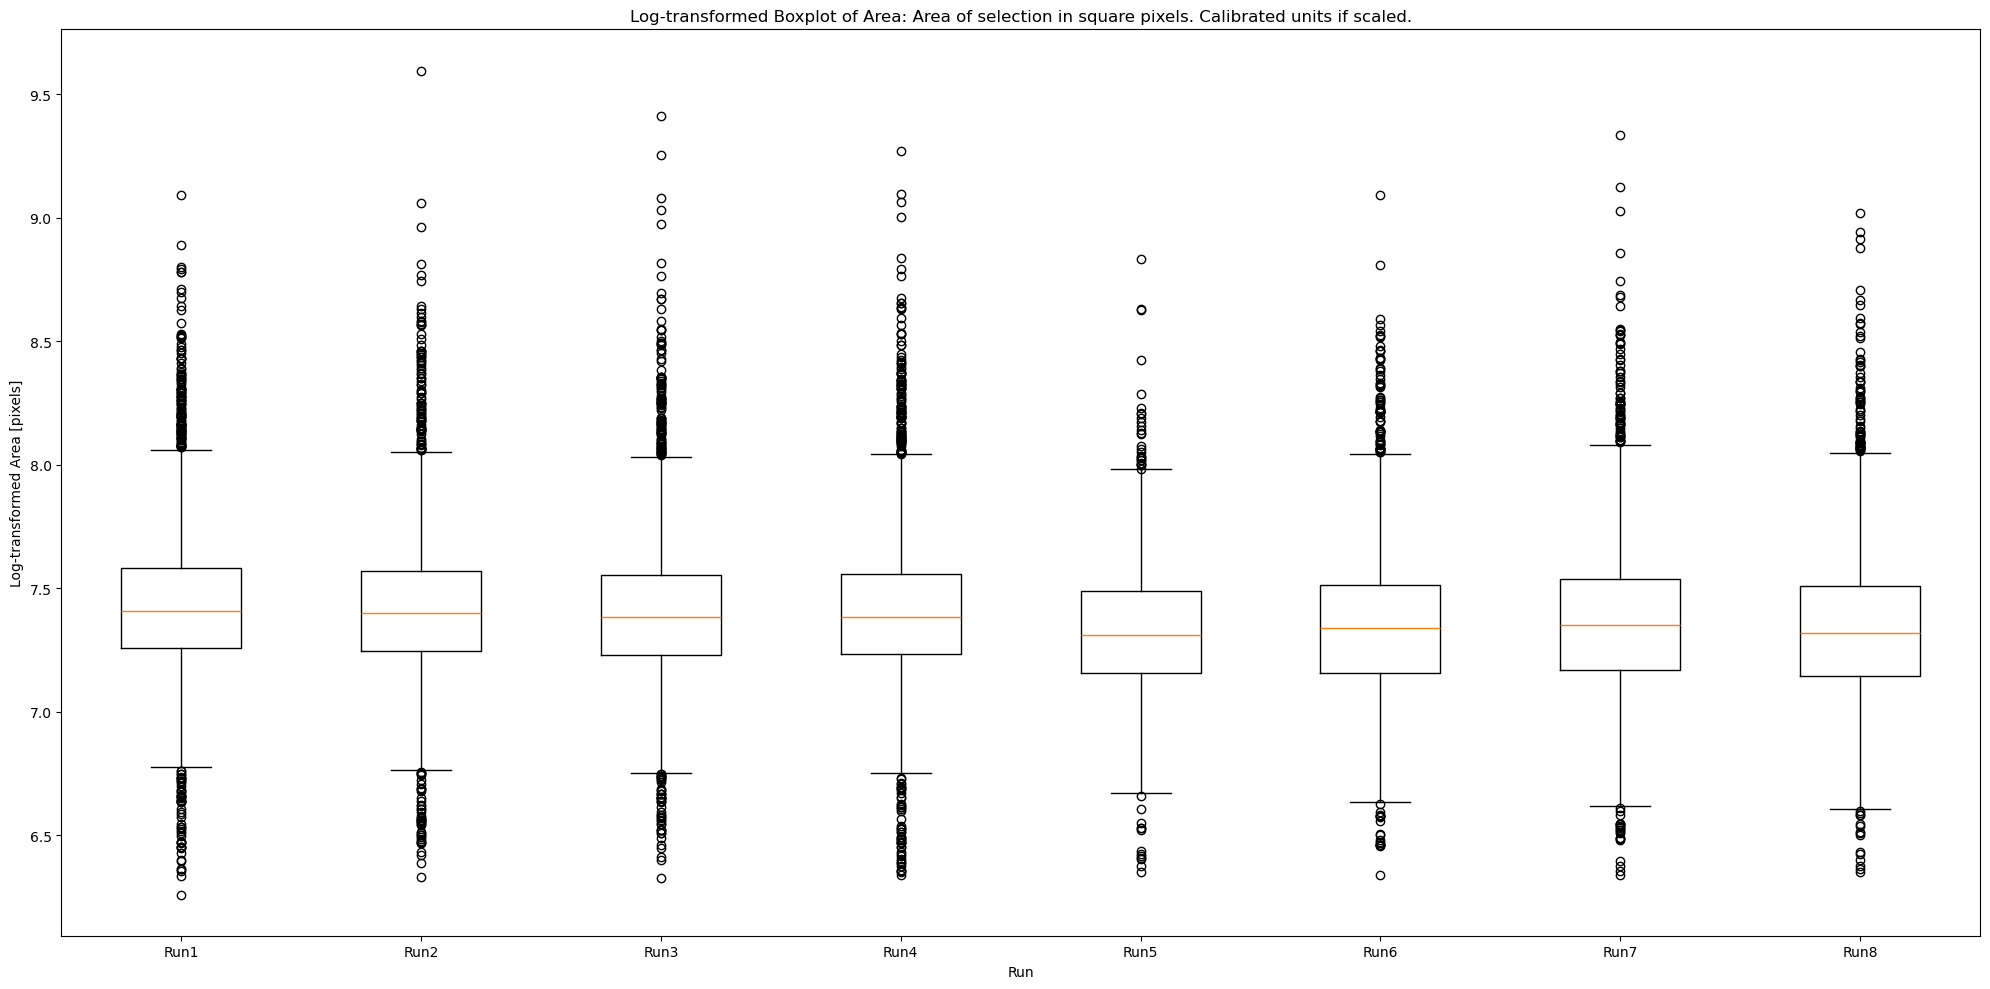

ANOVA for Round: F-Statistic = 374.28245908634244, p-value = 0.0
There is a statistically significant difference for Round across the runs.
ANOVA for Circ.: F-Statistic = 191.02277362653516, p-value = 9.606985198277593e-279
There is a statistically significant difference for Circ. across the runs.
ANOVA for AR: F-Statistic = 175.04010729848528, p-value = 1.8179474017987647e-255
There is a statistically significant difference for AR across the runs.
ANOVA for Height: F-Statistic = 163.20479038213227, p-value = 3.474947877096091e-238
There is a statistically significant difference for Height across the runs.
ANOVA for Major: F-Statistic = 160.59301973349056, p-value = 2.2886452981657153e-234
There is a statistically significant difference for Major across the runs.
ANOVA for Feret: F-Statistic = 157.71133514718775, p-value = 3.7579122256489825e-230
There is a statistically significant difference for Feret across the runs.
ANOVA for Slice: F-Statistic = 495.87985720113204, p-value = 0.0
T

In [4]:
# Single Run Analysis

analyze_run(list(data.keys())[1], data)

# Multiple Run Analysis

sheets_for_comparison = list(data.keys())[1:] 


time_intervals_data = pd.read_excel(file_path, sheet_name='RunTime')

# Drop NaN values and convert time to minutes
time_intervals = time_intervals_data['Time since detachment'].dropna()
time_intervals = time_intervals.apply(lambda x: x.hour * 60 + x.minute if pd.notnull(x) else x)

# Convert the time_intervals Series to a list
time_intervals = time_intervals.tolist()
dataframes = []
for i, run in enumerate(['Run1', 'Run2', 'Run3', 'Run4', 'Run5', 'Run6', 'Run7', 'Run8']):
    run_data = data[run].iloc[:, 1:]
    run_data['Time since detachment'] = time_intervals[i]
    dataframes.append(run_data.copy())


combined_data = pd.concat(dataframes, ignore_index=True)

# Calculate correlation matrices

pearson_correlation_matrix = combined_data.corr()
spearman_correlation_matrix = combined_data.corr(method='spearman')

# Extract correlations for 'Time since detachment'

pearson_time_correlations = pearson_correlation_matrix['Time since detachment']
spearman_time_correlations = spearman_correlation_matrix['Time since detachment']

# Sorting Pearson coefficients by magnitude and applying the sign

sorted_indices = pearson_time_correlations.abs().sort_values(ascending=False).index
sorted_pearson = pearson_time_correlations.loc[sorted_indices]

# Create DataFrame for all correlations with sorted Pearson coefficients

all_correlations = pd.DataFrame({
    'Metric': sorted_indices,
    'Pearson Coefficient': sorted_pearson.values,
    'Spearman Coefficient': spearman_time_correlations.loc[sorted_indices].values
})

# Display all correlations table

print("All Correlations with 'Time since detachment'")
print(all_correlations)

# Extract significant correlations (threshold = 0.1)

threshold = 0.1
significant_metrics = all_correlations[(abs(all_correlations['Pearson Coefficient']) >= threshold) |
                                       (abs(all_correlations['Spearman Coefficient']) >= threshold)]

# Remove 'Time since detachment' from significant metrics

significant_metrics = significant_metrics[significant_metrics['Metric'] != 'Time since detachment']
significant_metrics_list = list(significant_metrics['Metric'])

# Display significant correlations table

print("\nSignificant Correlations (Threshold: 0.1)")
print(significant_metrics)

# Plotting Histograms and Mean/Std Deviation for significant setrics

plot_metrics(data, sheets_for_comparison, significant_metrics_list)
analyze_metrics(data, sheets_for_comparison, significant_metrics_list)
